In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import normalize
from datetime import datetime

# Own functions
from functions import date_check, transform_weekday, normalise_weeks, standard_pivot, comparison_pivot, pivot_method, filter_params, heatmap

In [2]:
# TO CONSIDER

    # Possible partitions: day of week, hour of day, device, section, 
    # Some values are not addable across partitions - e.g. users, cookies, publications, purchases
    # Other values are fine: pageviews, article pageviews, long reads, active minutes
    # Visuals should be both heatmaps and timelines
    
    # Sections still behave unpredictably. Very few article pageviews are logged on "Nyheter", for example.
        # Is this related to kill-EPI and a new way of categorising articles?
        # Klumpa ihop Sverige, Världen etc. med Nyheter?
    
# TO DO    
    # Add purchases
    # Add users --------------------------- CHECK!
    # Normalise per week --------------------------- CHECK!
    # Add timelines
    # Add comparison periods --------------------------- CHECK!
    # Add flakscroll!
    # Filter outliers --- 
    

What you need to decide prior to running the notebook:
* The date range you wish to examine. 
* An older date range if you wish to make a comparison.
* If you want to examine browsers or accounts.

In [37]:
PROJECT = 'data-warehouse-dn'

# SELECT A TIME PERIOD TO ANALYZE. MAKE SURE IT IS MADE UP OF FULL WEEKS. 
FROM_DATE = '2020-12-01'
TO_DATE = '2021-01-11' # 01-10

# SELECT A COMPARISON TIME PERIOD (PREFERABLY WITH EQUAL # OF WEEKS).
FROM_DATE_COMP = '2020-03-01'
TO_DATE_COMP = '2020-05-02'

# SELECT ANALYSIS OF EITHER BROWSERS OR SUBSCRIBERS.
ID = 'client_id' # user_id, client_id

# (We will use this later.)
dates = {
    'from_date': FROM_DATE,
    'to_date': TO_DATE,
    'from_date_comp': FROM_DATE_COMP,
    'to_date_comp': TO_DATE_COMP
}

Make sure the date ranges you have selected are "complete weeks." The code block below will check this for you.

In [38]:
print("CURRENT DATE RANGE")
date_check(from_date=FROM_DATE, to_date=TO_DATE)
    
    
print("\nCOMPARISON DATE RANGE")
date_check(from_date=FROM_DATE_COMP, to_date=TO_DATE_COMP)

CURRENT DATE RANGE
Approved date range. Equal number of days of week.
Number of days: 42
Number of weeks: 6

COMPARISON DATE RANGE
Approved date range. Equal number of days of week.
Number of days: 63
Number of weeks: 9


# IMPORT DATA

## 1. READING (PAGEVIEWS, MINUTES SPENT)

In [76]:
test = (
    pd.read_gbq(f'''

        SELECT 
          pv.date,
          EXTRACT(DAYOFWEEK FROM pv.date) AS weekday,
          EXTRACT(HOUR FROM pv.timestamp AT TIME ZONE "Europe/Stockholm") AS hour, 
          device_category,
          login_status,
          referrer_category,
          section, 
          COUNT(DISTINCT pv.pageview_id) AS n_pageviews
        FROM `{PROJECT}.reynolds.pageview` pv 
          JOIN `{PROJECT}.reynolds.event` ev ON ev.date = pv.date AND ev.pageview_id = pv.pageview_id
        WHERE 1=1
          AND pv.date BETWEEN "{FROM_DATE}" AND "{TO_DATE}"
          AND sub_brand = "DNSE"
          AND {ID} NOT IN ("", "N/A", "(not set)")
          AND {ID} IS NOT NULL
          AND section IN ("Nyheter", "Världen", "Sverige", "Ekonomi", "Kultur", "Sport", "STHLM", "Gbg", "Ledare", "DN Debatt", "Insidan")
          AND content_id NOT IN ("", "N/A", "(not set)")
          AND content_id NOT LIKE "%dn.adhoc.%"
          AND content_id NOT LIKE "%dn.ctf%"
        GROUP BY 1,2,3,4,5,6,7

    ''', project_id=PROJECT)
)

Downloading: 100%|██████████| 208827/208827 [00:13<00:00, 15715.17rows/s]


In [77]:
test

date  weekday  hour device_category login_status  \
0      2020-12-01        3    12         desktop   Logged Out   
1      2020-12-01        3    11          mobile    Logged In   
2      2020-12-01        3    22         desktop    Logged In   
3      2020-12-01        3    19         desktop    Logged In   
4      2020-12-01        3     3          tablet   Logged Out   
...           ...      ...   ...             ...          ...   
208822 2021-01-11        2     1          tablet    Logged In   
208823 2021-01-11        2    19         desktop    Logged In   
208824 2021-01-11        2     4         desktop    Logged In   
208825 2021-01-11        2    17          tablet    Logged In   
208826 2021-01-11        2    12          tablet    Logged In   

       referrer_category  section  n_pageviews  
0                 direct    STHLM         2207  
1                 direct  Nyheter         6557  
2                 direct  Nyheter         7278  
3                 direct  Sverige         2259  
4               referral  Sverige            1  
...                  ...      ...          ...  
208822            social  Världen            2  
208823            search  Insidan            3  
208824            search  Insidan            1  
208825            social  Sverige            1  
208826          referral   Kultur            1  

[208827 rows x 8 columns]

In [115]:
def detect_outlier(data):
    
    outliers = []
    
    threshold = 2.5 # Two standard deviations capture ~95% of values, three ~99%. I opt for something in between.
    mean_1 = np.mean(data)
    std_1 = np.std(data)
    
    if std_1 == 0:
        return(pd.DataFrame())
    
    for y in data:
        z_score = (y - mean_1) / std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

In [123]:
test2 = test.copy()

In [124]:
secs = test2.section.unique()
devs = test2.device_category.unique()
refs = test2.referrer_category.unique()
logs = test2.login_status.unique()
wday = test2.weekday.unique()
hr = test2.hour.unique()

combs = len(secs) * len(devs) * len(refs) * len(logs) * len(wday) * len(hr)
print(combs)

59136


In [125]:
len(test2)

208827

In [116]:
count = 0

for w in wday:
    for h in hr:
        for s in secs:
            for d in devs:
                for r in refs:
                    for l in logs:
                        filtered_data = test.loc[(test.section==s) & 
                                                 (test.device_category==d) & 
                                                 (test.referrer_category==r) & 
                                                 (test.login_status==l)]
                        print("#####################################################")
                        count = count + 1
                        print(f"{count} / {combs}")
                        print("#####################################################")
                        print(f"{w} + {h} + {s} + {d} + {r} + {l}")
                        ol = detect_outlier(data=filtered_data.n_pageviews)
                        print(ol)
                        test2 = test2[~test2.n_pageviews.isin(ol)]
                        print("#####################################################")




STHLM + desktop + direct + Logged Out
[836, 867, 879, 831, 893, 873, 860, 866, 876, 832, 864]
STHLM + desktop + direct + Logged In
[1420, 1410, 1430, 1470, 1442, 1434, 1410, 1373, 1413, 1379, 1384, 1392, 1405, 1377, 1430, 1437, 1451, 1422]
STHLM + desktop + referral + Logged Out
Empty DataFrame
Columns: []
Index: []
STHLM + desktop + referral + Logged In
Empty DataFrame
Columns: []
Index: []
STHLM + desktop + search + Logged Out
[]
STHLM + desktop + search + Logged In
Empty DataFrame
Columns: []
Index: []
STHLM + desktop + social + Logged Out
Empty DataFrame
Columns: []
Index: []
STHLM + desktop + social + Logged In
Empty DataFrame
Columns: []
Index: []
STHLM + mobile + direct + Logged Out
[2324, 3214, 2967, 2498, 2814, 2935, 2818, 2250, 3276, 2985, 2216, 2633, 2613, 2558, 3063, 3338, 2562, 2654, 2154, 2392, 3106, 2773, 3183, 2978, 2967, 3377, 3132, 3390]
STHLM + mobile + direct + Logged In
[8237, 7847, 7737, 7552, 8293, 6831, 7207, 7957, 7312, 8710, 7843, 6948, 6999, 7248, 8817, 7216,

Ekonomi + mobile + social + Logged In
Empty DataFrame
Columns: []
Index: []
Ekonomi + tablet + direct + Logged Out
[374, 283, 386, 290]
Ekonomi + tablet + direct + Logged In
[1729, 2363, 2067, 1657, 3267, 2141, 2149, 2917, 2578, 3031, 2017, 1769, 1676, 2243, 2297, 2959, 2259, 1656, 2211]
Ekonomi + tablet + referral + Logged Out
[]
Ekonomi + tablet + referral + Logged In
[]
Ekonomi + tablet + search + Logged Out
[]
Ekonomi + tablet + search + Logged In
[]
Ekonomi + tablet + social + Logged Out
[]
Ekonomi + tablet + social + Logged In
[]
Ekonomi + other + direct + Logged Out
[]
Ekonomi + other + direct + Logged In
[]
Ekonomi + other + referral + Logged Out
[]
Ekonomi + other + referral + Logged In
[]
Ekonomi + other + search + Logged Out
[]
Ekonomi + other + search + Logged In
[]
Ekonomi + other + social + Logged Out
[]
Ekonomi + other + social + Logged In
[]
Kultur + desktop + direct + Logged Out
[2079, 1879, 1969, 2300, 1961, 2097, 1940, 2429, 1963, 2099, 2092, 2084, 2158, 2470, 2279, 

Sport + tablet + search + Logged Out
Empty DataFrame
Columns: []
Index: []
Sport + tablet + search + Logged In
[]
Sport + tablet + social + Logged Out
[]
Sport + tablet + social + Logged In
[]
Sport + other + direct + Logged Out
[]
Sport + other + direct + Logged In
[]
Sport + other + referral + Logged Out
[]
Sport + other + referral + Logged In
[]
Sport + other + search + Logged Out
[]
Sport + other + search + Logged In
[]
Sport + other + social + Logged Out
[]
Sport + other + social + Logged In
[]
DN Debatt + desktop + direct + Logged Out
[414, 436, 438, 430, 486, 426, 443, 582, 696, 415]
DN Debatt + desktop + direct + Logged In
[649, 803, 646, 628, 897, 1133, 975, 984, 632, 783, 895, 683]
DN Debatt + desktop + referral + Logged Out
[]
DN Debatt + desktop + referral + Logged In
[]
DN Debatt + desktop + search + Logged Out
[]
DN Debatt + desktop + search + Logged In
[]
DN Debatt + desktop + social + Logged Out
[]
DN Debatt + desktop + social + Logged In
[]
DN Debatt + mobile + direct 

Nyheter + other + search + Logged Out
[]
Nyheter + other + search + Logged In
[]
Nyheter + other + social + Logged Out
[]
Nyheter + other + social + Logged In
[]
Sverige + desktop + direct + Logged Out
[3898, 3844, 3952, 4078, 4110, 4068, 3907]
Sverige + desktop + direct + Logged In
[5994, 6061, 5971, 5989, 6297]
Sverige + desktop + referral + Logged Out
[393, 379, 371]
Sverige + desktop + referral + Logged In
[]
Sverige + desktop + search + Logged Out
[357, 347, 369, 349, 367, 337, 355]
Sverige + desktop + search + Logged In
[]
Sverige + desktop + social + Logged Out
[287]
Sverige + desktop + social + Logged In
[]
Sverige + mobile + direct + Logged Out
[8396, 8664, 8617, 8563, 8575, 8506, 7981, 7893, 8623, 8346, 8692, 8494]
Sverige + mobile + direct + Logged In
[26008, 26393, 25700, 26083, 25221, 25754]
Sverige + mobile + referral + Logged Out
[1036, 1194, 999, 1271, 1009, 1328, 1179]
Sverige + mobile + referral + Logged In
[]
Sverige + mobile + search + Logged Out
[1099, 1114, 1096, 

Ledare + mobile + search + Logged Out
[]
Ledare + mobile + search + Logged In
[]
Ledare + mobile + social + Logged Out
[455, 534, 410, 565, 550, 459, 391, 483]
Ledare + mobile + social + Logged In
[]
Ledare + tablet + direct + Logged Out
[]
Ledare + tablet + direct + Logged In
[1043, 954, 1073, 1108, 995]
Ledare + tablet + referral + Logged Out
[]
Ledare + tablet + referral + Logged In
[]
Ledare + tablet + search + Logged Out
[]
Ledare + tablet + search + Logged In
[]
Ledare + tablet + social + Logged Out
[]
Ledare + tablet + social + Logged In
[]
Ledare + other + direct + Logged Out
[]
Ledare + other + direct + Logged In
[]
Ledare + other + referral + Logged Out
[]
Ledare + other + referral + Logged In
[]
Ledare + other + search + Logged Out
[]
Ledare + other + search + Logged In
[]
Ledare + other + social + Logged Out
[]
Ledare + other + social + Logged In
[]
Sport + desktop + direct + Logged Out
[]
Sport + desktop + direct + Logged In
[2131, 2004, 1989, 2103, 2052]
Sport + desktop +

STHLM + other + direct + Logged In
[]
STHLM + other + referral + Logged Out
[]
STHLM + other + referral + Logged In
[]
STHLM + other + search + Logged Out
[]
STHLM + other + search + Logged In
[]
STHLM + other + social + Logged Out
[]
STHLM + other + social + Logged In
[]
Nyheter + desktop + direct + Logged Out
[]
Nyheter + desktop + direct + Logged In
[]
Nyheter + desktop + referral + Logged Out
[122]
Nyheter + desktop + referral + Logged In
[]
Nyheter + desktop + search + Logged Out
[]
Nyheter + desktop + search + Logged In
[388, 330, 338, 348, 348, 389, 329, 330, 338, 338, 329, 383, 388, 344]
Nyheter + desktop + social + Logged Out
[]
Nyheter + desktop + social + Logged In
[]
Nyheter + mobile + direct + Logged Out
[]
Nyheter + mobile + direct + Logged In
[]
Nyheter + mobile + referral + Logged Out
[]
Nyheter + mobile + referral + Logged In
[]
Nyheter + mobile + search + Logged Out
[]
Nyheter + mobile + search + Logged In
[]
Nyheter + mobile + social + Logged Out
[]
Nyheter + mobile 

Ledare + tablet + direct + Logged In
[899, 939]
Ledare + tablet + referral + Logged Out
[]
Ledare + tablet + referral + Logged In
[]
Ledare + tablet + search + Logged Out
[]
Ledare + tablet + search + Logged In
[]
Ledare + tablet + social + Logged Out
[]
Ledare + tablet + social + Logged In
[]
Ledare + other + direct + Logged Out
[]
Ledare + other + direct + Logged In
[]
Ledare + other + referral + Logged Out
[]
Ledare + other + referral + Logged In
[]
Ledare + other + search + Logged Out
[]
Ledare + other + search + Logged In
[]
Ledare + other + social + Logged Out
[]
Ledare + other + social + Logged In
[]
Sport + desktop + direct + Logged Out
[]
Sport + desktop + direct + Logged In
[]
Sport + desktop + referral + Logged Out
[145]
Sport + desktop + referral + Logged In
[]
Sport + desktop + search + Logged Out
[]
Sport + desktop + search + Logged In
[]
Sport + desktop + social + Logged Out
Empty DataFrame
Columns: []
Index: []
Sport + desktop + social + Logged In
[]
Sport + mobile + di

Nyheter + mobile + search + Logged Out
[]
Nyheter + mobile + search + Logged In
[]
Nyheter + mobile + social + Logged Out
[]
Nyheter + mobile + social + Logged In
[]
Nyheter + tablet + direct + Logged Out
[]
Nyheter + tablet + direct + Logged In
[]
Nyheter + tablet + referral + Logged Out
[]
Nyheter + tablet + referral + Logged In
[]
Nyheter + tablet + search + Logged Out
[]
Nyheter + tablet + search + Logged In
[]
Nyheter + tablet + social + Logged Out
[]
Nyheter + tablet + social + Logged In
[]
Nyheter + other + direct + Logged Out
[]
Nyheter + other + direct + Logged In
[]
Nyheter + other + referral + Logged Out
[]
Nyheter + other + referral + Logged In
[]
Nyheter + other + search + Logged Out
[]
Nyheter + other + search + Logged In
[]
Nyheter + other + social + Logged Out
[]
Nyheter + other + social + Logged In
[]
Sverige + desktop + direct + Logged Out
[]
Sverige + desktop + direct + Logged In
[]
Sverige + desktop + referral + Logged Out
[]
Sverige + desktop + referral + Logged In

Sport + mobile + direct + Logged Out
[1052]
Sport + mobile + direct + Logged In
[]
Sport + mobile + referral + Logged Out
[]
Sport + mobile + referral + Logged In
[]
Sport + mobile + search + Logged Out
[]
Sport + mobile + search + Logged In
Empty DataFrame
Columns: []
Index: []
Sport + mobile + social + Logged Out
[]
Sport + mobile + social + Logged In
[]
Sport + tablet + direct + Logged Out
[]
Sport + tablet + direct + Logged In
[]
Sport + tablet + referral + Logged Out
[]
Sport + tablet + referral + Logged In
[]
Sport + tablet + search + Logged Out
Empty DataFrame
Columns: []
Index: []
Sport + tablet + search + Logged In
[]
Sport + tablet + social + Logged Out
[]
Sport + tablet + social + Logged In
[]
Sport + other + direct + Logged Out
[]
Sport + other + direct + Logged In
[]
Sport + other + referral + Logged Out
[]
Sport + other + referral + Logged In
[]
Sport + other + search + Logged Out
[]
Sport + other + search + Logged In
[]
Sport + other + social + Logged Out
[]
Sport + othe

Sverige + mobile + search + Logged Out
[962, 976, 962, 969, 994]
Sverige + mobile + search + Logged In
[172]
Sverige + mobile + social + Logged Out
[877, 902, 924, 846, 833, 835, 923, 868, 932]
Sverige + mobile + social + Logged In
[]
Sverige + tablet + direct + Logged Out
[]
Sverige + tablet + direct + Logged In
[]
Sverige + tablet + referral + Logged Out
[]
Sverige + tablet + referral + Logged In
[]
Sverige + tablet + search + Logged Out
[]
Sverige + tablet + search + Logged In
[]
Sverige + tablet + social + Logged Out
[]
Sverige + tablet + social + Logged In
[]
Sverige + other + direct + Logged Out
[]
Sverige + other + direct + Logged In
[]
Sverige + other + referral + Logged Out
[]
Sverige + other + referral + Logged In
[]
Sverige + other + search + Logged Out
[]
Sverige + other + search + Logged In
[]
Sverige + other + social + Logged Out
[]
Sverige + other + social + Logged In
[]
Ekonomi + desktop + direct + Logged Out
[]
Ekonomi + desktop + direct + Logged In
[]
Ekonomi + deskto

DN Debatt + mobile + search + Logged In
[]
DN Debatt + mobile + social + Logged Out
[]
DN Debatt + mobile + social + Logged In
Empty DataFrame
Columns: []
Index: []
DN Debatt + tablet + direct + Logged Out
[]
DN Debatt + tablet + direct + Logged In
[]
DN Debatt + tablet + referral + Logged Out
[]
DN Debatt + tablet + referral + Logged In
[]
DN Debatt + tablet + search + Logged Out
[]
DN Debatt + tablet + search + Logged In
[]
DN Debatt + tablet + social + Logged Out
[]
DN Debatt + tablet + social + Logged In
[]
DN Debatt + other + direct + Logged Out
[]
DN Debatt + other + direct + Logged In
[]
DN Debatt + other + referral + Logged Out
[]
DN Debatt + other + referral + Logged In
[]
DN Debatt + other + search + Logged Out
[]
DN Debatt + other + search + Logged In
[]
DN Debatt + other + social + Logged Out
[]
DN Debatt + other + social + Logged In
[]
Insidan + desktop + direct + Logged Out
[]
Insidan + desktop + direct + Logged In
[]
Insidan + desktop + referral + Logged Out
[]
Insidan +

Ekonomi + other + direct + Logged Out
[]
Ekonomi + other + direct + Logged In
[]
Ekonomi + other + referral + Logged Out
[]
Ekonomi + other + referral + Logged In
[]
Ekonomi + other + search + Logged Out
[]
Ekonomi + other + search + Logged In
[]
Ekonomi + other + social + Logged Out
[]
Ekonomi + other + social + Logged In
[]
Kultur + desktop + direct + Logged Out
[]
Kultur + desktop + direct + Logged In
[]
Kultur + desktop + referral + Logged Out
[]
Kultur + desktop + referral + Logged In
[]
Kultur + desktop + search + Logged Out
[]
Kultur + desktop + search + Logged In
[]
Kultur + desktop + social + Logged Out
[]
Kultur + desktop + social + Logged In
[]
Kultur + mobile + direct + Logged Out
[]
Kultur + mobile + direct + Logged In
[10464]
Kultur + mobile + referral + Logged Out
[]
Kultur + mobile + referral + Logged In
[]
Kultur + mobile + search + Logged Out
[694, 694, 896, 933, 790, 896]
Kultur + mobile + search + Logged In
[]
Kultur + mobile + social + Logged Out
[]
Kultur + mobile

Insidan + tablet + social + Logged In
[]
Insidan + other + direct + Logged Out
[]
Insidan + other + direct + Logged In
[]
Insidan + other + referral + Logged Out
[]
Insidan + other + referral + Logged In
[]
Insidan + other + search + Logged Out
[]
Insidan + other + search + Logged In
[]
Insidan + other + social + Logged Out
[]
Insidan + other + social + Logged In
[]
Gbg + desktop + direct + Logged Out
[]
Gbg + desktop + direct + Logged In
Empty DataFrame
Columns: []
Index: []
Gbg + desktop + referral + Logged Out
[]
Gbg + desktop + referral + Logged In
[]
Gbg + desktop + search + Logged Out
[]
Gbg + desktop + search + Logged In
[]
Gbg + desktop + social + Logged Out
[]
Gbg + desktop + social + Logged In
[]
Gbg + mobile + direct + Logged Out
[]
Gbg + mobile + direct + Logged In
[]
Gbg + mobile + referral + Logged Out
[]
Gbg + mobile + referral + Logged In
[]
Gbg + mobile + search + Logged Out
[]
Gbg + mobile + search + Logged In
[]
Gbg + mobile + social + Logged Out
[]
Gbg + mobile + so

Världen + desktop + direct + Logged Out
[]
Världen + desktop + direct + Logged In
[]
Världen + desktop + referral + Logged Out
[]
Världen + desktop + referral + Logged In
[]
Världen + desktop + search + Logged Out
[]
Världen + desktop + search + Logged In
[]
Världen + desktop + social + Logged Out
[]
Världen + desktop + social + Logged In
[]
Världen + mobile + direct + Logged Out
[]
Världen + mobile + direct + Logged In
[17404, 17325, 17435, 17394]
Världen + mobile + referral + Logged Out
[]
Världen + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: []
Världen + mobile + search + Logged Out
[]
Världen + mobile + search + Logged In
[]
Världen + mobile + social + Logged Out
[237, 237, 237]
Världen + mobile + social + Logged In
[]
Världen + tablet + direct + Logged Out
[]
Världen + tablet + direct + Logged In
[]
Världen + tablet + referral + Logged Out
[]
Världen + tablet + referral + Logged In
[]
Världen + tablet + search + Logged Out
[]
Världen + tablet + search + Logged

Gbg + other + social + Logged In
[]
STHLM + desktop + direct + Logged Out
[]
STHLM + desktop + direct + Logged In
[1152, 1072]
STHLM + desktop + referral + Logged Out
[]
STHLM + desktop + referral + Logged In
[]
STHLM + desktop + search + Logged Out
[]
STHLM + desktop + search + Logged In
[]
STHLM + desktop + social + Logged Out
[]
STHLM + desktop + social + Logged In
[]
STHLM + mobile + direct + Logged Out
[]
STHLM + mobile + direct + Logged In
[]
STHLM + mobile + referral + Logged Out
[]
STHLM + mobile + referral + Logged In
[]
STHLM + mobile + search + Logged Out
[]
STHLM + mobile + search + Logged In
[]
STHLM + mobile + social + Logged Out
[]
STHLM + mobile + social + Logged In
[]
STHLM + tablet + direct + Logged Out
[]
STHLM + tablet + direct + Logged In
[]
STHLM + tablet + referral + Logged Out
[]
STHLM + tablet + referral + Logged In
[]
STHLM + tablet + search + Logged Out
[]
STHLM + tablet + search + Logged In
[]
STHLM + tablet + social + Logged Out
[]
STHLM + tablet + social +

Världen + other + search + Logged Out
[]
Världen + other + search + Logged In
[]
Världen + other + social + Logged Out
[]
Världen + other + social + Logged In
[]
Ledare + desktop + direct + Logged Out
[]
Ledare + desktop + direct + Logged In
[1168, 1247, 1284, 1326, 1241, 1209]
Ledare + desktop + referral + Logged Out
[]
Ledare + desktop + referral + Logged In
[]
Ledare + desktop + search + Logged Out
[]
Ledare + desktop + search + Logged In
[]
Ledare + desktop + social + Logged Out
[]
Ledare + desktop + social + Logged In
[]
Ledare + mobile + direct + Logged Out
[]
Ledare + mobile + direct + Logged In
[]
Ledare + mobile + referral + Logged Out
[]
Ledare + mobile + referral + Logged In
[]
Ledare + mobile + search + Logged Out
[]
Ledare + mobile + search + Logged In
[]
Ledare + mobile + social + Logged Out
[]
Ledare + mobile + social + Logged In
[]
Ledare + tablet + direct + Logged Out
[]
Ledare + tablet + direct + Logged In
[]
Ledare + tablet + referral + Logged Out
[]
Ledare + tablet 

Nyheter + desktop + referral + Logged Out
[]
Nyheter + desktop + referral + Logged In
[]
Nyheter + desktop + search + Logged Out
[]
Nyheter + desktop + search + Logged In
[]
Nyheter + desktop + social + Logged Out
[]
Nyheter + desktop + social + Logged In
[]
Nyheter + mobile + direct + Logged Out
[2181, 2368, 2314, 2230, 2290, 2358, 2039, 2270, 2231, 2125, 2321, 2261, 11906, 2386, 2224, 2007, 2318, 2352, 11725, 2033]
Nyheter + mobile + direct + Logged In
[1816, 2040, 2019, 2047, 2073, 1988, 1967, 1904, 12456]
Nyheter + mobile + referral + Logged Out
[]
Nyheter + mobile + referral + Logged In
[]
Nyheter + mobile + search + Logged Out
[1084, 1060, 1145]
Nyheter + mobile + search + Logged In
[]
Nyheter + mobile + social + Logged Out
[]
Nyheter + mobile + social + Logged In
[]
Nyheter + tablet + direct + Logged Out
[]
Nyheter + tablet + direct + Logged In
[]
Nyheter + tablet + referral + Logged Out
[]
Nyheter + tablet + referral + Logged In
[]
Nyheter + tablet + search + Logged Out
[204, 2

Sport + desktop + direct + Logged Out
[]
Sport + desktop + direct + Logged In
[]
Sport + desktop + referral + Logged Out
[]
Sport + desktop + referral + Logged In
[]
Sport + desktop + search + Logged Out
[]
Sport + desktop + search + Logged In
[]
Sport + desktop + social + Logged Out
[]
Sport + desktop + social + Logged In
[]
Sport + mobile + direct + Logged Out
[]
Sport + mobile + direct + Logged In
[]
Sport + mobile + referral + Logged Out
[]
Sport + mobile + referral + Logged In
[]
Sport + mobile + search + Logged Out
[]
Sport + mobile + search + Logged In
Empty DataFrame
Columns: []
Index: []
Sport + mobile + social + Logged Out
[]
Sport + mobile + social + Logged In
[]
Sport + tablet + direct + Logged Out
[]
Sport + tablet + direct + Logged In
[]
Sport + tablet + referral + Logged Out
[]
Sport + tablet + referral + Logged In
[]
Sport + tablet + search + Logged Out
Empty DataFrame
Columns: []
Index: []
Sport + tablet + search + Logged In
[]
Sport + tablet + social + Logged Out
[]
S

Nyheter + other + social + Logged Out
[]
Nyheter + other + social + Logged In
[]
Sverige + desktop + direct + Logged Out
[]
Sverige + desktop + direct + Logged In
[]
Sverige + desktop + referral + Logged Out
[]
Sverige + desktop + referral + Logged In
[]
Sverige + desktop + search + Logged Out
[]
Sverige + desktop + search + Logged In
[]
Sverige + desktop + social + Logged Out
[]
Sverige + desktop + social + Logged In
[]
Sverige + mobile + direct + Logged Out
[6900, 6934]
Sverige + mobile + direct + Logged In
[]
Sverige + mobile + referral + Logged Out
[]
Sverige + mobile + referral + Logged In
[]
Sverige + mobile + search + Logged Out
[]
Sverige + mobile + search + Logged In
[]
Sverige + mobile + social + Logged Out
[]
Sverige + mobile + social + Logged In
[]
Sverige + tablet + direct + Logged Out
[]
Sverige + tablet + direct + Logged In
[]
Sverige + tablet + referral + Logged Out
[]
Sverige + tablet + referral + Logged In
[]
Sverige + tablet + search + Logged Out
[]
Sverige + tablet 

DN Debatt + mobile + direct + Logged In
[]
DN Debatt + mobile + referral + Logged Out
[]
DN Debatt + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: []
DN Debatt + mobile + search + Logged Out
[]
DN Debatt + mobile + search + Logged In
[]
DN Debatt + mobile + social + Logged Out
[]
DN Debatt + mobile + social + Logged In
Empty DataFrame
Columns: []
Index: []
DN Debatt + tablet + direct + Logged Out
[]
DN Debatt + tablet + direct + Logged In
[]
DN Debatt + tablet + referral + Logged Out
[]
DN Debatt + tablet + referral + Logged In
[]
DN Debatt + tablet + search + Logged Out
[]
DN Debatt + tablet + search + Logged In
[]
DN Debatt + tablet + social + Logged Out
[]
DN Debatt + tablet + social + Logged In
[]
DN Debatt + other + direct + Logged Out
[]
DN Debatt + other + direct + Logged In
[]
DN Debatt + other + referral + Logged Out
[]
DN Debatt + other + referral + Logged In
[]
DN Debatt + other + search + Logged Out
[]
DN Debatt + other + search + Logged In
[]
DN Debatt +

Ekonomi + tablet + referral + Logged In
[]
Ekonomi + tablet + search + Logged Out
[]
Ekonomi + tablet + search + Logged In
[]
Ekonomi + tablet + social + Logged Out
[]
Ekonomi + tablet + social + Logged In
[]
Ekonomi + other + direct + Logged Out
[]
Ekonomi + other + direct + Logged In
[]
Ekonomi + other + referral + Logged Out
[]
Ekonomi + other + referral + Logged In
[]
Ekonomi + other + search + Logged Out
[]
Ekonomi + other + search + Logged In
[]
Ekonomi + other + social + Logged Out
[]
Ekonomi + other + social + Logged In
[]
Kultur + desktop + direct + Logged Out
[]
Kultur + desktop + direct + Logged In
[]
Kultur + desktop + referral + Logged Out
[]
Kultur + desktop + referral + Logged In
[]
Kultur + desktop + search + Logged Out
[]
Kultur + desktop + search + Logged In
[]
Kultur + desktop + social + Logged Out
[]
Kultur + desktop + social + Logged In
[]
Kultur + mobile + direct + Logged Out
[]
Kultur + mobile + direct + Logged In
[]
Kultur + mobile + referral + Logged Out
[]
Kul

Insidan + other + search + Logged In
[]
Insidan + other + social + Logged Out
[]
Insidan + other + social + Logged In
[]
Gbg + desktop + direct + Logged Out
[]
Gbg + desktop + direct + Logged In
Empty DataFrame
Columns: []
Index: []
Gbg + desktop + referral + Logged Out
[]
Gbg + desktop + referral + Logged In
[]
Gbg + desktop + search + Logged Out
[]
Gbg + desktop + search + Logged In
[]
Gbg + desktop + social + Logged Out
[]
Gbg + desktop + social + Logged In
[]
Gbg + mobile + direct + Logged Out
[]
Gbg + mobile + direct + Logged In
[]
Gbg + mobile + referral + Logged Out
[]
Gbg + mobile + referral + Logged In
[]
Gbg + mobile + search + Logged Out
[]
Gbg + mobile + search + Logged In
[]
Gbg + mobile + social + Logged Out
[]
Gbg + mobile + social + Logged In
[]
Gbg + tablet + direct + Logged Out
[]
Gbg + tablet + direct + Logged In
[]
Gbg + tablet + referral + Logged Out
[]
Gbg + tablet + referral + Logged In
[]
Gbg + tablet + search + Logged Out
[]
Gbg + tablet + search + Logged In
[]

Världen + mobile + search + Logged Out
[]
Världen + mobile + search + Logged In
[]
Världen + mobile + social + Logged Out
[]
Världen + mobile + social + Logged In
[]
Världen + tablet + direct + Logged Out
[]
Världen + tablet + direct + Logged In
[]
Världen + tablet + referral + Logged Out
[]
Världen + tablet + referral + Logged In
[]
Världen + tablet + search + Logged Out
[]
Världen + tablet + search + Logged In
[]
Världen + tablet + social + Logged Out
[]
Världen + tablet + social + Logged In
[]
Världen + other + direct + Logged Out
[]
Världen + other + direct + Logged In
[]
Världen + other + referral + Logged Out
[]
Världen + other + referral + Logged In
[]
Världen + other + search + Logged Out
[]
Världen + other + search + Logged In
[]
Världen + other + social + Logged Out
[]
Världen + other + social + Logged In
[]
Ledare + desktop + direct + Logged Out
[]
Ledare + desktop + direct + Logged In
[]
Ledare + desktop + referral + Logged Out
[]
Ledare + desktop + referral + Logged In
[]


STHLM + other + direct + Logged Out
[]
STHLM + other + direct + Logged In
[]
STHLM + other + referral + Logged Out
[]
STHLM + other + referral + Logged In
[]
STHLM + other + search + Logged Out
[]
STHLM + other + search + Logged In
[]
STHLM + other + social + Logged Out
[]
STHLM + other + social + Logged In
[]
Nyheter + desktop + direct + Logged Out
[]
Nyheter + desktop + direct + Logged In
[]
Nyheter + desktop + referral + Logged Out
[]
Nyheter + desktop + referral + Logged In
[]
Nyheter + desktop + search + Logged Out
[]
Nyheter + desktop + search + Logged In
[]
Nyheter + desktop + social + Logged Out
[]
Nyheter + desktop + social + Logged In
[]
Nyheter + mobile + direct + Logged Out
[4004, 3963, 3924, 3897]
Nyheter + mobile + direct + Logged In
[3240, 3268, 3294, 3511, 3542, 3250, 3364, 11665, 11499, 11523, 3502]
Nyheter + mobile + referral + Logged Out
[]
Nyheter + mobile + referral + Logged In
[]
Nyheter + mobile + search + Logged Out
[]
Nyheter + mobile + search + Logged In
[]
Ny

Sport + desktop + direct + Logged Out
[]
Sport + desktop + direct + Logged In
[]
Sport + desktop + referral + Logged Out
[]
Sport + desktop + referral + Logged In
[]
Sport + desktop + search + Logged Out
[]
Sport + desktop + search + Logged In
[]
Sport + desktop + social + Logged Out
[]
Sport + desktop + social + Logged In
[]
Sport + mobile + direct + Logged Out
[]
Sport + mobile + direct + Logged In
[]
Sport + mobile + referral + Logged Out
[]
Sport + mobile + referral + Logged In
[]
Sport + mobile + search + Logged Out
[]
Sport + mobile + search + Logged In
Empty DataFrame
Columns: []
Index: []
Sport + mobile + social + Logged Out
[]
Sport + mobile + social + Logged In
[]
Sport + tablet + direct + Logged Out
[]
Sport + tablet + direct + Logged In
[]
Sport + tablet + referral + Logged Out
[]
Sport + tablet + referral + Logged In
[]
Sport + tablet + search + Logged Out
Empty DataFrame
Columns: []
Index: []
Sport + tablet + search + Logged In
[]
Sport + tablet + social + Logged Out
[]
S

Sverige + mobile + referral + Logged Out
[]
Sverige + mobile + referral + Logged In
[]
Sverige + mobile + search + Logged Out
[]
Sverige + mobile + search + Logged In
[]
Sverige + mobile + social + Logged Out
[]
Sverige + mobile + social + Logged In
[]
Sverige + tablet + direct + Logged Out
[]
Sverige + tablet + direct + Logged In
[]
Sverige + tablet + referral + Logged Out
[]
Sverige + tablet + referral + Logged In
[]
Sverige + tablet + search + Logged Out
[]
Sverige + tablet + search + Logged In
[]
Sverige + tablet + social + Logged Out
[]
Sverige + tablet + social + Logged In
[]
Sverige + other + direct + Logged Out
[]
Sverige + other + direct + Logged In
[]
Sverige + other + referral + Logged Out
[]
Sverige + other + referral + Logged In
[]
Sverige + other + search + Logged Out
[]
Sverige + other + search + Logged In
[]
Sverige + other + social + Logged Out
[]
Sverige + other + social + Logged In
[]
Ekonomi + desktop + direct + Logged Out
[]
Ekonomi + desktop + direct + Logged In
[

DN Debatt + tablet + social + Logged Out
[]
DN Debatt + tablet + social + Logged In
[]
DN Debatt + other + direct + Logged Out
[]
DN Debatt + other + direct + Logged In
[]
DN Debatt + other + referral + Logged Out
[]
DN Debatt + other + referral + Logged In
[]
DN Debatt + other + search + Logged Out
[]
DN Debatt + other + search + Logged In
[]
DN Debatt + other + social + Logged Out
[]
DN Debatt + other + social + Logged In
[]
Insidan + desktop + direct + Logged Out
[]
Insidan + desktop + direct + Logged In
[]
Insidan + desktop + referral + Logged Out
[]
Insidan + desktop + referral + Logged In
[]
Insidan + desktop + search + Logged Out
[]
Insidan + desktop + search + Logged In
[]
Insidan + desktop + social + Logged Out
[]
Insidan + desktop + social + Logged In
[]
Insidan + mobile + direct + Logged Out
[]
Insidan + mobile + direct + Logged In
[]
Insidan + mobile + referral + Logged Out
[]
Insidan + mobile + referral + Logged In
[]
Insidan + mobile + search + Logged Out
[]
Insidan + mob

Kultur + desktop + social + Logged Out
[]
Kultur + desktop + social + Logged In
[]
Kultur + mobile + direct + Logged Out
[]
Kultur + mobile + direct + Logged In
[]
Kultur + mobile + referral + Logged Out
[]
Kultur + mobile + referral + Logged In
[]
Kultur + mobile + search + Logged Out
[]
Kultur + mobile + search + Logged In
[]
Kultur + mobile + social + Logged Out
[]
Kultur + mobile + social + Logged In
[]
Kultur + tablet + direct + Logged Out
[]
Kultur + tablet + direct + Logged In
[]
Kultur + tablet + referral + Logged Out
[]
Kultur + tablet + referral + Logged In
[]
Kultur + tablet + search + Logged Out
[]
Kultur + tablet + search + Logged In
[]
Kultur + tablet + social + Logged Out
[]
Kultur + tablet + social + Logged In
[]
Kultur + other + direct + Logged Out
[]
Kultur + other + direct + Logged In
[]
Kultur + other + referral + Logged Out
[]
Kultur + other + referral + Logged In
[]
Kultur + other + search + Logged Out
[]
Kultur + other + search + Logged In
[]
Kultur + other + soc

Gbg + mobile + direct + Logged Out
[]
Gbg + mobile + direct + Logged In
[]
Gbg + mobile + referral + Logged Out
[]
Gbg + mobile + referral + Logged In
[]
Gbg + mobile + search + Logged Out
[]
Gbg + mobile + search + Logged In
[]
Gbg + mobile + social + Logged Out
[]
Gbg + mobile + social + Logged In
[]
Gbg + tablet + direct + Logged Out
[]
Gbg + tablet + direct + Logged In
[]
Gbg + tablet + referral + Logged Out
[]
Gbg + tablet + referral + Logged In
[]
Gbg + tablet + search + Logged Out
[]
Gbg + tablet + search + Logged In
[]
Gbg + tablet + social + Logged Out
[]
Gbg + tablet + social + Logged In
[]
Gbg + other + direct + Logged Out
[]
Gbg + other + direct + Logged In
[]
Gbg + other + referral + Logged Out
[]
Gbg + other + referral + Logged In
[]
Gbg + other + search + Logged Out
[]
Gbg + other + search + Logged In
[]
Gbg + other + social + Logged Out
[]
Gbg + other + social + Logged In
[]
STHLM + desktop + direct + Logged Out
[]
STHLM + desktop + direct + Logged In
[]
STHLM + desktop

Världen + tablet + search + Logged In
[]
Världen + tablet + social + Logged Out
[]
Världen + tablet + social + Logged In
[]
Världen + other + direct + Logged Out
[]
Världen + other + direct + Logged In
[]
Världen + other + referral + Logged Out
[]
Världen + other + referral + Logged In
[]
Världen + other + search + Logged Out
[]
Världen + other + search + Logged In
[]
Världen + other + social + Logged Out
[]
Världen + other + social + Logged In
[]
Ledare + desktop + direct + Logged Out
[]
Ledare + desktop + direct + Logged In
[]
Ledare + desktop + referral + Logged Out
[]
Ledare + desktop + referral + Logged In
[]
Ledare + desktop + search + Logged Out
[]
Ledare + desktop + search + Logged In
[]
Ledare + desktop + social + Logged Out
[]
Ledare + desktop + social + Logged In
[]
Ledare + mobile + direct + Logged Out
[]
Ledare + mobile + direct + Logged In
[]
Ledare + mobile + referral + Logged Out
[]
Ledare + mobile + referral + Logged In
[]
Ledare + mobile + search + Logged Out
[]
Ledar

STHLM + other + direct + Logged In
[]
STHLM + other + referral + Logged Out
[]
STHLM + other + referral + Logged In
[]
STHLM + other + search + Logged Out
[]
STHLM + other + search + Logged In
[]
STHLM + other + social + Logged Out
[]
STHLM + other + social + Logged In
[]
Nyheter + desktop + direct + Logged Out
[]
Nyheter + desktop + direct + Logged In
[]
Nyheter + desktop + referral + Logged Out
[]
Nyheter + desktop + referral + Logged In
[]
Nyheter + desktop + search + Logged Out
[]
Nyheter + desktop + search + Logged In
[]
Nyheter + desktop + social + Logged Out
[]
Nyheter + desktop + social + Logged In
[]
Nyheter + mobile + direct + Logged Out
[]
Nyheter + mobile + direct + Logged In
[]
Nyheter + mobile + referral + Logged Out
[]
Nyheter + mobile + referral + Logged In
[]
Nyheter + mobile + search + Logged Out
[]
Nyheter + mobile + search + Logged In
[]
Nyheter + mobile + social + Logged Out
[]
Nyheter + mobile + social + Logged In
[]
Nyheter + tablet + direct + Logged Out
[]
Nyhet

Sport + desktop + search + Logged Out
[]
Sport + desktop + search + Logged In
[]
Sport + desktop + social + Logged Out
[]
Sport + desktop + social + Logged In
[]
Sport + mobile + direct + Logged Out
[]
Sport + mobile + direct + Logged In
[]
Sport + mobile + referral + Logged Out
[]
Sport + mobile + referral + Logged In
[]
Sport + mobile + search + Logged Out
[]
Sport + mobile + search + Logged In
Empty DataFrame
Columns: []
Index: []
Sport + mobile + social + Logged Out
[]
Sport + mobile + social + Logged In
[]
Sport + tablet + direct + Logged Out
[]
Sport + tablet + direct + Logged In
[]
Sport + tablet + referral + Logged Out
[]
Sport + tablet + referral + Logged In
[]
Sport + tablet + search + Logged Out
Empty DataFrame
Columns: []
Index: []
Sport + tablet + search + Logged In
[]
Sport + tablet + social + Logged Out
[]
Sport + tablet + social + Logged In
[]
Sport + other + direct + Logged Out
[]
Sport + other + direct + Logged In
[]
Sport + other + referral + Logged Out
[]
Sport + ot

Sverige + tablet + referral + Logged In
[]
Sverige + tablet + search + Logged Out
[]
Sverige + tablet + search + Logged In
[]
Sverige + tablet + social + Logged Out
[]
Sverige + tablet + social + Logged In
[]
Sverige + other + direct + Logged Out
[]
Sverige + other + direct + Logged In
[]
Sverige + other + referral + Logged Out
[]
Sverige + other + referral + Logged In
[]
Sverige + other + search + Logged Out
[]
Sverige + other + search + Logged In
[]
Sverige + other + social + Logged Out
[]
Sverige + other + social + Logged In
[]
Ekonomi + desktop + direct + Logged Out
[]
Ekonomi + desktop + direct + Logged In
[]
Ekonomi + desktop + referral + Logged Out
[]
Ekonomi + desktop + referral + Logged In
[]
Ekonomi + desktop + search + Logged Out
[]
Ekonomi + desktop + search + Logged In
[]
Ekonomi + desktop + social + Logged Out
Empty DataFrame
Columns: []
Index: []
Ekonomi + desktop + social + Logged In
[]
Ekonomi + mobile + direct + Logged Out
[]
Ekonomi + mobile + direct + Logged In
[]
E

DN Debatt + other + social + Logged In
[]
Insidan + desktop + direct + Logged Out
[]
Insidan + desktop + direct + Logged In
[]
Insidan + desktop + referral + Logged Out
[]
Insidan + desktop + referral + Logged In
[]
Insidan + desktop + search + Logged Out
[]
Insidan + desktop + search + Logged In
[]
Insidan + desktop + social + Logged Out
[]
Insidan + desktop + social + Logged In
[]
Insidan + mobile + direct + Logged Out
[]
Insidan + mobile + direct + Logged In
[]
Insidan + mobile + referral + Logged Out
[]
Insidan + mobile + referral + Logged In
[]
Insidan + mobile + search + Logged Out
[]
Insidan + mobile + search + Logged In
[]
Insidan + mobile + social + Logged Out
[]
Insidan + mobile + social + Logged In
[]
Insidan + tablet + direct + Logged Out
[]
Insidan + tablet + direct + Logged In
[]
Insidan + tablet + referral + Logged Out
[]
Insidan + tablet + referral + Logged In
[]
Insidan + tablet + search + Logged Out
[]
Insidan + tablet + search + Logged In
[]
Insidan + tablet + social

Kultur + mobile + social + Logged In
[]
Kultur + tablet + direct + Logged Out
[]
Kultur + tablet + direct + Logged In
[]
Kultur + tablet + referral + Logged Out
[]
Kultur + tablet + referral + Logged In
[]
Kultur + tablet + search + Logged Out
[]
Kultur + tablet + search + Logged In
[]
Kultur + tablet + social + Logged Out
[]
Kultur + tablet + social + Logged In
[]
Kultur + other + direct + Logged Out
[]
Kultur + other + direct + Logged In
[]
Kultur + other + referral + Logged Out
[]
Kultur + other + referral + Logged In
[]
Kultur + other + search + Logged Out
[]
Kultur + other + search + Logged In
[]
Kultur + other + social + Logged Out
[]
Kultur + other + social + Logged In
[]
Världen + desktop + direct + Logged Out
[]
Världen + desktop + direct + Logged In
[]
Världen + desktop + referral + Logged Out
[]
Världen + desktop + referral + Logged In
[]
Världen + desktop + search + Logged Out
[]
Världen + desktop + search + Logged In
[]
Världen + desktop + social + Logged Out
[]
Världen + 

Gbg + tablet + direct + Logged Out
[]
Gbg + tablet + direct + Logged In
[]
Gbg + tablet + referral + Logged Out
[]
Gbg + tablet + referral + Logged In
[]
Gbg + tablet + search + Logged Out
[]
Gbg + tablet + search + Logged In
[]
Gbg + tablet + social + Logged Out
[]
Gbg + tablet + social + Logged In
[]
Gbg + other + direct + Logged Out
[]
Gbg + other + direct + Logged In
[]
Gbg + other + referral + Logged Out
[]
Gbg + other + referral + Logged In
[]
Gbg + other + search + Logged Out
[]
Gbg + other + search + Logged In
[]
Gbg + other + social + Logged Out
[]
Gbg + other + social + Logged In
[]
STHLM + desktop + direct + Logged Out
[]
STHLM + desktop + direct + Logged In
[]
STHLM + desktop + referral + Logged Out
[]
STHLM + desktop + referral + Logged In
[]
STHLM + desktop + search + Logged Out
[]
STHLM + desktop + search + Logged In
[]
STHLM + desktop + social + Logged Out
[]
STHLM + desktop + social + Logged In
[]
STHLM + mobile + direct + Logged Out
[]
STHLM + mobile + direct + Logged

Ledare + desktop + direct + Logged In
[]
Ledare + desktop + referral + Logged Out
[]
Ledare + desktop + referral + Logged In
[]
Ledare + desktop + search + Logged Out
[]
Ledare + desktop + search + Logged In
[]
Ledare + desktop + social + Logged Out
[]
Ledare + desktop + social + Logged In
[]
Ledare + mobile + direct + Logged Out
[]
Ledare + mobile + direct + Logged In
[]
Ledare + mobile + referral + Logged Out
[]
Ledare + mobile + referral + Logged In
[]
Ledare + mobile + search + Logged Out
[]
Ledare + mobile + search + Logged In
[]
Ledare + mobile + social + Logged Out
[]
Ledare + mobile + social + Logged In
[]
Ledare + tablet + direct + Logged Out
[]
Ledare + tablet + direct + Logged In
[]
Ledare + tablet + referral + Logged Out
[]
Ledare + tablet + referral + Logged In
[]
Ledare + tablet + search + Logged Out
[]
Ledare + tablet + search + Logged In
[]
Ledare + tablet + social + Logged Out
[]
Ledare + tablet + social + Logged In
[]
Ledare + other + direct + Logged Out
[]
Ledare + o

Nyheter + mobile + search + Logged In
[]
Nyheter + mobile + social + Logged Out
[]
Nyheter + mobile + social + Logged In
[]
Nyheter + tablet + direct + Logged Out
[]
Nyheter + tablet + direct + Logged In
[]
Nyheter + tablet + referral + Logged Out
[]
Nyheter + tablet + referral + Logged In
[]
Nyheter + tablet + search + Logged Out
[]
Nyheter + tablet + search + Logged In
[]
Nyheter + tablet + social + Logged Out
[]
Nyheter + tablet + social + Logged In
[]
Nyheter + other + direct + Logged Out
[]
Nyheter + other + direct + Logged In
[]
Nyheter + other + referral + Logged Out
[]
Nyheter + other + referral + Logged In
[]
Nyheter + other + search + Logged Out
[]
Nyheter + other + search + Logged In
[]
Nyheter + other + social + Logged Out
[]
Nyheter + other + social + Logged In
[]
Sverige + desktop + direct + Logged Out
[]
Sverige + desktop + direct + Logged In
[]
Sverige + desktop + referral + Logged Out
[]
Sverige + desktop + referral + Logged In
[]
Sverige + desktop + search + Logged Ou

Sport + tablet + social + Logged Out
[]
Sport + tablet + social + Logged In
[]
Sport + other + direct + Logged Out
[]
Sport + other + direct + Logged In
[]
Sport + other + referral + Logged Out
[]
Sport + other + referral + Logged In
[]
Sport + other + search + Logged Out
[]
Sport + other + search + Logged In
[]
Sport + other + social + Logged Out
[]
Sport + other + social + Logged In
[]
DN Debatt + desktop + direct + Logged Out
[]
DN Debatt + desktop + direct + Logged In
[]
DN Debatt + desktop + referral + Logged Out
[]
DN Debatt + desktop + referral + Logged In
[]
DN Debatt + desktop + search + Logged Out
[]
DN Debatt + desktop + search + Logged In
[]
DN Debatt + desktop + social + Logged Out
[]
DN Debatt + desktop + social + Logged In
[]
DN Debatt + mobile + direct + Logged Out
[]
DN Debatt + mobile + direct + Logged In
[]
DN Debatt + mobile + referral + Logged Out
[]
DN Debatt + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: []
DN Debatt + mobile + search + Logged

Ekonomi + desktop + referral + Logged In
[]
Ekonomi + desktop + search + Logged Out
[]
Ekonomi + desktop + search + Logged In
[]
Ekonomi + desktop + social + Logged Out
Empty DataFrame
Columns: []
Index: []
Ekonomi + desktop + social + Logged In
[]
Ekonomi + mobile + direct + Logged Out
[]
Ekonomi + mobile + direct + Logged In
[]
Ekonomi + mobile + referral + Logged Out
[]
Ekonomi + mobile + referral + Logged In
[]
Ekonomi + mobile + search + Logged Out
[]
Ekonomi + mobile + search + Logged In
[]
Ekonomi + mobile + social + Logged Out
[]
Ekonomi + mobile + social + Logged In
[]
Ekonomi + tablet + direct + Logged Out
[]
Ekonomi + tablet + direct + Logged In
[]
Ekonomi + tablet + referral + Logged Out
[]
Ekonomi + tablet + referral + Logged In
[]
Ekonomi + tablet + search + Logged Out
[]
Ekonomi + tablet + search + Logged In
[]
Ekonomi + tablet + social + Logged Out
[]
Ekonomi + tablet + social + Logged In
[]
Ekonomi + other + direct + Logged Out
[]
Ekonomi + other + direct + Logged In
[

Insidan + mobile + direct + Logged Out
[]
Insidan + mobile + direct + Logged In
[]
Insidan + mobile + referral + Logged Out
[]
Insidan + mobile + referral + Logged In
[]
Insidan + mobile + search + Logged Out
[]
Insidan + mobile + search + Logged In
[]
Insidan + mobile + social + Logged Out
[]
Insidan + mobile + social + Logged In
[]
Insidan + tablet + direct + Logged Out
[]
Insidan + tablet + direct + Logged In
[]
Insidan + tablet + referral + Logged Out
[]
Insidan + tablet + referral + Logged In
[]
Insidan + tablet + search + Logged Out
[]
Insidan + tablet + search + Logged In
[]
Insidan + tablet + social + Logged Out
[]
Insidan + tablet + social + Logged In
[]
Insidan + other + direct + Logged Out
[]
Insidan + other + direct + Logged In
[]
Insidan + other + referral + Logged Out
[]
Insidan + other + referral + Logged In
[]
Insidan + other + search + Logged Out
[]
Insidan + other + search + Logged In
[]
Insidan + other + social + Logged Out
[]
Insidan + other + social + Logged In
[]


Kultur + other + referral + Logged In
[]
Kultur + other + search + Logged Out
[]
Kultur + other + search + Logged In
[]
Kultur + other + social + Logged Out
[]
Kultur + other + social + Logged In
[]
Världen + desktop + direct + Logged Out
[]
Världen + desktop + direct + Logged In
[]
Världen + desktop + referral + Logged Out
[]
Världen + desktop + referral + Logged In
[]
Världen + desktop + search + Logged Out
[]
Världen + desktop + search + Logged In
[]
Världen + desktop + social + Logged Out
[]
Världen + desktop + social + Logged In
[]
Världen + mobile + direct + Logged Out
[]
Världen + mobile + direct + Logged In
[]
Världen + mobile + referral + Logged Out
[]
Världen + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: []
Världen + mobile + search + Logged Out
[]
Världen + mobile + search + Logged In
[]
Världen + mobile + social + Logged Out
[]
Världen + mobile + social + Logged In
[]
Världen + tablet + direct + Logged Out
[]
Världen + tablet + direct + Logged In
[]
Vär

STHLM + desktop + referral + Logged Out
[]
STHLM + desktop + referral + Logged In
[]
STHLM + desktop + search + Logged Out
[]
STHLM + desktop + search + Logged In
[]
STHLM + desktop + social + Logged Out
[]
STHLM + desktop + social + Logged In
[]
STHLM + mobile + direct + Logged Out
[]
STHLM + mobile + direct + Logged In
[]
STHLM + mobile + referral + Logged Out
[]
STHLM + mobile + referral + Logged In
[]
STHLM + mobile + search + Logged Out
[]
STHLM + mobile + search + Logged In
[]
STHLM + mobile + social + Logged Out
[]
STHLM + mobile + social + Logged In
[]
STHLM + tablet + direct + Logged Out
[]
STHLM + tablet + direct + Logged In
[]
STHLM + tablet + referral + Logged Out
[]
STHLM + tablet + referral + Logged In
[]
STHLM + tablet + search + Logged Out
[]
STHLM + tablet + search + Logged In
[]
STHLM + tablet + social + Logged Out
[]
STHLM + tablet + social + Logged In
[]
STHLM + other + direct + Logged Out
[]
STHLM + other + direct + Logged In
[]
STHLM + other + referral + Logged Ou

Ledare + tablet + search + Logged Out
[]
Ledare + tablet + search + Logged In
[]
Ledare + tablet + social + Logged Out
[]
Ledare + tablet + social + Logged In
[]
Ledare + other + direct + Logged Out
[]
Ledare + other + direct + Logged In
[]
Ledare + other + referral + Logged Out
[]
Ledare + other + referral + Logged In
[]
Ledare + other + search + Logged Out
[]
Ledare + other + search + Logged In
[]
Ledare + other + social + Logged Out
[]
Ledare + other + social + Logged In
[]
Sport + desktop + direct + Logged Out
[]
Sport + desktop + direct + Logged In
[]
Sport + desktop + referral + Logged Out
[]
Sport + desktop + referral + Logged In
[]
Sport + desktop + search + Logged Out
[]
Sport + desktop + search + Logged In
[]
Sport + desktop + social + Logged Out
[]
Sport + desktop + social + Logged In
[]
Sport + mobile + direct + Logged Out
[]
Sport + mobile + direct + Logged In
[]
Sport + mobile + referral + Logged Out
[]
Sport + mobile + referral + Logged In
[]
Sport + mobile + search + Lo

Sverige + desktop + referral + Logged In
[]
Sverige + desktop + search + Logged Out
[]
Sverige + desktop + search + Logged In
[]
Sverige + desktop + social + Logged Out
[]
Sverige + desktop + social + Logged In
[]
Sverige + mobile + direct + Logged Out
[]
Sverige + mobile + direct + Logged In
[]
Sverige + mobile + referral + Logged Out
[]
Sverige + mobile + referral + Logged In
[]
Sverige + mobile + search + Logged Out
[]
Sverige + mobile + search + Logged In
[]
Sverige + mobile + social + Logged Out
[]
Sverige + mobile + social + Logged In
[]
Sverige + tablet + direct + Logged Out
[]
Sverige + tablet + direct + Logged In
[]
Sverige + tablet + referral + Logged Out
[]
Sverige + tablet + referral + Logged In
[]
Sverige + tablet + search + Logged Out
[]
Sverige + tablet + search + Logged In
[]
Sverige + tablet + social + Logged Out
[]
Sverige + tablet + social + Logged In
[]
Sverige + other + direct + Logged Out
[]
Sverige + other + direct + Logged In
[]
Sverige + other + referral + Logg

DN Debatt + mobile + referral + Logged Out
[]
DN Debatt + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: []
DN Debatt + mobile + search + Logged Out
[]
DN Debatt + mobile + search + Logged In
[]
DN Debatt + mobile + social + Logged Out
[]
DN Debatt + mobile + social + Logged In
Empty DataFrame
Columns: []
Index: []
DN Debatt + tablet + direct + Logged Out
[]
DN Debatt + tablet + direct + Logged In
[]
DN Debatt + tablet + referral + Logged Out
[]
DN Debatt + tablet + referral + Logged In
[]
DN Debatt + tablet + search + Logged Out
[]
DN Debatt + tablet + search + Logged In
[]
DN Debatt + tablet + social + Logged Out
[]
DN Debatt + tablet + social + Logged In
[]
DN Debatt + other + direct + Logged Out
[]
DN Debatt + other + direct + Logged In
[]
DN Debatt + other + referral + Logged Out
[]
DN Debatt + other + referral + Logged In
[]
DN Debatt + other + search + Logged Out
[]
DN Debatt + other + search + Logged In
[]
DN Debatt + other + social + Logged Out
[]
DN Debatt +

Ekonomi + other + referral + Logged Out
[]
Ekonomi + other + referral + Logged In
[]
Ekonomi + other + search + Logged Out
[]
Ekonomi + other + search + Logged In
[]
Ekonomi + other + social + Logged Out
[]
Ekonomi + other + social + Logged In
[]
Kultur + desktop + direct + Logged Out
[]
Kultur + desktop + direct + Logged In
[]
Kultur + desktop + referral + Logged Out
[]
Kultur + desktop + referral + Logged In
[]
Kultur + desktop + search + Logged Out
[]
Kultur + desktop + search + Logged In
[]
Kultur + desktop + social + Logged Out
[]
Kultur + desktop + social + Logged In
[]
Kultur + mobile + direct + Logged Out
[]
Kultur + mobile + direct + Logged In
[]
Kultur + mobile + referral + Logged Out
[]
Kultur + mobile + referral + Logged In
[]
Kultur + mobile + search + Logged Out
[]
Kultur + mobile + search + Logged In
[]
Kultur + mobile + social + Logged Out
[]
Kultur + mobile + social + Logged In
[]
Kultur + tablet + direct + Logged Out
[]
Kultur + tablet + direct + Logged In
[]
Kultur +

Gbg + desktop + referral + Logged Out
[]
Gbg + desktop + referral + Logged In
[]
Gbg + desktop + search + Logged Out
[]
Gbg + desktop + search + Logged In
[]
Gbg + desktop + social + Logged Out
[]
Gbg + desktop + social + Logged In
[]
Gbg + mobile + direct + Logged Out
[]
Gbg + mobile + direct + Logged In
[]
Gbg + mobile + referral + Logged Out
[]
Gbg + mobile + referral + Logged In
[]
Gbg + mobile + search + Logged Out
[]
Gbg + mobile + search + Logged In
[]
Gbg + mobile + social + Logged Out
[]
Gbg + mobile + social + Logged In
[]
Gbg + tablet + direct + Logged Out
[]
Gbg + tablet + direct + Logged In
[]
Gbg + tablet + referral + Logged Out
[]
Gbg + tablet + referral + Logged In
[]
Gbg + tablet + search + Logged Out
[]
Gbg + tablet + search + Logged In
[]
Gbg + tablet + social + Logged Out
[]
Gbg + tablet + social + Logged In
[]
Gbg + other + direct + Logged Out
[]
Gbg + other + direct + Logged In
[]
Gbg + other + referral + Logged Out
[]
Gbg + other + referral + Logged In
[]
Gbg + o

Världen + tablet + social + Logged In
[]
Världen + other + direct + Logged Out
[]
Världen + other + direct + Logged In
[]
Världen + other + referral + Logged Out
[]
Världen + other + referral + Logged In
[]
Världen + other + search + Logged Out
[]
Världen + other + search + Logged In
[]
Världen + other + social + Logged Out
[]
Världen + other + social + Logged In
[]
Ledare + desktop + direct + Logged Out
[]
Ledare + desktop + direct + Logged In
[]
Ledare + desktop + referral + Logged Out
[]
Ledare + desktop + referral + Logged In
[]
Ledare + desktop + search + Logged Out
[]
Ledare + desktop + search + Logged In
[]
Ledare + desktop + social + Logged Out
[]
Ledare + desktop + social + Logged In
[]
Ledare + mobile + direct + Logged Out
[]
Ledare + mobile + direct + Logged In
[]
Ledare + mobile + referral + Logged Out
[]
Ledare + mobile + referral + Logged In
[]
Ledare + mobile + search + Logged Out
[]
Ledare + mobile + search + Logged In
[]
Ledare + mobile + social + Logged Out
[]
Ledare 

Nyheter + desktop + social + Logged Out
[]
Nyheter + desktop + social + Logged In
[]
Nyheter + mobile + direct + Logged Out
[]
Nyheter + mobile + direct + Logged In
[]
Nyheter + mobile + referral + Logged Out
[]
Nyheter + mobile + referral + Logged In
[]
Nyheter + mobile + search + Logged Out
[]
Nyheter + mobile + search + Logged In
[]
Nyheter + mobile + social + Logged Out
[]
Nyheter + mobile + social + Logged In
[]
Nyheter + tablet + direct + Logged Out
[]
Nyheter + tablet + direct + Logged In
[]
Nyheter + tablet + referral + Logged Out
[]
Nyheter + tablet + referral + Logged In
[]
Nyheter + tablet + search + Logged Out
[]
Nyheter + tablet + search + Logged In
[]
Nyheter + tablet + social + Logged Out
[]
Nyheter + tablet + social + Logged In
[]
Nyheter + other + direct + Logged Out
[]
Nyheter + other + direct + Logged In
[]
Nyheter + other + referral + Logged Out
[]
Nyheter + other + referral + Logged In
[]
Nyheter + other + search + Logged Out
[]
Nyheter + other + search + Logged In

Sport + tablet + direct + Logged In
[]
Sport + tablet + referral + Logged Out
[]
Sport + tablet + referral + Logged In
[]
Sport + tablet + search + Logged Out
Empty DataFrame
Columns: []
Index: []
Sport + tablet + search + Logged In
[]
Sport + tablet + social + Logged Out
[]
Sport + tablet + social + Logged In
[]
Sport + other + direct + Logged Out
[]
Sport + other + direct + Logged In
[]
Sport + other + referral + Logged Out
[]
Sport + other + referral + Logged In
[]
Sport + other + search + Logged Out
[]
Sport + other + search + Logged In
[]
Sport + other + social + Logged Out
[]
Sport + other + social + Logged In
[]
DN Debatt + desktop + direct + Logged Out
[]
DN Debatt + desktop + direct + Logged In
[]
DN Debatt + desktop + referral + Logged Out
[]
DN Debatt + desktop + referral + Logged In
[]
DN Debatt + desktop + search + Logged Out
[]
DN Debatt + desktop + search + Logged In
[]
DN Debatt + desktop + social + Logged Out
[]
DN Debatt + desktop + social + Logged In
[]
DN Debatt + m

Sverige + other + referral + Logged Out
[]
Sverige + other + referral + Logged In
[]
Sverige + other + search + Logged Out
[]
Sverige + other + search + Logged In
[]
Sverige + other + social + Logged Out
[]
Sverige + other + social + Logged In
[]
Ekonomi + desktop + direct + Logged Out
[]
Ekonomi + desktop + direct + Logged In
[]
Ekonomi + desktop + referral + Logged Out
[]
Ekonomi + desktop + referral + Logged In
[]
Ekonomi + desktop + search + Logged Out
[]
Ekonomi + desktop + search + Logged In
[]
Ekonomi + desktop + social + Logged Out
Empty DataFrame
Columns: []
Index: []
Ekonomi + desktop + social + Logged In
[]
Ekonomi + mobile + direct + Logged Out
[]
Ekonomi + mobile + direct + Logged In
[]
Ekonomi + mobile + referral + Logged Out
[]
Ekonomi + mobile + referral + Logged In
[]
Ekonomi + mobile + search + Logged Out
[]
Ekonomi + mobile + search + Logged In
[]
Ekonomi + mobile + social + Logged Out
[]
Ekonomi + mobile + social + Logged In
[]
Ekonomi + tablet + direct + Logged Out

DN Debatt + other + social + Logged Out
[]
DN Debatt + other + social + Logged In
[]
Insidan + desktop + direct + Logged Out
[]
Insidan + desktop + direct + Logged In
[]
Insidan + desktop + referral + Logged Out
[]
Insidan + desktop + referral + Logged In
[]
Insidan + desktop + search + Logged Out
[]
Insidan + desktop + search + Logged In
[]
Insidan + desktop + social + Logged Out
[]
Insidan + desktop + social + Logged In
[]
Insidan + mobile + direct + Logged Out
[]
Insidan + mobile + direct + Logged In
[]
Insidan + mobile + referral + Logged Out
[]
Insidan + mobile + referral + Logged In
[]
Insidan + mobile + search + Logged Out
[]
Insidan + mobile + search + Logged In
[]
Insidan + mobile + social + Logged Out
[]
Insidan + mobile + social + Logged In
[]
Insidan + tablet + direct + Logged Out
[]
Insidan + tablet + direct + Logged In
[]
Insidan + tablet + referral + Logged Out
[]
Insidan + tablet + referral + Logged In
[]
Insidan + tablet + search + Logged Out
[]
Insidan + tablet + sear

Kultur + desktop + search + Logged Out
[]
Kultur + desktop + search + Logged In
[]
Kultur + desktop + social + Logged Out
[]
Kultur + desktop + social + Logged In
[]
Kultur + mobile + direct + Logged Out
[]
Kultur + mobile + direct + Logged In
[]
Kultur + mobile + referral + Logged Out
[]
Kultur + mobile + referral + Logged In
[]
Kultur + mobile + search + Logged Out
[]
Kultur + mobile + search + Logged In
[]
Kultur + mobile + social + Logged Out
[]
Kultur + mobile + social + Logged In
[]
Kultur + tablet + direct + Logged Out
[]
Kultur + tablet + direct + Logged In
[]
Kultur + tablet + referral + Logged Out
[]
Kultur + tablet + referral + Logged In
[]
Kultur + tablet + search + Logged Out
[]
Kultur + tablet + search + Logged In
[]
Kultur + tablet + social + Logged Out
[]
Kultur + tablet + social + Logged In
[]
Kultur + other + direct + Logged Out
[]
Kultur + other + direct + Logged In
[]
Kultur + other + referral + Logged Out
[]
Kultur + other + referral + Logged In
[]
Kultur + other +

Gbg + tablet + referral + Logged Out
[]
Gbg + tablet + referral + Logged In
[]
Gbg + tablet + search + Logged Out
[]
Gbg + tablet + search + Logged In
[]
Gbg + tablet + social + Logged Out
[]
Gbg + tablet + social + Logged In
[]
Gbg + other + direct + Logged Out
[]
Gbg + other + direct + Logged In
[]
Gbg + other + referral + Logged Out
[]
Gbg + other + referral + Logged In
[]
Gbg + other + search + Logged Out
[]
Gbg + other + search + Logged In
[]
Gbg + other + social + Logged Out
[]
Gbg + other + social + Logged In
[]
STHLM + desktop + direct + Logged Out
[]
STHLM + desktop + direct + Logged In
[]
STHLM + desktop + referral + Logged Out
[]
STHLM + desktop + referral + Logged In
[]
STHLM + desktop + search + Logged Out
[]
STHLM + desktop + search + Logged In
[]
STHLM + desktop + social + Logged Out
[]
STHLM + desktop + social + Logged In
[]
STHLM + mobile + direct + Logged Out
[]
STHLM + mobile + direct + Logged In
[]
STHLM + mobile + referral + Logged Out
[]
STHLM + mobile + referral 

Världen + other + social + Logged Out
[]
Världen + other + social + Logged In
[]
Ledare + desktop + direct + Logged Out
[]
Ledare + desktop + direct + Logged In
[]
Ledare + desktop + referral + Logged Out
[]
Ledare + desktop + referral + Logged In
[]
Ledare + desktop + search + Logged Out
[]
Ledare + desktop + search + Logged In
[]
Ledare + desktop + social + Logged Out
[]
Ledare + desktop + social + Logged In
[]
Ledare + mobile + direct + Logged Out
[]
Ledare + mobile + direct + Logged In
[]
Ledare + mobile + referral + Logged Out
[]
Ledare + mobile + referral + Logged In
[]
Ledare + mobile + search + Logged Out
[]
Ledare + mobile + search + Logged In
[]
Ledare + mobile + social + Logged Out
[]
Ledare + mobile + social + Logged In
[]
Ledare + tablet + direct + Logged Out
[]
Ledare + tablet + direct + Logged In
[]
Ledare + tablet + referral + Logged Out
[]
Ledare + tablet + referral + Logged In
[]
Ledare + tablet + search + Logged Out
[]
Ledare + tablet + search + Logged In
[]
Ledare +

Nyheter + mobile + direct + Logged In
[]
Nyheter + mobile + referral + Logged Out
[]
Nyheter + mobile + referral + Logged In
[]
Nyheter + mobile + search + Logged Out
[]
Nyheter + mobile + search + Logged In
[]
Nyheter + mobile + social + Logged Out
[]
Nyheter + mobile + social + Logged In
[]
Nyheter + tablet + direct + Logged Out
[]
Nyheter + tablet + direct + Logged In
[]
Nyheter + tablet + referral + Logged Out
[]
Nyheter + tablet + referral + Logged In
[]
Nyheter + tablet + search + Logged Out
[]
Nyheter + tablet + search + Logged In
[]
Nyheter + tablet + social + Logged Out
[]
Nyheter + tablet + social + Logged In
[]
Nyheter + other + direct + Logged Out
[]
Nyheter + other + direct + Logged In
[]
Nyheter + other + referral + Logged Out
[]
Nyheter + other + referral + Logged In
[]
Nyheter + other + search + Logged Out
[]
Nyheter + other + search + Logged In
[]
Nyheter + other + social + Logged Out
[]
Nyheter + other + social + Logged In
[]
Sverige + desktop + direct + Logged Out
[]

Sport + tablet + social + Logged In
[]
Sport + other + direct + Logged Out
[]
Sport + other + direct + Logged In
[]
Sport + other + referral + Logged Out
[]
Sport + other + referral + Logged In
[]
Sport + other + search + Logged Out
[]
Sport + other + search + Logged In
[]
Sport + other + social + Logged Out
[]
Sport + other + social + Logged In
[]
DN Debatt + desktop + direct + Logged Out
[]
DN Debatt + desktop + direct + Logged In
[]
DN Debatt + desktop + referral + Logged Out
[]
DN Debatt + desktop + referral + Logged In
[]
DN Debatt + desktop + search + Logged Out
[]
DN Debatt + desktop + search + Logged In
[]
DN Debatt + desktop + social + Logged Out
[]
DN Debatt + desktop + social + Logged In
[]
DN Debatt + mobile + direct + Logged Out
[]
DN Debatt + mobile + direct + Logged In
[]
DN Debatt + mobile + referral + Logged Out
[]
DN Debatt + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: []
DN Debatt + mobile + search + Logged Out
[]
DN Debatt + mobile + search + Lo

Ekonomi + desktop + referral + Logged In
[]
Ekonomi + desktop + search + Logged Out
[]
Ekonomi + desktop + search + Logged In
[]
Ekonomi + desktop + social + Logged Out
Empty DataFrame
Columns: []
Index: []
Ekonomi + desktop + social + Logged In
[]
Ekonomi + mobile + direct + Logged Out
[]
Ekonomi + mobile + direct + Logged In
[]
Ekonomi + mobile + referral + Logged Out
[]
Ekonomi + mobile + referral + Logged In
[]
Ekonomi + mobile + search + Logged Out
[]
Ekonomi + mobile + search + Logged In
[]
Ekonomi + mobile + social + Logged Out
[]
Ekonomi + mobile + social + Logged In
[]
Ekonomi + tablet + direct + Logged Out
[]
Ekonomi + tablet + direct + Logged In
[]
Ekonomi + tablet + referral + Logged Out
[]
Ekonomi + tablet + referral + Logged In
[]
Ekonomi + tablet + search + Logged Out
[]
Ekonomi + tablet + search + Logged In
[]
Ekonomi + tablet + social + Logged Out
[]
Ekonomi + tablet + social + Logged In
[]
Ekonomi + other + direct + Logged Out
[]
Ekonomi + other + direct + Logged In
[

Insidan + desktop + social + Logged In
[]
Insidan + mobile + direct + Logged Out
[]
Insidan + mobile + direct + Logged In
[]
Insidan + mobile + referral + Logged Out
[]
Insidan + mobile + referral + Logged In
[]
Insidan + mobile + search + Logged Out
[]
Insidan + mobile + search + Logged In
[]
Insidan + mobile + social + Logged Out
[]
Insidan + mobile + social + Logged In
[]
Insidan + tablet + direct + Logged Out
[]
Insidan + tablet + direct + Logged In
[]
Insidan + tablet + referral + Logged Out
[]
Insidan + tablet + referral + Logged In
[]
Insidan + tablet + search + Logged Out
[]
Insidan + tablet + search + Logged In
[]
Insidan + tablet + social + Logged Out
[]
Insidan + tablet + social + Logged In
[]
Insidan + other + direct + Logged Out
[]
Insidan + other + direct + Logged In
[]
Insidan + other + referral + Logged Out
[]
Insidan + other + referral + Logged In
[]
Insidan + other + search + Logged Out
[]
Insidan + other + search + Logged In
[]
Insidan + other + social + Logged Out
[

Kultur + tablet + search + Logged Out
[]
Kultur + tablet + search + Logged In
[]
Kultur + tablet + social + Logged Out
[]
Kultur + tablet + social + Logged In
[]
Kultur + other + direct + Logged Out
[]
Kultur + other + direct + Logged In
[]
Kultur + other + referral + Logged Out
[]
Kultur + other + referral + Logged In
[]
Kultur + other + search + Logged Out
[]
Kultur + other + search + Logged In
[]
Kultur + other + social + Logged Out
[]
Kultur + other + social + Logged In
[]
Världen + desktop + direct + Logged Out
[]
Världen + desktop + direct + Logged In
[]
Världen + desktop + referral + Logged Out
[]
Världen + desktop + referral + Logged In
[]
Världen + desktop + search + Logged Out
[]
Världen + desktop + search + Logged In
[]
Världen + desktop + social + Logged Out
[]
Världen + desktop + social + Logged In
[]
Världen + mobile + direct + Logged Out
[]
Världen + mobile + direct + Logged In
[]
Världen + mobile + referral + Logged Out
[]
Världen + mobile + referral + Logged In
Empty D

Gbg + other + search + Logged Out
[]
Gbg + other + search + Logged In
[]
Gbg + other + social + Logged Out
[]
Gbg + other + social + Logged In
[]
STHLM + desktop + direct + Logged Out
[]
STHLM + desktop + direct + Logged In
[]
STHLM + desktop + referral + Logged Out
[]
STHLM + desktop + referral + Logged In
[]
STHLM + desktop + search + Logged Out
[]
STHLM + desktop + search + Logged In
[]
STHLM + desktop + social + Logged Out
[]
STHLM + desktop + social + Logged In
[]
STHLM + mobile + direct + Logged Out
[]
STHLM + mobile + direct + Logged In
[]
STHLM + mobile + referral + Logged Out
[]
STHLM + mobile + referral + Logged In
[]
STHLM + mobile + search + Logged Out
[]
STHLM + mobile + search + Logged In
[]
STHLM + mobile + social + Logged Out
[]
STHLM + mobile + social + Logged In
[]
STHLM + tablet + direct + Logged Out
[]
STHLM + tablet + direct + Logged In
[]
STHLM + tablet + referral + Logged Out
[]
STHLM + tablet + referral + Logged In
[]
STHLM + tablet + search + Logged Out
[]
STHL

Ledare + desktop + direct + Logged Out
[]
Ledare + desktop + direct + Logged In
[]
Ledare + desktop + referral + Logged Out
[]
Ledare + desktop + referral + Logged In
[]
Ledare + desktop + search + Logged Out
[]
Ledare + desktop + search + Logged In
[]
Ledare + desktop + social + Logged Out
[]
Ledare + desktop + social + Logged In
[]
Ledare + mobile + direct + Logged Out
[]
Ledare + mobile + direct + Logged In
[]
Ledare + mobile + referral + Logged Out
[]
Ledare + mobile + referral + Logged In
[]
Ledare + mobile + search + Logged Out
[]
Ledare + mobile + search + Logged In
[]
Ledare + mobile + social + Logged Out
[]
Ledare + mobile + social + Logged In
[]
Ledare + tablet + direct + Logged Out
[]
Ledare + tablet + direct + Logged In
[]
Ledare + tablet + referral + Logged Out
[]
Ledare + tablet + referral + Logged In
[]
Ledare + tablet + search + Logged Out
[]
Ledare + tablet + search + Logged In
[]
Ledare + tablet + social + Logged Out
[]
Ledare + tablet + social + Logged In
[]
Ledare +

Nyheter + tablet + direct + Logged Out
[]
Nyheter + tablet + direct + Logged In
[]
Nyheter + tablet + referral + Logged Out
[]
Nyheter + tablet + referral + Logged In
[]
Nyheter + tablet + search + Logged Out
[]
Nyheter + tablet + search + Logged In
[]
Nyheter + tablet + social + Logged Out
[]
Nyheter + tablet + social + Logged In
[]
Nyheter + other + direct + Logged Out
[]
Nyheter + other + direct + Logged In
[]
Nyheter + other + referral + Logged Out
[]
Nyheter + other + referral + Logged In
[]
Nyheter + other + search + Logged Out
[]
Nyheter + other + search + Logged In
[]
Nyheter + other + social + Logged Out
[]
Nyheter + other + social + Logged In
[]
Sverige + desktop + direct + Logged Out
[]
Sverige + desktop + direct + Logged In
[]
Sverige + desktop + referral + Logged Out
[]
Sverige + desktop + referral + Logged In
[]
Sverige + desktop + search + Logged Out
[]
Sverige + desktop + search + Logged In
[]
Sverige + desktop + social + Logged Out
[]
Sverige + desktop + social + Logge

Sport + other + referral + Logged In
[]
Sport + other + search + Logged Out
[]
Sport + other + search + Logged In
[]
Sport + other + social + Logged Out
[]
Sport + other + social + Logged In
[]
DN Debatt + desktop + direct + Logged Out
[]
DN Debatt + desktop + direct + Logged In
[]
DN Debatt + desktop + referral + Logged Out
[]
DN Debatt + desktop + referral + Logged In
[]
DN Debatt + desktop + search + Logged Out
[]
DN Debatt + desktop + search + Logged In
[]
DN Debatt + desktop + social + Logged Out
[]
DN Debatt + desktop + social + Logged In
[]
DN Debatt + mobile + direct + Logged Out
[]
DN Debatt + mobile + direct + Logged In
[]
DN Debatt + mobile + referral + Logged Out
[]
DN Debatt + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: []
DN Debatt + mobile + search + Logged Out
[]
DN Debatt + mobile + search + Logged In
[]
DN Debatt + mobile + social + Logged Out
[]
DN Debatt + mobile + social + Logged In
Empty DataFrame
Columns: []
Index: []
DN Debatt + tablet + dir

Ekonomi + desktop + search + Logged Out
[]
Ekonomi + desktop + search + Logged In
[]
Ekonomi + desktop + social + Logged Out
Empty DataFrame
Columns: []
Index: []
Ekonomi + desktop + social + Logged In
[]
Ekonomi + mobile + direct + Logged Out
[]
Ekonomi + mobile + direct + Logged In
[]
Ekonomi + mobile + referral + Logged Out
[]
Ekonomi + mobile + referral + Logged In
[]
Ekonomi + mobile + search + Logged Out
[]
Ekonomi + mobile + search + Logged In
[]
Ekonomi + mobile + social + Logged Out
[]
Ekonomi + mobile + social + Logged In
[]
Ekonomi + tablet + direct + Logged Out
[]
Ekonomi + tablet + direct + Logged In
[]
Ekonomi + tablet + referral + Logged Out
[]
Ekonomi + tablet + referral + Logged In
[]
Ekonomi + tablet + search + Logged Out
[]
Ekonomi + tablet + search + Logged In
[]
Ekonomi + tablet + social + Logged Out
[]
Ekonomi + tablet + social + Logged In
[]
Ekonomi + other + direct + Logged Out
[]
Ekonomi + other + direct + Logged In
[]
Ekonomi + other + referral + Logged Out
[]

Insidan + desktop + search + Logged Out
[]
Insidan + desktop + search + Logged In
[]
Insidan + desktop + social + Logged Out
[]
Insidan + desktop + social + Logged In
[]
Insidan + mobile + direct + Logged Out
[]
Insidan + mobile + direct + Logged In
[]
Insidan + mobile + referral + Logged Out
[]
Insidan + mobile + referral + Logged In
[]
Insidan + mobile + search + Logged Out
[]
Insidan + mobile + search + Logged In
[]
Insidan + mobile + social + Logged Out
[]
Insidan + mobile + social + Logged In
[]
Insidan + tablet + direct + Logged Out
[]
Insidan + tablet + direct + Logged In
[]
Insidan + tablet + referral + Logged Out
[]
Insidan + tablet + referral + Logged In
[]
Insidan + tablet + search + Logged Out
[]
Insidan + tablet + search + Logged In
[]
Insidan + tablet + social + Logged Out
[]
Insidan + tablet + social + Logged In
[]
Insidan + other + direct + Logged Out
[]
Insidan + other + direct + Logged In
[]
Insidan + other + referral + Logged Out
[]
Insidan + other + referral + Logge

Kultur + tablet + direct + Logged In
[]
Kultur + tablet + referral + Logged Out
[]
Kultur + tablet + referral + Logged In
[]
Kultur + tablet + search + Logged Out
[]
Kultur + tablet + search + Logged In
[]
Kultur + tablet + social + Logged Out
[]
Kultur + tablet + social + Logged In
[]
Kultur + other + direct + Logged Out
[]
Kultur + other + direct + Logged In
[]
Kultur + other + referral + Logged Out
[]
Kultur + other + referral + Logged In
[]
Kultur + other + search + Logged Out
[]
Kultur + other + search + Logged In
[]
Kultur + other + social + Logged Out
[]
Kultur + other + social + Logged In
[]
Världen + desktop + direct + Logged Out
[]
Världen + desktop + direct + Logged In
[]
Världen + desktop + referral + Logged Out
[]
Världen + desktop + referral + Logged In
[]
Världen + desktop + search + Logged Out
[]
Världen + desktop + search + Logged In
[]
Världen + desktop + social + Logged Out
[]
Världen + desktop + social + Logged In
[]
Världen + mobile + direct + Logged Out
[]
Världen

Gbg + other + referral + Logged In
[]
Gbg + other + search + Logged Out
[]
Gbg + other + search + Logged In
[]
Gbg + other + social + Logged Out
[]
Gbg + other + social + Logged In
[]
STHLM + desktop + direct + Logged Out
[]
STHLM + desktop + direct + Logged In
[]
STHLM + desktop + referral + Logged Out
[]
STHLM + desktop + referral + Logged In
[]
STHLM + desktop + search + Logged Out
[]
STHLM + desktop + search + Logged In
[]
STHLM + desktop + social + Logged Out
[]
STHLM + desktop + social + Logged In
[]
STHLM + mobile + direct + Logged Out
[]
STHLM + mobile + direct + Logged In
[]
STHLM + mobile + referral + Logged Out
[]
STHLM + mobile + referral + Logged In
[]
STHLM + mobile + search + Logged Out
[]
STHLM + mobile + search + Logged In
[]
STHLM + mobile + social + Logged Out
[]
STHLM + mobile + social + Logged In
[]
STHLM + tablet + direct + Logged Out
[]
STHLM + tablet + direct + Logged In
[]
STHLM + tablet + referral + Logged Out
[]
STHLM + tablet + referral + Logged In
[]
STHLM 

Ledare + mobile + referral + Logged In
[]
Ledare + mobile + search + Logged Out
[]
Ledare + mobile + search + Logged In
[]
Ledare + mobile + social + Logged Out
[]
Ledare + mobile + social + Logged In
[]
Ledare + tablet + direct + Logged Out
[]
Ledare + tablet + direct + Logged In
[]
Ledare + tablet + referral + Logged Out
[]
Ledare + tablet + referral + Logged In
[]
Ledare + tablet + search + Logged Out
[]
Ledare + tablet + search + Logged In
[]
Ledare + tablet + social + Logged Out
[]
Ledare + tablet + social + Logged In
[]
Ledare + other + direct + Logged Out
[]
Ledare + other + direct + Logged In
[]
Ledare + other + referral + Logged Out
[]
Ledare + other + referral + Logged In
[]
Ledare + other + search + Logged Out
[]
Ledare + other + search + Logged In
[]
Ledare + other + social + Logged Out
[]
Ledare + other + social + Logged In
[]
Sport + desktop + direct + Logged Out
[]
Sport + desktop + direct + Logged In
[]
Sport + desktop + referral + Logged Out
[]
Sport + desktop + referr

Nyheter + tablet + social + Logged Out
[]
Nyheter + tablet + social + Logged In
[]
Nyheter + other + direct + Logged Out
[]
Nyheter + other + direct + Logged In
[]
Nyheter + other + referral + Logged Out
[]
Nyheter + other + referral + Logged In
[]
Nyheter + other + search + Logged Out
[]
Nyheter + other + search + Logged In
[]
Nyheter + other + social + Logged Out
[]
Nyheter + other + social + Logged In
[]
Sverige + desktop + direct + Logged Out
[]
Sverige + desktop + direct + Logged In
[]
Sverige + desktop + referral + Logged Out
[]
Sverige + desktop + referral + Logged In
[]
Sverige + desktop + search + Logged Out
[]
Sverige + desktop + search + Logged In
[]
Sverige + desktop + social + Logged Out
[]
Sverige + desktop + social + Logged In
[]
Sverige + mobile + direct + Logged Out
[]
Sverige + mobile + direct + Logged In
[]
Sverige + mobile + referral + Logged Out
[]
Sverige + mobile + referral + Logged In
[]
Sverige + mobile + search + Logged Out
[]
Sverige + mobile + search + Logge

Sport + other + referral + Logged Out
[]
Sport + other + referral + Logged In
[]
Sport + other + search + Logged Out
[]
Sport + other + search + Logged In
[]
Sport + other + social + Logged Out
[]
Sport + other + social + Logged In
[]
DN Debatt + desktop + direct + Logged Out
[]
DN Debatt + desktop + direct + Logged In
[]
DN Debatt + desktop + referral + Logged Out
[]
DN Debatt + desktop + referral + Logged In
[]
DN Debatt + desktop + search + Logged Out
[]
DN Debatt + desktop + search + Logged In
[]
DN Debatt + desktop + social + Logged Out
[]
DN Debatt + desktop + social + Logged In
[]
DN Debatt + mobile + direct + Logged Out
[]
DN Debatt + mobile + direct + Logged In
[]
DN Debatt + mobile + referral + Logged Out
[]
DN Debatt + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: []
DN Debatt + mobile + search + Logged Out
[]
DN Debatt + mobile + search + Logged In
[]
DN Debatt + mobile + social + Logged Out
[]
DN Debatt + mobile + social + Logged In
Empty DataFrame
Colum

Ekonomi + desktop + social + Logged In
[]
Ekonomi + mobile + direct + Logged Out
[]
Ekonomi + mobile + direct + Logged In
[]
Ekonomi + mobile + referral + Logged Out
[]
Ekonomi + mobile + referral + Logged In
[]
Ekonomi + mobile + search + Logged Out
[]
Ekonomi + mobile + search + Logged In
[]
Ekonomi + mobile + social + Logged Out
[]
Ekonomi + mobile + social + Logged In
[]
Ekonomi + tablet + direct + Logged Out
[]
Ekonomi + tablet + direct + Logged In
[]
Ekonomi + tablet + referral + Logged Out
[]
Ekonomi + tablet + referral + Logged In
[]
Ekonomi + tablet + search + Logged Out
[]
Ekonomi + tablet + search + Logged In
[]
Ekonomi + tablet + social + Logged Out
[]
Ekonomi + tablet + social + Logged In
[]
Ekonomi + other + direct + Logged Out
[]
Ekonomi + other + direct + Logged In
[]
Ekonomi + other + referral + Logged Out
[]
Ekonomi + other + referral + Logged In
[]
Ekonomi + other + search + Logged Out
[]
Ekonomi + other + search + Logged In
[]
Ekonomi + other + social + Logged Out
[

Insidan + tablet + referral + Logged Out
[]
Insidan + tablet + referral + Logged In
[]
Insidan + tablet + search + Logged Out
[]
Insidan + tablet + search + Logged In
[]
Insidan + tablet + social + Logged Out
[]
Insidan + tablet + social + Logged In
[]
Insidan + other + direct + Logged Out
[]
Insidan + other + direct + Logged In
[]
Insidan + other + referral + Logged Out
[]
Insidan + other + referral + Logged In
[]
Insidan + other + search + Logged Out
[]
Insidan + other + search + Logged In
[]
Insidan + other + social + Logged Out
[]
Insidan + other + social + Logged In
[]
Gbg + desktop + direct + Logged Out
[]
Gbg + desktop + direct + Logged In
Empty DataFrame
Columns: []
Index: []
Gbg + desktop + referral + Logged Out
[]
Gbg + desktop + referral + Logged In
[]
Gbg + desktop + search + Logged Out
[]
Gbg + desktop + search + Logged In
[]
Gbg + desktop + social + Logged Out
[]
Gbg + desktop + social + Logged In
[]
Gbg + mobile + direct + Logged Out
[]
Gbg + mobile + direct + Logged In


Kultur + other + social + Logged Out
[]
Kultur + other + social + Logged In
[]
Världen + desktop + direct + Logged Out
[]
Världen + desktop + direct + Logged In
[]
Världen + desktop + referral + Logged Out
[]
Världen + desktop + referral + Logged In
[]
Världen + desktop + search + Logged Out
[]
Världen + desktop + search + Logged In
[]
Världen + desktop + social + Logged Out
[]
Världen + desktop + social + Logged In
[]
Världen + mobile + direct + Logged Out
[]
Världen + mobile + direct + Logged In
[]
Världen + mobile + referral + Logged Out
[]
Världen + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: []
Världen + mobile + search + Logged Out
[]
Världen + mobile + search + Logged In
[]
Världen + mobile + social + Logged Out
[]
Världen + mobile + social + Logged In
[]
Världen + tablet + direct + Logged Out
[]
Världen + tablet + direct + Logged In
[]
Världen + tablet + referral + Logged Out
[]
Världen + tablet + referral + Logged In
[]
Världen + tablet + search + Logged O

STHLM + mobile + search + Logged In
[]
STHLM + mobile + social + Logged Out
[]
STHLM + mobile + social + Logged In
[]
STHLM + tablet + direct + Logged Out
[]
STHLM + tablet + direct + Logged In
[]
STHLM + tablet + referral + Logged Out
[]
STHLM + tablet + referral + Logged In
[]
STHLM + tablet + search + Logged Out
[]
STHLM + tablet + search + Logged In
[]
STHLM + tablet + social + Logged Out
[]
STHLM + tablet + social + Logged In
[]
STHLM + other + direct + Logged Out
[]
STHLM + other + direct + Logged In
[]
STHLM + other + referral + Logged Out
[]
STHLM + other + referral + Logged In
[]
STHLM + other + search + Logged Out
[]
STHLM + other + search + Logged In
[]
STHLM + other + social + Logged Out
[]
STHLM + other + social + Logged In
[]
Nyheter + desktop + direct + Logged Out
[]
Nyheter + desktop + direct + Logged In
[]
Nyheter + desktop + referral + Logged Out
[]
Nyheter + desktop + referral + Logged In
[]
Nyheter + desktop + search + Logged Out
[]
Nyheter + desktop + search + Logg

Ledare + tablet + social + Logged Out
[]
Ledare + tablet + social + Logged In
[]
Ledare + other + direct + Logged Out
[]
Ledare + other + direct + Logged In
[]
Ledare + other + referral + Logged Out
[]
Ledare + other + referral + Logged In
[]
Ledare + other + search + Logged Out
[]
Ledare + other + search + Logged In
[]
Ledare + other + social + Logged Out
[]
Ledare + other + social + Logged In
[]
Sport + desktop + direct + Logged Out
[]
Sport + desktop + direct + Logged In
[]
Sport + desktop + referral + Logged Out
[]
Sport + desktop + referral + Logged In
[]
Sport + desktop + search + Logged Out
[]
Sport + desktop + search + Logged In
[]
Sport + desktop + social + Logged Out
[]
Sport + desktop + social + Logged In
[]
Sport + mobile + direct + Logged Out
[]
Sport + mobile + direct + Logged In
[]
Sport + mobile + referral + Logged Out
[]
Sport + mobile + referral + Logged In
[]
Sport + mobile + search + Logged Out
[]
Sport + mobile + search + Logged In
Empty DataFrame
Columns: []
Index

Nyheter + other + referral + Logged Out
[]
Nyheter + other + referral + Logged In
[]
Nyheter + other + search + Logged Out
[]
Nyheter + other + search + Logged In
[]
Nyheter + other + social + Logged Out
[]
Nyheter + other + social + Logged In
[]
Sverige + desktop + direct + Logged Out
[]
Sverige + desktop + direct + Logged In
[]
Sverige + desktop + referral + Logged Out
[]
Sverige + desktop + referral + Logged In
[]
Sverige + desktop + search + Logged Out
[]
Sverige + desktop + search + Logged In
[]
Sverige + desktop + social + Logged Out
[]
Sverige + desktop + social + Logged In
[]
Sverige + mobile + direct + Logged Out
[]
Sverige + mobile + direct + Logged In
[]
Sverige + mobile + referral + Logged Out
[]
Sverige + mobile + referral + Logged In
[]
Sverige + mobile + search + Logged Out
[]
Sverige + mobile + search + Logged In
[]
Sverige + mobile + social + Logged Out
[]
Sverige + mobile + social + Logged In
[]
Sverige + tablet + direct + Logged Out
[]
Sverige + tablet + direct + Log

DN Debatt + desktop + search + Logged Out
[]
DN Debatt + desktop + search + Logged In
[]
DN Debatt + desktop + social + Logged Out
[]
DN Debatt + desktop + social + Logged In
[]
DN Debatt + mobile + direct + Logged Out
[]
DN Debatt + mobile + direct + Logged In
[]
DN Debatt + mobile + referral + Logged Out
[]
DN Debatt + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: []
DN Debatt + mobile + search + Logged Out
[]
DN Debatt + mobile + search + Logged In
[]
DN Debatt + mobile + social + Logged Out
[]
DN Debatt + mobile + social + Logged In
Empty DataFrame
Columns: []
Index: []
DN Debatt + tablet + direct + Logged Out
[]
DN Debatt + tablet + direct + Logged In
[]
DN Debatt + tablet + referral + Logged Out
[]
DN Debatt + tablet + referral + Logged In
[]
DN Debatt + tablet + search + Logged Out
[]
DN Debatt + tablet + search + Logged In
[]
DN Debatt + tablet + social + Logged Out
[]
DN Debatt + tablet + social + Logged In
[]
DN Debatt + other + direct + Logged Out
[]
DN De

Index: []
Ekonomi + desktop + social + Logged In
[]
Ekonomi + mobile + direct + Logged Out
[]
Ekonomi + mobile + direct + Logged In
[]
Ekonomi + mobile + referral + Logged Out
[]
Ekonomi + mobile + referral + Logged In
[]
Ekonomi + mobile + search + Logged Out
[]
Ekonomi + mobile + search + Logged In
[]
Ekonomi + mobile + social + Logged Out
[]
Ekonomi + mobile + social + Logged In
[]
Ekonomi + tablet + direct + Logged Out
[]
Ekonomi + tablet + direct + Logged In
[]
Ekonomi + tablet + referral + Logged Out
[]
Ekonomi + tablet + referral + Logged In
[]
Ekonomi + tablet + search + Logged Out
[]
Ekonomi + tablet + search + Logged In
[]
Ekonomi + tablet + social + Logged Out
[]
Ekonomi + tablet + social + Logged In
[]
Ekonomi + other + direct + Logged Out
[]
Ekonomi + other + direct + Logged In
[]
Ekonomi + other + referral + Logged Out
[]
Ekonomi + other + referral + Logged In
[]
Ekonomi + other + search + Logged Out
[]
Ekonomi + other + search + Logged In
[]
Ekonomi + other + social + Lo

Insidan + tablet + search + Logged Out
[]
Insidan + tablet + search + Logged In
[]
Insidan + tablet + social + Logged Out
[]
Insidan + tablet + social + Logged In
[]
Insidan + other + direct + Logged Out
[]
Insidan + other + direct + Logged In
[]
Insidan + other + referral + Logged Out
[]
Insidan + other + referral + Logged In
[]
Insidan + other + search + Logged Out
[]
Insidan + other + search + Logged In
[]
Insidan + other + social + Logged Out
[]
Insidan + other + social + Logged In
[]
Gbg + desktop + direct + Logged Out
[]
Gbg + desktop + direct + Logged In
Empty DataFrame
Columns: []
Index: []
Gbg + desktop + referral + Logged Out
[]
Gbg + desktop + referral + Logged In
[]
Gbg + desktop + search + Logged Out
[]
Gbg + desktop + search + Logged In
[]
Gbg + desktop + social + Logged Out
[]
Gbg + desktop + social + Logged In
[]
Gbg + mobile + direct + Logged Out
[]
Gbg + mobile + direct + Logged In
[]
Gbg + mobile + referral + Logged Out
[]
Gbg + mobile + referral + Logged In
[]
Gbg +

Kultur + other + social + Logged In
[]
Världen + desktop + direct + Logged Out
[]
Världen + desktop + direct + Logged In
[]
Världen + desktop + referral + Logged Out
[]
Världen + desktop + referral + Logged In
[]
Världen + desktop + search + Logged Out
[]
Världen + desktop + search + Logged In
[]
Världen + desktop + social + Logged Out
[]
Världen + desktop + social + Logged In
[]
Världen + mobile + direct + Logged Out
[]
Världen + mobile + direct + Logged In
[]
Världen + mobile + referral + Logged Out
[]
Världen + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: []
Världen + mobile + search + Logged Out
[]
Världen + mobile + search + Logged In
[]
Världen + mobile + social + Logged Out
[]
Världen + mobile + social + Logged In
[]
Världen + tablet + direct + Logged Out
[]
Världen + tablet + direct + Logged In
[]
Världen + tablet + referral + Logged Out
[]
Världen + tablet + referral + Logged In
[]
Världen + tablet + search + Logged Out
[]
Världen + tablet + search + Logged

STHLM + mobile + referral + Logged Out
[]
STHLM + mobile + referral + Logged In
[]
STHLM + mobile + search + Logged Out
[]
STHLM + mobile + search + Logged In
[]
STHLM + mobile + social + Logged Out
[]
STHLM + mobile + social + Logged In
[]
STHLM + tablet + direct + Logged Out
[]
STHLM + tablet + direct + Logged In
[]
STHLM + tablet + referral + Logged Out
[]
STHLM + tablet + referral + Logged In
[]
STHLM + tablet + search + Logged Out
[]
STHLM + tablet + search + Logged In
[]
STHLM + tablet + social + Logged Out
[]
STHLM + tablet + social + Logged In
[]
STHLM + other + direct + Logged Out
[]
STHLM + other + direct + Logged In
[]
STHLM + other + referral + Logged Out
[]
STHLM + other + referral + Logged In
[]
STHLM + other + search + Logged Out
[]
STHLM + other + search + Logged In
[]
STHLM + other + social + Logged Out
[]
STHLM + other + social + Logged In
[]
Nyheter + desktop + direct + Logged Out
[]
Nyheter + desktop + direct + Logged In
[]
Nyheter + desktop + referral + Logged Out


Ledare + mobile + social + Logged In
[]
Ledare + tablet + direct + Logged Out
[]
Ledare + tablet + direct + Logged In
[]
Ledare + tablet + referral + Logged Out
[]
Ledare + tablet + referral + Logged In
[]
Ledare + tablet + search + Logged Out
[]
Ledare + tablet + search + Logged In
[]
Ledare + tablet + social + Logged Out
[]
Ledare + tablet + social + Logged In
[]
Ledare + other + direct + Logged Out
[]
Ledare + other + direct + Logged In
[]
Ledare + other + referral + Logged Out
[]
Ledare + other + referral + Logged In
[]
Ledare + other + search + Logged Out
[]
Ledare + other + search + Logged In
[]
Ledare + other + social + Logged Out
[]
Ledare + other + social + Logged In
[]
Sport + desktop + direct + Logged Out
[]
Sport + desktop + direct + Logged In
[]
Sport + desktop + referral + Logged Out
[]
Sport + desktop + referral + Logged In
[]
Sport + desktop + search + Logged Out
[]
Sport + desktop + search + Logged In
[]
Sport + desktop + social + Logged Out
[]
Sport + desktop + social

Nyheter + tablet + search + Logged Out
[]
Nyheter + tablet + search + Logged In
[]
Nyheter + tablet + social + Logged Out
[]
Nyheter + tablet + social + Logged In
[]
Nyheter + other + direct + Logged Out
[]
Nyheter + other + direct + Logged In
[]
Nyheter + other + referral + Logged Out
[]
Nyheter + other + referral + Logged In
[]
Nyheter + other + search + Logged Out
[]
Nyheter + other + search + Logged In
[]
Nyheter + other + social + Logged Out
[]
Nyheter + other + social + Logged In
[]
Sverige + desktop + direct + Logged Out
[]
Sverige + desktop + direct + Logged In
[]
Sverige + desktop + referral + Logged Out
[]
Sverige + desktop + referral + Logged In
[]
Sverige + desktop + search + Logged Out
[]
Sverige + desktop + search + Logged In
[]
Sverige + desktop + social + Logged Out
[]
Sverige + desktop + social + Logged In
[]
Sverige + mobile + direct + Logged Out
[]
Sverige + mobile + direct + Logged In
[]
Sverige + mobile + referral + Logged Out
[]
Sverige + mobile + referral + Logge

DN Debatt + desktop + search + Logged Out
[]
DN Debatt + desktop + search + Logged In
[]
DN Debatt + desktop + social + Logged Out
[]
DN Debatt + desktop + social + Logged In
[]
DN Debatt + mobile + direct + Logged Out
[]
DN Debatt + mobile + direct + Logged In
[]
DN Debatt + mobile + referral + Logged Out
[]
DN Debatt + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: []
DN Debatt + mobile + search + Logged Out
[]
DN Debatt + mobile + search + Logged In
[]
DN Debatt + mobile + social + Logged Out
[]
DN Debatt + mobile + social + Logged In
Empty DataFrame
Columns: []
Index: []
DN Debatt + tablet + direct + Logged Out
[]
DN Debatt + tablet + direct + Logged In
[]
DN Debatt + tablet + referral + Logged Out
[]
DN Debatt + tablet + referral + Logged In
[]
DN Debatt + tablet + search + Logged Out
[]
DN Debatt + tablet + search + Logged In
[]
DN Debatt + tablet + social + Logged Out
[]
DN Debatt + tablet + social + Logged In
[]
DN Debatt + other + direct + Logged Out
[]
DN De

Ekonomi + tablet + referral + Logged In
[]
Ekonomi + tablet + search + Logged Out
[]
Ekonomi + tablet + search + Logged In
[]
Ekonomi + tablet + social + Logged Out
[]
Ekonomi + tablet + social + Logged In
[]
Ekonomi + other + direct + Logged Out
[]
Ekonomi + other + direct + Logged In
[]
Ekonomi + other + referral + Logged Out
[]
Ekonomi + other + referral + Logged In
[]
Ekonomi + other + search + Logged Out
[]
Ekonomi + other + search + Logged In
[]
Ekonomi + other + social + Logged Out
[]
Ekonomi + other + social + Logged In
[]
Kultur + desktop + direct + Logged Out
[]
Kultur + desktop + direct + Logged In
[]
Kultur + desktop + referral + Logged Out
[]
Kultur + desktop + referral + Logged In
[]
Kultur + desktop + search + Logged Out
[]
Kultur + desktop + search + Logged In
[]
Kultur + desktop + social + Logged Out
[]
Kultur + desktop + social + Logged In
[]
Kultur + mobile + direct + Logged Out
[]
Kultur + mobile + direct + Logged In
[]
Kultur + mobile + referral + Logged Out
[]
Kul

Insidan + tablet + referral + Logged In
[]
Insidan + tablet + search + Logged Out
[]
Insidan + tablet + search + Logged In
[]
Insidan + tablet + social + Logged Out
[]
Insidan + tablet + social + Logged In
[]
Insidan + other + direct + Logged Out
[]
Insidan + other + direct + Logged In
[]
Insidan + other + referral + Logged Out
[]
Insidan + other + referral + Logged In
[]
Insidan + other + search + Logged Out
[]
Insidan + other + search + Logged In
[]
Insidan + other + social + Logged Out
[]
Insidan + other + social + Logged In
[]
Gbg + desktop + direct + Logged Out
[]
Gbg + desktop + direct + Logged In
Empty DataFrame
Columns: []
Index: []
Gbg + desktop + referral + Logged Out
[]
Gbg + desktop + referral + Logged In
[]
Gbg + desktop + search + Logged Out
[]
Gbg + desktop + search + Logged In
[]
Gbg + desktop + social + Logged Out
[]
Gbg + desktop + social + Logged In
[]
Gbg + mobile + direct + Logged Out
[]
Gbg + mobile + direct + Logged In
[]
Gbg + mobile + referral + Logged Out
[]
G

Världen + desktop + referral + Logged In
[]
Världen + desktop + search + Logged Out
[]
Världen + desktop + search + Logged In
[]
Världen + desktop + social + Logged Out
[]
Världen + desktop + social + Logged In
[]
Världen + mobile + direct + Logged Out
[]
Världen + mobile + direct + Logged In
[]
Världen + mobile + referral + Logged Out
[]
Världen + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: []
Världen + mobile + search + Logged Out
[]
Världen + mobile + search + Logged In
[]
Världen + mobile + social + Logged Out
[]
Världen + mobile + social + Logged In
[]
Världen + tablet + direct + Logged Out
[]
Världen + tablet + direct + Logged In
[]
Världen + tablet + referral + Logged Out
[]
Världen + tablet + referral + Logged In
[]
Världen + tablet + search + Logged Out
[]
Världen + tablet + search + Logged In
[]
Världen + tablet + social + Logged Out
[]
Världen + tablet + social + Logged In
[]
Världen + other + direct + Logged Out
[]
Världen + other + direct + Logged In
[

STHLM + tablet + search + Logged Out
[]
STHLM + tablet + search + Logged In
[]
STHLM + tablet + social + Logged Out
[]
STHLM + tablet + social + Logged In
[]
STHLM + other + direct + Logged Out
[]
STHLM + other + direct + Logged In
[]
STHLM + other + referral + Logged Out
[]
STHLM + other + referral + Logged In
[]
STHLM + other + search + Logged Out
[]
STHLM + other + search + Logged In
[]
STHLM + other + social + Logged Out
[]
STHLM + other + social + Logged In
[]
Nyheter + desktop + direct + Logged Out
[]
Nyheter + desktop + direct + Logged In
[]
Nyheter + desktop + referral + Logged Out
[]
Nyheter + desktop + referral + Logged In
[]
Nyheter + desktop + search + Logged Out
[]
Nyheter + desktop + search + Logged In
[]
Nyheter + desktop + social + Logged Out
[]
Nyheter + desktop + social + Logged In
[]
Nyheter + mobile + direct + Logged Out
[]
Nyheter + mobile + direct + Logged In
[]
Nyheter + mobile + referral + Logged Out
[]
Nyheter + mobile + referral + Logged In
[]
Nyheter + mobile

Sport + desktop + search + Logged Out
[]
Sport + desktop + search + Logged In
[]
Sport + desktop + social + Logged Out
[]
Sport + desktop + social + Logged In
[]
Sport + mobile + direct + Logged Out
[]
Sport + mobile + direct + Logged In
[]
Sport + mobile + referral + Logged Out
[]
Sport + mobile + referral + Logged In
[]
Sport + mobile + search + Logged Out
[]
Sport + mobile + search + Logged In
Empty DataFrame
Columns: []
Index: []
Sport + mobile + social + Logged Out
[]
Sport + mobile + social + Logged In
[]
Sport + tablet + direct + Logged Out
[]
Sport + tablet + direct + Logged In
[]
Sport + tablet + referral + Logged Out
[]
Sport + tablet + referral + Logged In
[]
Sport + tablet + search + Logged Out
Empty DataFrame
Columns: []
Index: []
Sport + tablet + search + Logged In
[]
Sport + tablet + social + Logged Out
[]
Sport + tablet + social + Logged In
[]
Sport + other + direct + Logged Out
[]
Sport + other + direct + Logged In
[]
Sport + other + referral + Logged Out
[]
Sport + ot

Sverige + tablet + search + Logged Out
[]
Sverige + tablet + search + Logged In
[]
Sverige + tablet + social + Logged Out
[]
Sverige + tablet + social + Logged In
[]
Sverige + other + direct + Logged Out
[]
Sverige + other + direct + Logged In
[]
Sverige + other + referral + Logged Out
[]
Sverige + other + referral + Logged In
[]
Sverige + other + search + Logged Out
[]
Sverige + other + search + Logged In
[]
Sverige + other + social + Logged Out
[]
Sverige + other + social + Logged In
[]
Ekonomi + desktop + direct + Logged Out
[]
Ekonomi + desktop + direct + Logged In
[]
Ekonomi + desktop + referral + Logged Out
[]
Ekonomi + desktop + referral + Logged In
[]
Ekonomi + desktop + search + Logged Out
[]
Ekonomi + desktop + search + Logged In
[]
Ekonomi + desktop + social + Logged Out
Empty DataFrame
Columns: []
Index: []
Ekonomi + desktop + social + Logged In
[]
Ekonomi + mobile + direct + Logged Out
[]
Ekonomi + mobile + direct + Logged In
[]
Ekonomi + mobile + referral + Logged Out
[]


DN Debatt + tablet + social + Logged In
[]
DN Debatt + other + direct + Logged Out
[]
DN Debatt + other + direct + Logged In
[]
DN Debatt + other + referral + Logged Out
[]
DN Debatt + other + referral + Logged In
[]
DN Debatt + other + search + Logged Out
[]
DN Debatt + other + search + Logged In
[]
DN Debatt + other + social + Logged Out
[]
DN Debatt + other + social + Logged In
[]
Insidan + desktop + direct + Logged Out
[]
Insidan + desktop + direct + Logged In
[]
Insidan + desktop + referral + Logged Out
[]
Insidan + desktop + referral + Logged In
[]
Insidan + desktop + search + Logged Out
[]
Insidan + desktop + search + Logged In
[]
Insidan + desktop + social + Logged Out
[]
Insidan + desktop + social + Logged In
[]
Insidan + mobile + direct + Logged Out
[]
Insidan + mobile + direct + Logged In
[]
Insidan + mobile + referral + Logged Out
[]
Insidan + mobile + referral + Logged In
[]
Insidan + mobile + search + Logged Out
[]
Insidan + mobile + search + Logged In
[]
Insidan + mobile

Kultur + desktop + social + Logged Out
[]
Kultur + desktop + social + Logged In
[]
Kultur + mobile + direct + Logged Out
[]
Kultur + mobile + direct + Logged In
[]
Kultur + mobile + referral + Logged Out
[]
Kultur + mobile + referral + Logged In
[]
Kultur + mobile + search + Logged Out
[]
Kultur + mobile + search + Logged In
[]
Kultur + mobile + social + Logged Out
[]
Kultur + mobile + social + Logged In
[]
Kultur + tablet + direct + Logged Out
[]
Kultur + tablet + direct + Logged In
[]
Kultur + tablet + referral + Logged Out
[]
Kultur + tablet + referral + Logged In
[]
Kultur + tablet + search + Logged Out
[]
Kultur + tablet + search + Logged In
[]
Kultur + tablet + social + Logged Out
[]
Kultur + tablet + social + Logged In
[]
Kultur + other + direct + Logged Out
[]
Kultur + other + direct + Logged In
[]
Kultur + other + referral + Logged Out
[]
Kultur + other + referral + Logged In
[]
Kultur + other + search + Logged Out
[]
Kultur + other + search + Logged In
[]
Kultur + other + soc

Gbg + tablet + referral + Logged Out
[]
Gbg + tablet + referral + Logged In
[]
Gbg + tablet + search + Logged Out
[]
Gbg + tablet + search + Logged In
[]
Gbg + tablet + social + Logged Out
[]
Gbg + tablet + social + Logged In
[]
Gbg + other + direct + Logged Out
[]
Gbg + other + direct + Logged In
[]
Gbg + other + referral + Logged Out
[]
Gbg + other + referral + Logged In
[]
Gbg + other + search + Logged Out
[]
Gbg + other + search + Logged In
[]
Gbg + other + social + Logged Out
[]
Gbg + other + social + Logged In
[]
STHLM + desktop + direct + Logged Out
[]
STHLM + desktop + direct + Logged In
[]
STHLM + desktop + referral + Logged Out
[]
STHLM + desktop + referral + Logged In
[]
STHLM + desktop + search + Logged Out
[]
STHLM + desktop + search + Logged In
[]
STHLM + desktop + social + Logged Out
[]
STHLM + desktop + social + Logged In
[]
STHLM + mobile + direct + Logged Out
[]
STHLM + mobile + direct + Logged In
[]
STHLM + mobile + referral + Logged Out
[]
STHLM + mobile + referral 

Världen + other + social + Logged Out
[]
Världen + other + social + Logged In
[]
Ledare + desktop + direct + Logged Out
[]
Ledare + desktop + direct + Logged In
[]
Ledare + desktop + referral + Logged Out
[]
Ledare + desktop + referral + Logged In
[]
Ledare + desktop + search + Logged Out
[]
Ledare + desktop + search + Logged In
[]
Ledare + desktop + social + Logged Out
[]
Ledare + desktop + social + Logged In
[]
Ledare + mobile + direct + Logged Out
[]
Ledare + mobile + direct + Logged In
[]
Ledare + mobile + referral + Logged Out
[]
Ledare + mobile + referral + Logged In
[]
Ledare + mobile + search + Logged Out
[]
Ledare + mobile + search + Logged In
[]
Ledare + mobile + social + Logged Out
[]
Ledare + mobile + social + Logged In
[]
Ledare + tablet + direct + Logged Out
[]
Ledare + tablet + direct + Logged In
[]
Ledare + tablet + referral + Logged Out
[]
Ledare + tablet + referral + Logged In
[]
Ledare + tablet + search + Logged Out
[]
Ledare + tablet + search + Logged In
[]
Ledare +

Nyheter + desktop + search + Logged In
[]
Nyheter + desktop + social + Logged Out
[]
Nyheter + desktop + social + Logged In
[]
Nyheter + mobile + direct + Logged Out
[]
Nyheter + mobile + direct + Logged In
[]
Nyheter + mobile + referral + Logged Out
[]
Nyheter + mobile + referral + Logged In
[]
Nyheter + mobile + search + Logged Out
[]
Nyheter + mobile + search + Logged In
[]
Nyheter + mobile + social + Logged Out
[]
Nyheter + mobile + social + Logged In
[]
Nyheter + tablet + direct + Logged Out
[]
Nyheter + tablet + direct + Logged In
[]
Nyheter + tablet + referral + Logged Out
[]
Nyheter + tablet + referral + Logged In
[]
Nyheter + tablet + search + Logged Out
[]
Nyheter + tablet + search + Logged In
[]
Nyheter + tablet + social + Logged Out
[]
Nyheter + tablet + social + Logged In
[]
Nyheter + other + direct + Logged Out
[]
Nyheter + other + direct + Logged In
[]
Nyheter + other + referral + Logged Out
[]
Nyheter + other + referral + Logged In
[]
Nyheter + other + search + Logged O

Sport + tablet + search + Logged Out
Empty DataFrame
Columns: []
Index: []
Sport + tablet + search + Logged In
[]
Sport + tablet + social + Logged Out
[]
Sport + tablet + social + Logged In
[]
Sport + other + direct + Logged Out
[]
Sport + other + direct + Logged In
[]
Sport + other + referral + Logged Out
[]
Sport + other + referral + Logged In
[]
Sport + other + search + Logged Out
[]
Sport + other + search + Logged In
[]
Sport + other + social + Logged Out
[]
Sport + other + social + Logged In
[]
DN Debatt + desktop + direct + Logged Out
[]
DN Debatt + desktop + direct + Logged In
[]
DN Debatt + desktop + referral + Logged Out
[]
DN Debatt + desktop + referral + Logged In
[]
DN Debatt + desktop + search + Logged Out
[]
DN Debatt + desktop + search + Logged In
[]
DN Debatt + desktop + social + Logged Out
[]
DN Debatt + desktop + social + Logged In
[]
DN Debatt + mobile + direct + Logged Out
[]
DN Debatt + mobile + direct + Logged In
[]
DN Debatt + mobile + referral + Logged Out
[]
DN

Ekonomi + desktop + search + Logged In
[]
Ekonomi + desktop + social + Logged Out
Empty DataFrame
Columns: []
Index: []
Ekonomi + desktop + social + Logged In
[]
Ekonomi + mobile + direct + Logged Out
[]
Ekonomi + mobile + direct + Logged In
[]
Ekonomi + mobile + referral + Logged Out
[]
Ekonomi + mobile + referral + Logged In
[]
Ekonomi + mobile + search + Logged Out
[]
Ekonomi + mobile + search + Logged In
[]
Ekonomi + mobile + social + Logged Out
[]
Ekonomi + mobile + social + Logged In
[]
Ekonomi + tablet + direct + Logged Out
[]
Ekonomi + tablet + direct + Logged In
[]
Ekonomi + tablet + referral + Logged Out
[]
Ekonomi + tablet + referral + Logged In
[]
Ekonomi + tablet + search + Logged Out
[]
Ekonomi + tablet + search + Logged In
[]
Ekonomi + tablet + social + Logged Out
[]
Ekonomi + tablet + social + Logged In
[]
Ekonomi + other + direct + Logged Out
[]
Ekonomi + other + direct + Logged In
[]
Ekonomi + other + referral + Logged Out
[]
Ekonomi + other + referral + Logged In
[]


Insidan + desktop + social + Logged Out
[]
Insidan + desktop + social + Logged In
[]
Insidan + mobile + direct + Logged Out
[]
Insidan + mobile + direct + Logged In
[]
Insidan + mobile + referral + Logged Out
[]
Insidan + mobile + referral + Logged In
[]
Insidan + mobile + search + Logged Out
[]
Insidan + mobile + search + Logged In
[]
Insidan + mobile + social + Logged Out
[]
Insidan + mobile + social + Logged In
[]
Insidan + tablet + direct + Logged Out
[]
Insidan + tablet + direct + Logged In
[]
Insidan + tablet + referral + Logged Out
[]
Insidan + tablet + referral + Logged In
[]
Insidan + tablet + search + Logged Out
[]
Insidan + tablet + search + Logged In
[]
Insidan + tablet + social + Logged Out
[]
Insidan + tablet + social + Logged In
[]
Insidan + other + direct + Logged Out
[]
Insidan + other + direct + Logged In
[]
Insidan + other + referral + Logged Out
[]
Insidan + other + referral + Logged In
[]
Insidan + other + search + Logged Out
[]
Insidan + other + search + Logged In

Kultur + tablet + search + Logged Out
[]
Kultur + tablet + search + Logged In
[]
Kultur + tablet + social + Logged Out
[]
Kultur + tablet + social + Logged In
[]
Kultur + other + direct + Logged Out
[]
Kultur + other + direct + Logged In
[]
Kultur + other + referral + Logged Out
[]
Kultur + other + referral + Logged In
[]
Kultur + other + search + Logged Out
[]
Kultur + other + search + Logged In
[]
Kultur + other + social + Logged Out
[]
Kultur + other + social + Logged In
[]
Världen + desktop + direct + Logged Out
[]
Världen + desktop + direct + Logged In
[]
Världen + desktop + referral + Logged Out
[]
Världen + desktop + referral + Logged In
[]
Världen + desktop + search + Logged Out
[]
Världen + desktop + search + Logged In
[]
Världen + desktop + social + Logged Out
[]
Världen + desktop + social + Logged In
[]
Världen + mobile + direct + Logged Out
[]
Världen + mobile + direct + Logged In
[]
Världen + mobile + referral + Logged Out
[]
Världen + mobile + referral + Logged In
Empty D

STHLM + desktop + search + Logged In
[]
STHLM + desktop + social + Logged Out
[]
STHLM + desktop + social + Logged In
[]
STHLM + mobile + direct + Logged Out
[]
STHLM + mobile + direct + Logged In
[]
STHLM + mobile + referral + Logged Out
[]
STHLM + mobile + referral + Logged In
[]
STHLM + mobile + search + Logged Out
[]
STHLM + mobile + search + Logged In
[]
STHLM + mobile + social + Logged Out
[]
STHLM + mobile + social + Logged In
[]
STHLM + tablet + direct + Logged Out
[]
STHLM + tablet + direct + Logged In
[]
STHLM + tablet + referral + Logged Out
[]
STHLM + tablet + referral + Logged In
[]
STHLM + tablet + search + Logged Out
[]
STHLM + tablet + search + Logged In
[]
STHLM + tablet + social + Logged Out
[]
STHLM + tablet + social + Logged In
[]
STHLM + other + direct + Logged Out
[]
STHLM + other + direct + Logged In
[]
STHLM + other + referral + Logged Out
[]
STHLM + other + referral + Logged In
[]
STHLM + other + search + Logged Out
[]
STHLM + other + search + Logged In
[]
STHL

Ledare + tablet + search + Logged In
[]
Ledare + tablet + social + Logged Out
[]
Ledare + tablet + social + Logged In
[]
Ledare + other + direct + Logged Out
[]
Ledare + other + direct + Logged In
[]
Ledare + other + referral + Logged Out
[]
Ledare + other + referral + Logged In
[]
Ledare + other + search + Logged Out
[]
Ledare + other + search + Logged In
[]
Ledare + other + social + Logged Out
[]
Ledare + other + social + Logged In
[]
Sport + desktop + direct + Logged Out
[]
Sport + desktop + direct + Logged In
[]
Sport + desktop + referral + Logged Out
[]
Sport + desktop + referral + Logged In
[]
Sport + desktop + search + Logged Out
[]
Sport + desktop + search + Logged In
[]
Sport + desktop + social + Logged Out
[]
Sport + desktop + social + Logged In
[]
Sport + mobile + direct + Logged Out
[]
Sport + mobile + direct + Logged In
[]
Sport + mobile + referral + Logged Out
[]
Sport + mobile + referral + Logged In
[]
Sport + mobile + search + Logged Out
[]
Sport + mobile + search + Log

Nyheter + other + social + Logged Out
[]
Nyheter + other + social + Logged In
[]
Sverige + desktop + direct + Logged Out
[]
Sverige + desktop + direct + Logged In
[]
Sverige + desktop + referral + Logged Out
[]
Sverige + desktop + referral + Logged In
[]
Sverige + desktop + search + Logged Out
[]
Sverige + desktop + search + Logged In
[]
Sverige + desktop + social + Logged Out
[]
Sverige + desktop + social + Logged In
[]
Sverige + mobile + direct + Logged Out
[]
Sverige + mobile + direct + Logged In
[]
Sverige + mobile + referral + Logged Out
[]
Sverige + mobile + referral + Logged In
[]
Sverige + mobile + search + Logged Out
[]
Sverige + mobile + search + Logged In
[]
Sverige + mobile + social + Logged Out
[]
Sverige + mobile + social + Logged In
[]
Sverige + tablet + direct + Logged Out
[]
Sverige + tablet + direct + Logged In
[]
Sverige + tablet + referral + Logged Out
[]
Sverige + tablet + referral + Logged In
[]
Sverige + tablet + search + Logged Out
[]
Sverige + tablet + search +

DN Debatt + mobile + social + Logged Out
[]
DN Debatt + mobile + social + Logged In
Empty DataFrame
Columns: []
Index: []
DN Debatt + tablet + direct + Logged Out
[]
DN Debatt + tablet + direct + Logged In
[]
DN Debatt + tablet + referral + Logged Out
[]
DN Debatt + tablet + referral + Logged In
[]
DN Debatt + tablet + search + Logged Out
[]
DN Debatt + tablet + search + Logged In
[]
DN Debatt + tablet + social + Logged Out
[]
DN Debatt + tablet + social + Logged In
[]
DN Debatt + other + direct + Logged Out
[]
DN Debatt + other + direct + Logged In
[]
DN Debatt + other + referral + Logged Out
[]
DN Debatt + other + referral + Logged In
[]
DN Debatt + other + search + Logged Out
[]
DN Debatt + other + search + Logged In
[]
DN Debatt + other + social + Logged Out
[]
DN Debatt + other + social + Logged In
[]
Insidan + desktop + direct + Logged Out
[]
Insidan + desktop + direct + Logged In
[]
Insidan + desktop + referral + Logged Out
[]
Insidan + desktop + referral + Logged In
[]
Insidan 

Ekonomi + other + social + Logged Out
[]
Ekonomi + other + social + Logged In
[]
Kultur + desktop + direct + Logged Out
[]
Kultur + desktop + direct + Logged In
[]
Kultur + desktop + referral + Logged Out
[]
Kultur + desktop + referral + Logged In
[]
Kultur + desktop + search + Logged Out
[]
Kultur + desktop + search + Logged In
[]
Kultur + desktop + social + Logged Out
[]
Kultur + desktop + social + Logged In
[]
Kultur + mobile + direct + Logged Out
[]
Kultur + mobile + direct + Logged In
[]
Kultur + mobile + referral + Logged Out
[]
Kultur + mobile + referral + Logged In
[]
Kultur + mobile + search + Logged Out
[]
Kultur + mobile + search + Logged In
[]
Kultur + mobile + social + Logged Out
[]
Kultur + mobile + social + Logged In
[]
Kultur + tablet + direct + Logged Out
[]
Kultur + tablet + direct + Logged In
[]
Kultur + tablet + referral + Logged Out
[]
Kultur + tablet + referral + Logged In
[]
Kultur + tablet + search + Logged Out
[]
Kultur + tablet + search + Logged In
[]
Kultur +

Gbg + mobile + search + Logged In
[]
Gbg + mobile + social + Logged Out
[]
Gbg + mobile + social + Logged In
[]
Gbg + tablet + direct + Logged Out
[]
Gbg + tablet + direct + Logged In
[]
Gbg + tablet + referral + Logged Out
[]
Gbg + tablet + referral + Logged In
[]
Gbg + tablet + search + Logged Out
[]
Gbg + tablet + search + Logged In
[]
Gbg + tablet + social + Logged Out
[]
Gbg + tablet + social + Logged In
[]
Gbg + other + direct + Logged Out
[]
Gbg + other + direct + Logged In
[]
Gbg + other + referral + Logged Out
[]
Gbg + other + referral + Logged In
[]
Gbg + other + search + Logged Out
[]
Gbg + other + search + Logged In
[]
Gbg + other + social + Logged Out
[]
Gbg + other + social + Logged In
[]
STHLM + desktop + direct + Logged Out
[]
STHLM + desktop + direct + Logged In
[]
STHLM + desktop + referral + Logged Out
[]
STHLM + desktop + referral + Logged In
[]
STHLM + desktop + search + Logged Out
[]
STHLM + desktop + search + Logged In
[]
STHLM + desktop + social + Logged Out
[]


Världen + other + search + Logged In
[]
Världen + other + social + Logged Out
[]
Världen + other + social + Logged In
[]
Ledare + desktop + direct + Logged Out
[]
Ledare + desktop + direct + Logged In
[]
Ledare + desktop + referral + Logged Out
[]
Ledare + desktop + referral + Logged In
[]
Ledare + desktop + search + Logged Out
[]
Ledare + desktop + search + Logged In
[]
Ledare + desktop + social + Logged Out
[]
Ledare + desktop + social + Logged In
[]
Ledare + mobile + direct + Logged Out
[]
Ledare + mobile + direct + Logged In
[]
Ledare + mobile + referral + Logged Out
[]
Ledare + mobile + referral + Logged In
[]
Ledare + mobile + search + Logged Out
[]
Ledare + mobile + search + Logged In
[]
Ledare + mobile + social + Logged Out
[]
Ledare + mobile + social + Logged In
[]
Ledare + tablet + direct + Logged Out
[]
Ledare + tablet + direct + Logged In
[]
Ledare + tablet + referral + Logged Out
[]
Ledare + tablet + referral + Logged In
[]
Ledare + tablet + search + Logged Out
[]
Ledare +

Nyheter + mobile + direct + Logged In
[]
Nyheter + mobile + referral + Logged Out
[]
Nyheter + mobile + referral + Logged In
[]
Nyheter + mobile + search + Logged Out
[]
Nyheter + mobile + search + Logged In
[]
Nyheter + mobile + social + Logged Out
[]
Nyheter + mobile + social + Logged In
[]
Nyheter + tablet + direct + Logged Out
[]
Nyheter + tablet + direct + Logged In
[]
Nyheter + tablet + referral + Logged Out
[]
Nyheter + tablet + referral + Logged In
[]
Nyheter + tablet + search + Logged Out
[]
Nyheter + tablet + search + Logged In
[]
Nyheter + tablet + social + Logged Out
[]
Nyheter + tablet + social + Logged In
[]
Nyheter + other + direct + Logged Out
[]
Nyheter + other + direct + Logged In
[]
Nyheter + other + referral + Logged Out
[]
Nyheter + other + referral + Logged In
[]
Nyheter + other + search + Logged Out
[]
Nyheter + other + search + Logged In
[]
Nyheter + other + social + Logged Out
[]
Nyheter + other + social + Logged In
[]
Sverige + desktop + direct + Logged Out
[]

Sport + other + direct + Logged Out
[]
Sport + other + direct + Logged In
[]
Sport + other + referral + Logged Out
[]
Sport + other + referral + Logged In
[]
Sport + other + search + Logged Out
[]
Sport + other + search + Logged In
[]
Sport + other + social + Logged Out
[]
Sport + other + social + Logged In
[]
DN Debatt + desktop + direct + Logged Out
[]
DN Debatt + desktop + direct + Logged In
[]
DN Debatt + desktop + referral + Logged Out
[]
DN Debatt + desktop + referral + Logged In
[]
DN Debatt + desktop + search + Logged Out
[]
DN Debatt + desktop + search + Logged In
[]
DN Debatt + desktop + social + Logged Out
[]
DN Debatt + desktop + social + Logged In
[]
DN Debatt + mobile + direct + Logged Out
[]
DN Debatt + mobile + direct + Logged In
[]
DN Debatt + mobile + referral + Logged Out
[]
DN Debatt + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: []
DN Debatt + mobile + search + Logged Out
[]
DN Debatt + mobile + search + Logged In
[]
DN Debatt + mobile + social 

Ekonomi + desktop + social + Logged In
[]
Ekonomi + mobile + direct + Logged Out
[]
Ekonomi + mobile + direct + Logged In
[]
Ekonomi + mobile + referral + Logged Out
[]
Ekonomi + mobile + referral + Logged In
[]
Ekonomi + mobile + search + Logged Out
[]
Ekonomi + mobile + search + Logged In
[]
Ekonomi + mobile + social + Logged Out
[]
Ekonomi + mobile + social + Logged In
[]
Ekonomi + tablet + direct + Logged Out
[]
Ekonomi + tablet + direct + Logged In
[]
Ekonomi + tablet + referral + Logged Out
[]
Ekonomi + tablet + referral + Logged In
[]
Ekonomi + tablet + search + Logged Out
[]
Ekonomi + tablet + search + Logged In
[]
Ekonomi + tablet + social + Logged Out
[]
Ekonomi + tablet + social + Logged In
[]
Ekonomi + other + direct + Logged Out
[]
Ekonomi + other + direct + Logged In
[]
Ekonomi + other + referral + Logged Out
[]
Ekonomi + other + referral + Logged In
[]
Ekonomi + other + search + Logged Out
[]
Ekonomi + other + search + Logged In
[]
Ekonomi + other + social + Logged Out
[

Insidan + tablet + social + Logged Out
[]
Insidan + tablet + social + Logged In
[]
Insidan + other + direct + Logged Out
[]
Insidan + other + direct + Logged In
[]
Insidan + other + referral + Logged Out
[]
Insidan + other + referral + Logged In
[]
Insidan + other + search + Logged Out
[]
Insidan + other + search + Logged In
[]
Insidan + other + social + Logged Out
[]
Insidan + other + social + Logged In
[]
Gbg + desktop + direct + Logged Out
[]
Gbg + desktop + direct + Logged In
Empty DataFrame
Columns: []
Index: []
Gbg + desktop + referral + Logged Out
[]
Gbg + desktop + referral + Logged In
[]
Gbg + desktop + search + Logged Out
[]
Gbg + desktop + search + Logged In
[]
Gbg + desktop + social + Logged Out
[]
Gbg + desktop + social + Logged In
[]
Gbg + mobile + direct + Logged Out
[]
Gbg + mobile + direct + Logged In
[]
Gbg + mobile + referral + Logged Out
[]
Gbg + mobile + referral + Logged In
[]
Gbg + mobile + search + Logged Out
[]
Gbg + mobile + search + Logged In
[]
Gbg + mobile 

Världen + desktop + search + Logged In
[]
Världen + desktop + social + Logged Out
[]
Världen + desktop + social + Logged In
[]
Världen + mobile + direct + Logged Out
[]
Världen + mobile + direct + Logged In
[]
Världen + mobile + referral + Logged Out
[]
Världen + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: []
Världen + mobile + search + Logged Out
[]
Världen + mobile + search + Logged In
[]
Världen + mobile + social + Logged Out
[]
Världen + mobile + social + Logged In
[]
Världen + tablet + direct + Logged Out
[]
Världen + tablet + direct + Logged In
[]
Världen + tablet + referral + Logged Out
[]
Världen + tablet + referral + Logged In
[]
Världen + tablet + search + Logged Out
[]
Världen + tablet + search + Logged In
[]
Världen + tablet + social + Logged Out
[]
Världen + tablet + social + Logged In
[]
Världen + other + direct + Logged Out
[]
Världen + other + direct + Logged In
[]
Världen + other + referral + Logged Out
[]
Världen + other + referral + Logged In
[]


STHLM + tablet + referral + Logged In
[]
STHLM + tablet + search + Logged Out
[]
STHLM + tablet + search + Logged In
[]
STHLM + tablet + social + Logged Out
[]
STHLM + tablet + social + Logged In
[]
STHLM + other + direct + Logged Out
[]
STHLM + other + direct + Logged In
[]
STHLM + other + referral + Logged Out
[]
STHLM + other + referral + Logged In
[]
STHLM + other + search + Logged Out
[]
STHLM + other + search + Logged In
[]
STHLM + other + social + Logged Out
[]
STHLM + other + social + Logged In
[]
Nyheter + desktop + direct + Logged Out
[]
Nyheter + desktop + direct + Logged In
[]
Nyheter + desktop + referral + Logged Out
[]
Nyheter + desktop + referral + Logged In
[]
Nyheter + desktop + search + Logged Out
[]
Nyheter + desktop + search + Logged In
[]
Nyheter + desktop + social + Logged Out
[]
Nyheter + desktop + social + Logged In
[]
Nyheter + mobile + direct + Logged Out
[]
Nyheter + mobile + direct + Logged In
[]
Nyheter + mobile + referral + Logged Out
[]
Nyheter + mobile +

Sport + desktop + search + Logged Out
[]
Sport + desktop + search + Logged In
[]
Sport + desktop + social + Logged Out
[]
Sport + desktop + social + Logged In
[]
Sport + mobile + direct + Logged Out
[]
Sport + mobile + direct + Logged In
[]
Sport + mobile + referral + Logged Out
[]
Sport + mobile + referral + Logged In
[]
Sport + mobile + search + Logged Out
[]
Sport + mobile + search + Logged In
Empty DataFrame
Columns: []
Index: []
Sport + mobile + social + Logged Out
[]
Sport + mobile + social + Logged In
[]
Sport + tablet + direct + Logged Out
[]
Sport + tablet + direct + Logged In
[]
Sport + tablet + referral + Logged Out
[]
Sport + tablet + referral + Logged In
[]
Sport + tablet + search + Logged Out
Empty DataFrame
Columns: []
Index: []
Sport + tablet + search + Logged In
[]
Sport + tablet + social + Logged Out
[]
Sport + tablet + social + Logged In
[]
Sport + other + direct + Logged Out
[]
Sport + other + direct + Logged In
[]
Sport + other + referral + Logged Out
[]
Sport + ot

Sverige + mobile + search + Logged In
[]
Sverige + mobile + social + Logged Out
[]
Sverige + mobile + social + Logged In
[]
Sverige + tablet + direct + Logged Out
[]
Sverige + tablet + direct + Logged In
[]
Sverige + tablet + referral + Logged Out
[]
Sverige + tablet + referral + Logged In
[]
Sverige + tablet + search + Logged Out
[]
Sverige + tablet + search + Logged In
[]
Sverige + tablet + social + Logged Out
[]
Sverige + tablet + social + Logged In
[]
Sverige + other + direct + Logged Out
[]
Sverige + other + direct + Logged In
[]
Sverige + other + referral + Logged Out
[]
Sverige + other + referral + Logged In
[]
Sverige + other + search + Logged Out
[]
Sverige + other + search + Logged In
[]
Sverige + other + social + Logged Out
[]
Sverige + other + social + Logged In
[]
Ekonomi + desktop + direct + Logged Out
[]
Ekonomi + desktop + direct + Logged In
[]
Ekonomi + desktop + referral + Logged Out
[]
Ekonomi + desktop + referral + Logged In
[]
Ekonomi + desktop + search + Logged Ou

DN Debatt + other + search + Logged In
[]
DN Debatt + other + social + Logged Out
[]
DN Debatt + other + social + Logged In
[]
Insidan + desktop + direct + Logged Out
[]
Insidan + desktop + direct + Logged In
[]
Insidan + desktop + referral + Logged Out
[]
Insidan + desktop + referral + Logged In
[]
Insidan + desktop + search + Logged Out
[]
Insidan + desktop + search + Logged In
[]
Insidan + desktop + social + Logged Out
[]
Insidan + desktop + social + Logged In
[]
Insidan + mobile + direct + Logged Out
[]
Insidan + mobile + direct + Logged In
[]
Insidan + mobile + referral + Logged Out
[]
Insidan + mobile + referral + Logged In
[]
Insidan + mobile + search + Logged Out
[]
Insidan + mobile + search + Logged In
[]
Insidan + mobile + social + Logged Out
[]
Insidan + mobile + social + Logged In
[]
Insidan + tablet + direct + Logged Out
[]
Insidan + tablet + direct + Logged In
[]
Insidan + tablet + referral + Logged Out
[]
Insidan + tablet + referral + Logged In
[]
Insidan + tablet + sear

Kultur + mobile + referral + Logged Out
[]
Kultur + mobile + referral + Logged In
[]
Kultur + mobile + search + Logged Out
[]
Kultur + mobile + search + Logged In
[]
Kultur + mobile + social + Logged Out
[]
Kultur + mobile + social + Logged In
[]
Kultur + tablet + direct + Logged Out
[]
Kultur + tablet + direct + Logged In
[]
Kultur + tablet + referral + Logged Out
[]
Kultur + tablet + referral + Logged In
[]
Kultur + tablet + search + Logged Out
[]
Kultur + tablet + search + Logged In
[]
Kultur + tablet + social + Logged Out
[]
Kultur + tablet + social + Logged In
[]
Kultur + other + direct + Logged Out
[]
Kultur + other + direct + Logged In
[]
Kultur + other + referral + Logged Out
[]
Kultur + other + referral + Logged In
[]
Kultur + other + search + Logged Out
[]
Kultur + other + search + Logged In
[]
Kultur + other + social + Logged Out
[]
Kultur + other + social + Logged In
[]
Världen + desktop + direct + Logged Out
[]
Världen + desktop + direct + Logged In
[]
Världen + desktop + 

Gbg + other + referral + Logged Out
[]
Gbg + other + referral + Logged In
[]
Gbg + other + search + Logged Out
[]
Gbg + other + search + Logged In
[]
Gbg + other + social + Logged Out
[]
Gbg + other + social + Logged In
[]
STHLM + desktop + direct + Logged Out
[]
STHLM + desktop + direct + Logged In
[]
STHLM + desktop + referral + Logged Out
[]
STHLM + desktop + referral + Logged In
[]
STHLM + desktop + search + Logged Out
[]
STHLM + desktop + search + Logged In
[]
STHLM + desktop + social + Logged Out
[]
STHLM + desktop + social + Logged In
[]
STHLM + mobile + direct + Logged Out
[]
STHLM + mobile + direct + Logged In
[]
STHLM + mobile + referral + Logged Out
[]
STHLM + mobile + referral + Logged In
[]
STHLM + mobile + search + Logged Out
[]
STHLM + mobile + search + Logged In
[]
STHLM + mobile + social + Logged Out
[]
STHLM + mobile + social + Logged In
[]
STHLM + tablet + direct + Logged Out
[]
STHLM + tablet + direct + Logged In
[]
STHLM + tablet + referral + Logged Out
[]
STHLM + 

Ledare + mobile + direct + Logged Out
[]
Ledare + mobile + direct + Logged In
[]
Ledare + mobile + referral + Logged Out
[]
Ledare + mobile + referral + Logged In
[]
Ledare + mobile + search + Logged Out
[]
Ledare + mobile + search + Logged In
[]
Ledare + mobile + social + Logged Out
[]
Ledare + mobile + social + Logged In
[]
Ledare + tablet + direct + Logged Out
[]
Ledare + tablet + direct + Logged In
[]
Ledare + tablet + referral + Logged Out
[]
Ledare + tablet + referral + Logged In
[]
Ledare + tablet + search + Logged Out
[]
Ledare + tablet + search + Logged In
[]
Ledare + tablet + social + Logged Out
[]
Ledare + tablet + social + Logged In
[]
Ledare + other + direct + Logged Out
[]
Ledare + other + direct + Logged In
[]
Ledare + other + referral + Logged Out
[]
Ledare + other + referral + Logged In
[]
Ledare + other + search + Logged Out
[]
Ledare + other + search + Logged In
[]
Ledare + other + social + Logged Out
[]
Ledare + other + social + Logged In
[]
Sport + desktop + direct

Nyheter + other + direct + Logged Out
[]
Nyheter + other + direct + Logged In
[]
Nyheter + other + referral + Logged Out
[]
Nyheter + other + referral + Logged In
[]
Nyheter + other + search + Logged Out
[]
Nyheter + other + search + Logged In
[]
Nyheter + other + social + Logged Out
[]
Nyheter + other + social + Logged In
[]
Sverige + desktop + direct + Logged Out
[]
Sverige + desktop + direct + Logged In
[]
Sverige + desktop + referral + Logged Out
[]
Sverige + desktop + referral + Logged In
[]
Sverige + desktop + search + Logged Out
[]
Sverige + desktop + search + Logged In
[]
Sverige + desktop + social + Logged Out
[]
Sverige + desktop + social + Logged In
[]
Sverige + mobile + direct + Logged Out
[]
Sverige + mobile + direct + Logged In
[]
Sverige + mobile + referral + Logged Out
[]
Sverige + mobile + referral + Logged In
[]
Sverige + mobile + search + Logged Out
[]
Sverige + mobile + search + Logged In
[]
Sverige + mobile + social + Logged Out
[]
Sverige + mobile + social + Logge

DN Debatt + mobile + direct + Logged Out
[]
DN Debatt + mobile + direct + Logged In
[]
DN Debatt + mobile + referral + Logged Out
[]
DN Debatt + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: []
DN Debatt + mobile + search + Logged Out
[]
DN Debatt + mobile + search + Logged In
[]
DN Debatt + mobile + social + Logged Out
[]
DN Debatt + mobile + social + Logged In
Empty DataFrame
Columns: []
Index: []
DN Debatt + tablet + direct + Logged Out
[]
DN Debatt + tablet + direct + Logged In
[]
DN Debatt + tablet + referral + Logged Out
[]
DN Debatt + tablet + referral + Logged In
[]
DN Debatt + tablet + search + Logged Out
[]
DN Debatt + tablet + search + Logged In
[]
DN Debatt + tablet + social + Logged Out
[]
DN Debatt + tablet + social + Logged In
[]
DN Debatt + other + direct + Logged Out
[]
DN Debatt + other + direct + Logged In
[]
DN Debatt + other + referral + Logged Out
[]
DN Debatt + other + referral + Logged In
[]
DN Debatt + other + search + Logged Out
[]
DN Debatt

Ekonomi + tablet + social + Logged In
[]
Ekonomi + other + direct + Logged Out
[]
Ekonomi + other + direct + Logged In
[]
Ekonomi + other + referral + Logged Out
[]
Ekonomi + other + referral + Logged In
[]
Ekonomi + other + search + Logged Out
[]
Ekonomi + other + search + Logged In
[]
Ekonomi + other + social + Logged Out
[]
Ekonomi + other + social + Logged In
[]
Kultur + desktop + direct + Logged Out
[]
Kultur + desktop + direct + Logged In
[]
Kultur + desktop + referral + Logged Out
[]
Kultur + desktop + referral + Logged In
[]
Kultur + desktop + search + Logged Out
[]
Kultur + desktop + search + Logged In
[]
Kultur + desktop + social + Logged Out
[]
Kultur + desktop + social + Logged In
[]
Kultur + mobile + direct + Logged Out
[]
Kultur + mobile + direct + Logged In
[]
Kultur + mobile + referral + Logged Out
[]
Kultur + mobile + referral + Logged In
[]
Kultur + mobile + search + Logged Out
[]
Kultur + mobile + search + Logged In
[]
Kultur + mobile + social + Logged Out
[]
Kultur 

Insidan + other + search + Logged In
[]
Insidan + other + social + Logged Out
[]
Insidan + other + social + Logged In
[]
Gbg + desktop + direct + Logged Out
[]
Gbg + desktop + direct + Logged In
Empty DataFrame
Columns: []
Index: []
Gbg + desktop + referral + Logged Out
[]
Gbg + desktop + referral + Logged In
[]
Gbg + desktop + search + Logged Out
[]
Gbg + desktop + search + Logged In
[]
Gbg + desktop + social + Logged Out
[]
Gbg + desktop + social + Logged In
[]
Gbg + mobile + direct + Logged Out
[]
Gbg + mobile + direct + Logged In
[]
Gbg + mobile + referral + Logged Out
[]
Gbg + mobile + referral + Logged In
[]
Gbg + mobile + search + Logged Out
[]
Gbg + mobile + search + Logged In
[]
Gbg + mobile + social + Logged Out
[]
Gbg + mobile + social + Logged In
[]
Gbg + tablet + direct + Logged Out
[]
Gbg + tablet + direct + Logged In
[]
Gbg + tablet + referral + Logged Out
[]
Gbg + tablet + referral + Logged In
[]
Gbg + tablet + search + Logged Out
[]
Gbg + tablet + search + Logged In
[]

Världen + mobile + search + Logged In
[]
Världen + mobile + social + Logged Out
[]
Världen + mobile + social + Logged In
[]
Världen + tablet + direct + Logged Out
[]
Världen + tablet + direct + Logged In
[]
Världen + tablet + referral + Logged Out
[]
Världen + tablet + referral + Logged In
[]
Världen + tablet + search + Logged Out
[]
Världen + tablet + search + Logged In
[]
Världen + tablet + social + Logged Out
[]
Världen + tablet + social + Logged In
[]
Världen + other + direct + Logged Out
[]
Världen + other + direct + Logged In
[]
Världen + other + referral + Logged Out
[]
Världen + other + referral + Logged In
[]
Världen + other + search + Logged Out
[]
Världen + other + search + Logged In
[]
Världen + other + social + Logged Out
[]
Världen + other + social + Logged In
[]
Ledare + desktop + direct + Logged Out
[]
Ledare + desktop + direct + Logged In
[]
Ledare + desktop + referral + Logged Out
[]
Ledare + desktop + referral + Logged In
[]
Ledare + desktop + search + Logged Out
[]


STHLM + other + search + Logged Out
[]
STHLM + other + search + Logged In
[]
STHLM + other + social + Logged Out
[]
STHLM + other + social + Logged In
[]
Nyheter + desktop + direct + Logged Out
[]
Nyheter + desktop + direct + Logged In
[]
Nyheter + desktop + referral + Logged Out
[]
Nyheter + desktop + referral + Logged In
[]
Nyheter + desktop + search + Logged Out
[]
Nyheter + desktop + search + Logged In
[]
Nyheter + desktop + social + Logged Out
[]
Nyheter + desktop + social + Logged In
[]
Nyheter + mobile + direct + Logged Out
[]
Nyheter + mobile + direct + Logged In
[]
Nyheter + mobile + referral + Logged Out
[]
Nyheter + mobile + referral + Logged In
[]
Nyheter + mobile + search + Logged Out
[]
Nyheter + mobile + search + Logged In
[]
Nyheter + mobile + social + Logged Out
[]
Nyheter + mobile + social + Logged In
[]
Nyheter + tablet + direct + Logged Out
[]
Nyheter + tablet + direct + Logged In
[]
Nyheter + tablet + referral + Logged Out
[]
Nyheter + tablet + referral + Logged In

Sport + mobile + direct + Logged Out
[]
Sport + mobile + direct + Logged In
[]
Sport + mobile + referral + Logged Out
[]
Sport + mobile + referral + Logged In
[]
Sport + mobile + search + Logged Out
[]
Sport + mobile + search + Logged In
Empty DataFrame
Columns: []
Index: []
Sport + mobile + social + Logged Out
[]
Sport + mobile + social + Logged In
[]
Sport + tablet + direct + Logged Out
[]
Sport + tablet + direct + Logged In
[]
Sport + tablet + referral + Logged Out
[]
Sport + tablet + referral + Logged In
[]
Sport + tablet + search + Logged Out
Empty DataFrame
Columns: []
Index: []
Sport + tablet + search + Logged In
[]
Sport + tablet + social + Logged Out
[]
Sport + tablet + social + Logged In
[]
Sport + other + direct + Logged Out
[]
Sport + other + direct + Logged In
[]
Sport + other + referral + Logged Out
[]
Sport + other + referral + Logged In
[]
Sport + other + search + Logged Out
[]
Sport + other + search + Logged In
[]
Sport + other + social + Logged Out
[]
Sport + other + 

Sverige + tablet + search + Logged Out
[]
Sverige + tablet + search + Logged In
[]
Sverige + tablet + social + Logged Out
[]
Sverige + tablet + social + Logged In
[]
Sverige + other + direct + Logged Out
[]
Sverige + other + direct + Logged In
[]
Sverige + other + referral + Logged Out
[]
Sverige + other + referral + Logged In
[]
Sverige + other + search + Logged Out
[]
Sverige + other + search + Logged In
[]
Sverige + other + social + Logged Out
[]
Sverige + other + social + Logged In
[]
Ekonomi + desktop + direct + Logged Out
[]
Ekonomi + desktop + direct + Logged In
[]
Ekonomi + desktop + referral + Logged Out
[]
Ekonomi + desktop + referral + Logged In
[]
Ekonomi + desktop + search + Logged Out
[]
Ekonomi + desktop + search + Logged In
[]
Ekonomi + desktop + social + Logged Out
Empty DataFrame
Columns: []
Index: []
Ekonomi + desktop + social + Logged In
[]
Ekonomi + mobile + direct + Logged Out
[]
Ekonomi + mobile + direct + Logged In
[]
Ekonomi + mobile + referral + Logged Out
[]


DN Debatt + other + social + Logged Out
[]
DN Debatt + other + social + Logged In
[]
Insidan + desktop + direct + Logged Out
[]
Insidan + desktop + direct + Logged In
[]
Insidan + desktop + referral + Logged Out
[]
Insidan + desktop + referral + Logged In
[]
Insidan + desktop + search + Logged Out
[]
Insidan + desktop + search + Logged In
[]
Insidan + desktop + social + Logged Out
[]
Insidan + desktop + social + Logged In
[]
Insidan + mobile + direct + Logged Out
[]
Insidan + mobile + direct + Logged In
[]
Insidan + mobile + referral + Logged Out
[]
Insidan + mobile + referral + Logged In
[]
Insidan + mobile + search + Logged Out
[]
Insidan + mobile + search + Logged In
[]
Insidan + mobile + social + Logged Out
[]
Insidan + mobile + social + Logged In
[]
Insidan + tablet + direct + Logged Out
[]
Insidan + tablet + direct + Logged In
[]
Insidan + tablet + referral + Logged Out
[]
Insidan + tablet + referral + Logged In
[]
Insidan + tablet + search + Logged Out
[]
Insidan + tablet + sear

Kultur + desktop + social + Logged In
[]
Kultur + mobile + direct + Logged Out
[]
Kultur + mobile + direct + Logged In
[]
Kultur + mobile + referral + Logged Out
[]
Kultur + mobile + referral + Logged In
[]
Kultur + mobile + search + Logged Out
[]
Kultur + mobile + search + Logged In
[]
Kultur + mobile + social + Logged Out
[]
Kultur + mobile + social + Logged In
[]
Kultur + tablet + direct + Logged Out
[]
Kultur + tablet + direct + Logged In
[]
Kultur + tablet + referral + Logged Out
[]
Kultur + tablet + referral + Logged In
[]
Kultur + tablet + search + Logged Out
[]
Kultur + tablet + search + Logged In
[]
Kultur + tablet + social + Logged Out
[]
Kultur + tablet + social + Logged In
[]
Kultur + other + direct + Logged Out
[]
Kultur + other + direct + Logged In
[]
Kultur + other + referral + Logged Out
[]
Kultur + other + referral + Logged In
[]
Kultur + other + search + Logged Out
[]
Kultur + other + search + Logged In
[]
Kultur + other + social + Logged Out
[]
Kultur + other + socia

Gbg + tablet + social + Logged Out
[]
Gbg + tablet + social + Logged In
[]
Gbg + other + direct + Logged Out
[]
Gbg + other + direct + Logged In
[]
Gbg + other + referral + Logged Out
[]
Gbg + other + referral + Logged In
[]
Gbg + other + search + Logged Out
[]
Gbg + other + search + Logged In
[]
Gbg + other + social + Logged Out
[]
Gbg + other + social + Logged In
[]
STHLM + desktop + direct + Logged Out
[]
STHLM + desktop + direct + Logged In
[]
STHLM + desktop + referral + Logged Out
[]
STHLM + desktop + referral + Logged In
[]
STHLM + desktop + search + Logged Out
[]
STHLM + desktop + search + Logged In
[]
STHLM + desktop + social + Logged Out
[]
STHLM + desktop + social + Logged In
[]
STHLM + mobile + direct + Logged Out
[]
STHLM + mobile + direct + Logged In
[]
STHLM + mobile + referral + Logged Out
[]
STHLM + mobile + referral + Logged In
[]
STHLM + mobile + search + Logged Out
[]
STHLM + mobile + search + Logged In
[]
STHLM + mobile + social + Logged Out
[]
STHLM + mobile + soc

Ledare + desktop + search + Logged Out
[]
Ledare + desktop + search + Logged In
[]
Ledare + desktop + social + Logged Out
[]
Ledare + desktop + social + Logged In
[]
Ledare + mobile + direct + Logged Out
[]
Ledare + mobile + direct + Logged In
[]
Ledare + mobile + referral + Logged Out
[]
Ledare + mobile + referral + Logged In
[]
Ledare + mobile + search + Logged Out
[]
Ledare + mobile + search + Logged In
[]
Ledare + mobile + social + Logged Out
[]
Ledare + mobile + social + Logged In
[]
Ledare + tablet + direct + Logged Out
[]
Ledare + tablet + direct + Logged In
[]
Ledare + tablet + referral + Logged Out
[]
Ledare + tablet + referral + Logged In
[]
Ledare + tablet + search + Logged Out
[]
Ledare + tablet + search + Logged In
[]
Ledare + tablet + social + Logged Out
[]
Ledare + tablet + social + Logged In
[]
Ledare + other + direct + Logged Out
[]
Ledare + other + direct + Logged In
[]
Ledare + other + referral + Logged Out
[]
Ledare + other + referral + Logged In
[]
Ledare + other +

Nyheter + mobile + referral + Logged In
[]
Nyheter + mobile + search + Logged Out
[]
Nyheter + mobile + search + Logged In
[]
Nyheter + mobile + social + Logged Out
[]
Nyheter + mobile + social + Logged In
[]
Nyheter + tablet + direct + Logged Out
[]
Nyheter + tablet + direct + Logged In
[]
Nyheter + tablet + referral + Logged Out
[]
Nyheter + tablet + referral + Logged In
[]
Nyheter + tablet + search + Logged Out
[]
Nyheter + tablet + search + Logged In
[]
Nyheter + tablet + social + Logged Out
[]
Nyheter + tablet + social + Logged In
[]
Nyheter + other + direct + Logged Out
[]
Nyheter + other + direct + Logged In
[]
Nyheter + other + referral + Logged Out
[]
Nyheter + other + referral + Logged In
[]
Nyheter + other + search + Logged Out
[]
Nyheter + other + search + Logged In
[]
Nyheter + other + social + Logged Out
[]
Nyheter + other + social + Logged In
[]
Sverige + desktop + direct + Logged Out
[]
Sverige + desktop + direct + Logged In
[]
Sverige + desktop + referral + Logged Out


Sport + tablet + social + Logged In
[]
Sport + other + direct + Logged Out
[]
Sport + other + direct + Logged In
[]
Sport + other + referral + Logged Out
[]
Sport + other + referral + Logged In
[]
Sport + other + search + Logged Out
[]
Sport + other + search + Logged In
[]
Sport + other + social + Logged Out
[]
Sport + other + social + Logged In
[]
DN Debatt + desktop + direct + Logged Out
[]
DN Debatt + desktop + direct + Logged In
[]
DN Debatt + desktop + referral + Logged Out
[]
DN Debatt + desktop + referral + Logged In
[]
DN Debatt + desktop + search + Logged Out
[]
DN Debatt + desktop + search + Logged In
[]
DN Debatt + desktop + social + Logged Out
[]
DN Debatt + desktop + social + Logged In
[]
DN Debatt + mobile + direct + Logged Out
[]
DN Debatt + mobile + direct + Logged In
[]
DN Debatt + mobile + referral + Logged Out
[]
DN Debatt + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: []
DN Debatt + mobile + search + Logged Out
[]
DN Debatt + mobile + search + Lo

Ekonomi + desktop + search + Logged In
[]
Ekonomi + desktop + social + Logged Out
Empty DataFrame
Columns: []
Index: []
Ekonomi + desktop + social + Logged In
[]
Ekonomi + mobile + direct + Logged Out
[]
Ekonomi + mobile + direct + Logged In
[]
Ekonomi + mobile + referral + Logged Out
[]
Ekonomi + mobile + referral + Logged In
[]
Ekonomi + mobile + search + Logged Out
[]
Ekonomi + mobile + search + Logged In
[]
Ekonomi + mobile + social + Logged Out
[]
Ekonomi + mobile + social + Logged In
[]
Ekonomi + tablet + direct + Logged Out
[]
Ekonomi + tablet + direct + Logged In
[]
Ekonomi + tablet + referral + Logged Out
[]
Ekonomi + tablet + referral + Logged In
[]
Ekonomi + tablet + search + Logged Out
[]
Ekonomi + tablet + search + Logged In
[]
Ekonomi + tablet + social + Logged Out
[]
Ekonomi + tablet + social + Logged In
[]
Ekonomi + other + direct + Logged Out
[]
Ekonomi + other + direct + Logged In
[]
Ekonomi + other + referral + Logged Out
[]
Ekonomi + other + referral + Logged In
[]


Insidan + desktop + social + Logged In
[]
Insidan + mobile + direct + Logged Out
[]
Insidan + mobile + direct + Logged In
[]
Insidan + mobile + referral + Logged Out
[]
Insidan + mobile + referral + Logged In
[]
Insidan + mobile + search + Logged Out
[]
Insidan + mobile + search + Logged In
[]
Insidan + mobile + social + Logged Out
[]
Insidan + mobile + social + Logged In
[]
Insidan + tablet + direct + Logged Out
[]
Insidan + tablet + direct + Logged In
[]
Insidan + tablet + referral + Logged Out
[]
Insidan + tablet + referral + Logged In
[]
Insidan + tablet + search + Logged Out
[]
Insidan + tablet + search + Logged In
[]
Insidan + tablet + social + Logged Out
[]
Insidan + tablet + social + Logged In
[]
Insidan + other + direct + Logged Out
[]
Insidan + other + direct + Logged In
[]
Insidan + other + referral + Logged Out
[]
Insidan + other + referral + Logged In
[]
Insidan + other + search + Logged Out
[]
Insidan + other + search + Logged In
[]
Insidan + other + social + Logged Out
[

Kultur + other + referral + Logged Out
[]
Kultur + other + referral + Logged In
[]
Kultur + other + search + Logged Out
[]
Kultur + other + search + Logged In
[]
Kultur + other + social + Logged Out
[]
Kultur + other + social + Logged In
[]
Världen + desktop + direct + Logged Out
[]
Världen + desktop + direct + Logged In
[]
Världen + desktop + referral + Logged Out
[]
Världen + desktop + referral + Logged In
[]
Världen + desktop + search + Logged Out
[]
Världen + desktop + search + Logged In
[]
Världen + desktop + social + Logged Out
[]
Världen + desktop + social + Logged In
[]
Världen + mobile + direct + Logged Out
[]
Världen + mobile + direct + Logged In
[]
Världen + mobile + referral + Logged Out
[]
Världen + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: []
Världen + mobile + search + Logged Out
[]
Världen + mobile + search + Logged In
[]
Världen + mobile + social + Logged Out
[]
Världen + mobile + social + Logged In
[]
Världen + tablet + direct + Logged Out
[]
Vä

STHLM + desktop + search + Logged In
[]
STHLM + desktop + social + Logged Out
[]
STHLM + desktop + social + Logged In
[]
STHLM + mobile + direct + Logged Out
[]
STHLM + mobile + direct + Logged In
[]
STHLM + mobile + referral + Logged Out
[]
STHLM + mobile + referral + Logged In
[]
STHLM + mobile + search + Logged Out
[]
STHLM + mobile + search + Logged In
[]
STHLM + mobile + social + Logged Out
[]
STHLM + mobile + social + Logged In
[]
STHLM + tablet + direct + Logged Out
[]
STHLM + tablet + direct + Logged In
[]
STHLM + tablet + referral + Logged Out
[]
STHLM + tablet + referral + Logged In
[]
STHLM + tablet + search + Logged Out
[]
STHLM + tablet + search + Logged In
[]
STHLM + tablet + social + Logged Out
[]
STHLM + tablet + social + Logged In
[]
STHLM + other + direct + Logged Out
[]
STHLM + other + direct + Logged In
[]
STHLM + other + referral + Logged Out
[]
STHLM + other + referral + Logged In
[]
STHLM + other + search + Logged Out
[]
STHLM + other + search + Logged In
[]
STHL

Ledare + tablet + search + Logged Out
[]
Ledare + tablet + search + Logged In
[]
Ledare + tablet + social + Logged Out
[]
Ledare + tablet + social + Logged In
[]
Ledare + other + direct + Logged Out
[]
Ledare + other + direct + Logged In
[]
Ledare + other + referral + Logged Out
[]
Ledare + other + referral + Logged In
[]
Ledare + other + search + Logged Out
[]
Ledare + other + search + Logged In
[]
Ledare + other + social + Logged Out
[]
Ledare + other + social + Logged In
[]
Sport + desktop + direct + Logged Out
[]
Sport + desktop + direct + Logged In
[]
Sport + desktop + referral + Logged Out
[]
Sport + desktop + referral + Logged In
[]
Sport + desktop + search + Logged Out
[]
Sport + desktop + search + Logged In
[]
Sport + desktop + social + Logged Out
[]
Sport + desktop + social + Logged In
[]
Sport + mobile + direct + Logged Out
[]
Sport + mobile + direct + Logged In
[]
Sport + mobile + referral + Logged Out
[]
Sport + mobile + referral + Logged In
[]
Sport + mobile + search + Lo

Sverige + desktop + search + Logged In
[]
Sverige + desktop + social + Logged Out
[]
Sverige + desktop + social + Logged In
[]
Sverige + mobile + direct + Logged Out
[]
Sverige + mobile + direct + Logged In
[]
Sverige + mobile + referral + Logged Out
[]
Sverige + mobile + referral + Logged In
[]
Sverige + mobile + search + Logged Out
[]
Sverige + mobile + search + Logged In
[]
Sverige + mobile + social + Logged Out
[]
Sverige + mobile + social + Logged In
[]
Sverige + tablet + direct + Logged Out
[]
Sverige + tablet + direct + Logged In
[]
Sverige + tablet + referral + Logged Out
[]
Sverige + tablet + referral + Logged In
[]
Sverige + tablet + search + Logged Out
[]
Sverige + tablet + search + Logged In
[]
Sverige + tablet + social + Logged Out
[]
Sverige + tablet + social + Logged In
[]
Sverige + other + direct + Logged Out
[]
Sverige + other + direct + Logged In
[]
Sverige + other + referral + Logged Out
[]
Sverige + other + referral + Logged In
[]
Sverige + other + search + Logged O

DN Debatt + tablet + search + Logged Out
[]
DN Debatt + tablet + search + Logged In
[]
DN Debatt + tablet + social + Logged Out
[]
DN Debatt + tablet + social + Logged In
[]
DN Debatt + other + direct + Logged Out
[]
DN Debatt + other + direct + Logged In
[]
DN Debatt + other + referral + Logged Out
[]
DN Debatt + other + referral + Logged In
[]
DN Debatt + other + search + Logged Out
[]
DN Debatt + other + search + Logged In
[]
DN Debatt + other + social + Logged Out
[]
DN Debatt + other + social + Logged In
[]
Insidan + desktop + direct + Logged Out
[]
Insidan + desktop + direct + Logged In
[]
Insidan + desktop + referral + Logged Out
[]
Insidan + desktop + referral + Logged In
[]
Insidan + desktop + search + Logged Out
[]
Insidan + desktop + search + Logged In
[]
Insidan + desktop + social + Logged Out
[]
Insidan + desktop + social + Logged In
[]
Insidan + mobile + direct + Logged Out
[]
Insidan + mobile + direct + Logged In
[]
Insidan + mobile + referral + Logged Out
[]
Insidan + m

Ekonomi + other + referral + Logged Out
[]
Ekonomi + other + referral + Logged In
[]
Ekonomi + other + search + Logged Out
[]
Ekonomi + other + search + Logged In
[]
Ekonomi + other + social + Logged Out
[]
Ekonomi + other + social + Logged In
[]
Kultur + desktop + direct + Logged Out
[]
Kultur + desktop + direct + Logged In
[]
Kultur + desktop + referral + Logged Out
[]
Kultur + desktop + referral + Logged In
[]
Kultur + desktop + search + Logged Out
[]
Kultur + desktop + search + Logged In
[]
Kultur + desktop + social + Logged Out
[]
Kultur + desktop + social + Logged In
[]
Kultur + mobile + direct + Logged Out
[]
Kultur + mobile + direct + Logged In
[]
Kultur + mobile + referral + Logged Out
[]
Kultur + mobile + referral + Logged In
[]
Kultur + mobile + search + Logged Out
[]
Kultur + mobile + search + Logged In
[]
Kultur + mobile + social + Logged Out
[]
Kultur + mobile + social + Logged In
[]
Kultur + tablet + direct + Logged Out
[]
Kultur + tablet + direct + Logged In
[]
Kultur +

Gbg + mobile + direct + Logged In
[]
Gbg + mobile + referral + Logged Out
[]
Gbg + mobile + referral + Logged In
[]
Gbg + mobile + search + Logged Out
[]
Gbg + mobile + search + Logged In
[]
Gbg + mobile + social + Logged Out
[]
Gbg + mobile + social + Logged In
[]
Gbg + tablet + direct + Logged Out
[]
Gbg + tablet + direct + Logged In
[]
Gbg + tablet + referral + Logged Out
[]
Gbg + tablet + referral + Logged In
[]
Gbg + tablet + search + Logged Out
[]
Gbg + tablet + search + Logged In
[]
Gbg + tablet + social + Logged Out
[]
Gbg + tablet + social + Logged In
[]
Gbg + other + direct + Logged Out
[]
Gbg + other + direct + Logged In
[]
Gbg + other + referral + Logged Out
[]
Gbg + other + referral + Logged In
[]
Gbg + other + search + Logged Out
[]
Gbg + other + search + Logged In
[]
Gbg + other + social + Logged Out
[]
Gbg + other + social + Logged In
[]
STHLM + desktop + direct + Logged Out
[]
STHLM + desktop + direct + Logged In
[]
STHLM + desktop + referral + Logged Out
[]
STHLM + de

Världen + tablet + referral + Logged In
[]
Världen + tablet + search + Logged Out
[]
Världen + tablet + search + Logged In
[]
Världen + tablet + social + Logged Out
[]
Världen + tablet + social + Logged In
[]
Världen + other + direct + Logged Out
[]
Världen + other + direct + Logged In
[]
Världen + other + referral + Logged Out
[]
Världen + other + referral + Logged In
[]
Världen + other + search + Logged Out
[]
Världen + other + search + Logged In
[]
Världen + other + social + Logged Out
[]
Världen + other + social + Logged In
[]
Ledare + desktop + direct + Logged Out
[]
Ledare + desktop + direct + Logged In
[]
Ledare + desktop + referral + Logged Out
[]
Ledare + desktop + referral + Logged In
[]
Ledare + desktop + search + Logged Out
[]
Ledare + desktop + search + Logged In
[]
Ledare + desktop + social + Logged Out
[]
Ledare + desktop + social + Logged In
[]
Ledare + mobile + direct + Logged Out
[]
Ledare + mobile + direct + Logged In
[]
Ledare + mobile + referral + Logged Out
[]
Led

STHLM + other + social + Logged In
[]
Nyheter + desktop + direct + Logged Out
[]
Nyheter + desktop + direct + Logged In
[]
Nyheter + desktop + referral + Logged Out
[]
Nyheter + desktop + referral + Logged In
[]
Nyheter + desktop + search + Logged Out
[]
Nyheter + desktop + search + Logged In
[]
Nyheter + desktop + social + Logged Out
[]
Nyheter + desktop + social + Logged In
[]
Nyheter + mobile + direct + Logged Out
[]
Nyheter + mobile + direct + Logged In
[]
Nyheter + mobile + referral + Logged Out
[]
Nyheter + mobile + referral + Logged In
[]
Nyheter + mobile + search + Logged Out
[]
Nyheter + mobile + search + Logged In
[]
Nyheter + mobile + social + Logged Out
[]
Nyheter + mobile + social + Logged In
[]
Nyheter + tablet + direct + Logged Out
[]
Nyheter + tablet + direct + Logged In
[]
Nyheter + tablet + referral + Logged Out
[]
Nyheter + tablet + referral + Logged In
[]
Nyheter + tablet + search + Logged Out
[]
Nyheter + tablet + search + Logged In
[]
Nyheter + tablet + social + L

Sport + desktop + social + Logged In
[]
Sport + mobile + direct + Logged Out
[]
Sport + mobile + direct + Logged In
[]
Sport + mobile + referral + Logged Out
[]
Sport + mobile + referral + Logged In
[]
Sport + mobile + search + Logged Out
[]
Sport + mobile + search + Logged In
Empty DataFrame
Columns: []
Index: []
Sport + mobile + social + Logged Out
[]
Sport + mobile + social + Logged In
[]
Sport + tablet + direct + Logged Out
[]
Sport + tablet + direct + Logged In
[]
Sport + tablet + referral + Logged Out
[]
Sport + tablet + referral + Logged In
[]
Sport + tablet + search + Logged Out
Empty DataFrame
Columns: []
Index: []
Sport + tablet + search + Logged In
[]
Sport + tablet + social + Logged Out
[]
Sport + tablet + social + Logged In
[]
Sport + other + direct + Logged Out
[]
Sport + other + direct + Logged In
[]
Sport + other + referral + Logged Out
[]
Sport + other + referral + Logged In
[]
Sport + other + search + Logged Out
[]
Sport + other + search + Logged In
[]
Sport + other +

Sverige + tablet + search + Logged In
[]
Sverige + tablet + social + Logged Out
[]
Sverige + tablet + social + Logged In
[]
Sverige + other + direct + Logged Out
[]
Sverige + other + direct + Logged In
[]
Sverige + other + referral + Logged Out
[]
Sverige + other + referral + Logged In
[]
Sverige + other + search + Logged Out
[]
Sverige + other + search + Logged In
[]
Sverige + other + social + Logged Out
[]
Sverige + other + social + Logged In
[]
Ekonomi + desktop + direct + Logged Out
[]
Ekonomi + desktop + direct + Logged In
[]
Ekonomi + desktop + referral + Logged Out
[]
Ekonomi + desktop + referral + Logged In
[]
Ekonomi + desktop + search + Logged Out
[]
Ekonomi + desktop + search + Logged In
[]
Ekonomi + desktop + social + Logged Out
Empty DataFrame
Columns: []
Index: []
Ekonomi + desktop + social + Logged In
[]
Ekonomi + mobile + direct + Logged Out
[]
Ekonomi + mobile + direct + Logged In
[]
Ekonomi + mobile + referral + Logged Out
[]
Ekonomi + mobile + referral + Logged In
[]

DN Debatt + other + social + Logged Out
[]
DN Debatt + other + social + Logged In
[]
Insidan + desktop + direct + Logged Out
[]
Insidan + desktop + direct + Logged In
[]
Insidan + desktop + referral + Logged Out
[]
Insidan + desktop + referral + Logged In
[]
Insidan + desktop + search + Logged Out
[]
Insidan + desktop + search + Logged In
[]
Insidan + desktop + social + Logged Out
[]
Insidan + desktop + social + Logged In
[]
Insidan + mobile + direct + Logged Out
[]
Insidan + mobile + direct + Logged In
[]
Insidan + mobile + referral + Logged Out
[]
Insidan + mobile + referral + Logged In
[]
Insidan + mobile + search + Logged Out
[]
Insidan + mobile + search + Logged In
[]
Insidan + mobile + social + Logged Out
[]
Insidan + mobile + social + Logged In
[]
Insidan + tablet + direct + Logged Out
[]
Insidan + tablet + direct + Logged In
[]
Insidan + tablet + referral + Logged Out
[]
Insidan + tablet + referral + Logged In
[]
Insidan + tablet + search + Logged Out
[]
Insidan + tablet + sear

Kultur + mobile + referral + Logged In
[]
Kultur + mobile + search + Logged Out
[]
Kultur + mobile + search + Logged In
[]
Kultur + mobile + social + Logged Out
[]
Kultur + mobile + social + Logged In
[]
Kultur + tablet + direct + Logged Out
[]
Kultur + tablet + direct + Logged In
[]
Kultur + tablet + referral + Logged Out
[]
Kultur + tablet + referral + Logged In
[]
Kultur + tablet + search + Logged Out
[]
Kultur + tablet + search + Logged In
[]
Kultur + tablet + social + Logged Out
[]
Kultur + tablet + social + Logged In
[]
Kultur + other + direct + Logged Out
[]
Kultur + other + direct + Logged In
[]
Kultur + other + referral + Logged Out
[]
Kultur + other + referral + Logged In
[]
Kultur + other + search + Logged Out
[]
Kultur + other + search + Logged In
[]
Kultur + other + social + Logged Out
[]
Kultur + other + social + Logged In
[]
Världen + desktop + direct + Logged Out
[]
Världen + desktop + direct + Logged In
[]
Världen + desktop + referral + Logged Out
[]
Världen + desktop 

Gbg + tablet + search + Logged In
[]
Gbg + tablet + social + Logged Out
[]
Gbg + tablet + social + Logged In
[]
Gbg + other + direct + Logged Out
[]
Gbg + other + direct + Logged In
[]
Gbg + other + referral + Logged Out
[]
Gbg + other + referral + Logged In
[]
Gbg + other + search + Logged Out
[]
Gbg + other + search + Logged In
[]
Gbg + other + social + Logged Out
[]
Gbg + other + social + Logged In
[]
STHLM + desktop + direct + Logged Out
[]
STHLM + desktop + direct + Logged In
[]
STHLM + desktop + referral + Logged Out
[]
STHLM + desktop + referral + Logged In
[]
STHLM + desktop + search + Logged Out
[]
STHLM + desktop + search + Logged In
[]
STHLM + desktop + social + Logged Out
[]
STHLM + desktop + social + Logged In
[]
STHLM + mobile + direct + Logged Out
[]
STHLM + mobile + direct + Logged In
[]
STHLM + mobile + referral + Logged Out
[]
STHLM + mobile + referral + Logged In
[]
STHLM + mobile + search + Logged Out
[]
STHLM + mobile + search + Logged In
[]
STHLM + mobile + social

Världen + other + social + Logged In
[]
Ledare + desktop + direct + Logged Out
[]
Ledare + desktop + direct + Logged In
[]
Ledare + desktop + referral + Logged Out
[]
Ledare + desktop + referral + Logged In
[]
Ledare + desktop + search + Logged Out
[]
Ledare + desktop + search + Logged In
[]
Ledare + desktop + social + Logged Out
[]
Ledare + desktop + social + Logged In
[]
Ledare + mobile + direct + Logged Out
[]
Ledare + mobile + direct + Logged In
[]
Ledare + mobile + referral + Logged Out
[]
Ledare + mobile + referral + Logged In
[]
Ledare + mobile + search + Logged Out
[]
Ledare + mobile + search + Logged In
[]
Ledare + mobile + social + Logged Out
[]
Ledare + mobile + social + Logged In
[]
Ledare + tablet + direct + Logged Out
[]
Ledare + tablet + direct + Logged In
[]
Ledare + tablet + referral + Logged Out
[]
Ledare + tablet + referral + Logged In
[]
Ledare + tablet + search + Logged Out
[]
Ledare + tablet + search + Logged In
[]
Ledare + tablet + social + Logged Out
[]
Ledare +

Nyheter + desktop + social + Logged In
[]
Nyheter + mobile + direct + Logged Out
[]
Nyheter + mobile + direct + Logged In
[]
Nyheter + mobile + referral + Logged Out
[]
Nyheter + mobile + referral + Logged In
[]
Nyheter + mobile + search + Logged Out
[]
Nyheter + mobile + search + Logged In
[]
Nyheter + mobile + social + Logged Out
[]
Nyheter + mobile + social + Logged In
[]
Nyheter + tablet + direct + Logged Out
[]
Nyheter + tablet + direct + Logged In
[]
Nyheter + tablet + referral + Logged Out
[]
Nyheter + tablet + referral + Logged In
[]
Nyheter + tablet + search + Logged Out
[]
Nyheter + tablet + search + Logged In
[]
Nyheter + tablet + social + Logged Out
[]
Nyheter + tablet + social + Logged In
[]
Nyheter + other + direct + Logged Out
[]
Nyheter + other + direct + Logged In
[]
Nyheter + other + referral + Logged Out
[]
Nyheter + other + referral + Logged In
[]
Nyheter + other + search + Logged Out
[]
Nyheter + other + search + Logged In
[]
Nyheter + other + social + Logged Out
[

Sport + tablet + search + Logged In
[]
Sport + tablet + social + Logged Out
[]
Sport + tablet + social + Logged In
[]
Sport + other + direct + Logged Out
[]
Sport + other + direct + Logged In
[]
Sport + other + referral + Logged Out
[]
Sport + other + referral + Logged In
[]
Sport + other + search + Logged Out
[]
Sport + other + search + Logged In
[]
Sport + other + social + Logged Out
[]
Sport + other + social + Logged In
[]
DN Debatt + desktop + direct + Logged Out
[]
DN Debatt + desktop + direct + Logged In
[]
DN Debatt + desktop + referral + Logged Out
[]
DN Debatt + desktop + referral + Logged In
[]
DN Debatt + desktop + search + Logged Out
[]
DN Debatt + desktop + search + Logged In
[]
DN Debatt + desktop + social + Logged Out
[]
DN Debatt + desktop + social + Logged In
[]
DN Debatt + mobile + direct + Logged Out
[]
DN Debatt + mobile + direct + Logged In
[]
DN Debatt + mobile + referral + Logged Out
[]
DN Debatt + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: 

Ekonomi + desktop + search + Logged In
[]
Ekonomi + desktop + social + Logged Out
Empty DataFrame
Columns: []
Index: []
Ekonomi + desktop + social + Logged In
[]
Ekonomi + mobile + direct + Logged Out
[]
Ekonomi + mobile + direct + Logged In
[]
Ekonomi + mobile + referral + Logged Out
[]
Ekonomi + mobile + referral + Logged In
[]
Ekonomi + mobile + search + Logged Out
[]
Ekonomi + mobile + search + Logged In
[]
Ekonomi + mobile + social + Logged Out
[]
Ekonomi + mobile + social + Logged In
[]
Ekonomi + tablet + direct + Logged Out
[]
Ekonomi + tablet + direct + Logged In
[]
Ekonomi + tablet + referral + Logged Out
[]
Ekonomi + tablet + referral + Logged In
[]
Ekonomi + tablet + search + Logged Out
[]
Ekonomi + tablet + search + Logged In
[]
Ekonomi + tablet + social + Logged Out
[]
Ekonomi + tablet + social + Logged In
[]
Ekonomi + other + direct + Logged Out
[]
Ekonomi + other + direct + Logged In
[]
Ekonomi + other + referral + Logged Out
[]
Ekonomi + other + referral + Logged In
[]


Insidan + tablet + referral + Logged In
[]
Insidan + tablet + search + Logged Out
[]
Insidan + tablet + search + Logged In
[]
Insidan + tablet + social + Logged Out
[]
Insidan + tablet + social + Logged In
[]
Insidan + other + direct + Logged Out
[]
Insidan + other + direct + Logged In
[]
Insidan + other + referral + Logged Out
[]
Insidan + other + referral + Logged In
[]
Insidan + other + search + Logged Out
[]
Insidan + other + search + Logged In
[]
Insidan + other + social + Logged Out
[]
Insidan + other + social + Logged In
[]
Gbg + desktop + direct + Logged Out
[]
Gbg + desktop + direct + Logged In
Empty DataFrame
Columns: []
Index: []
Gbg + desktop + referral + Logged Out
[]
Gbg + desktop + referral + Logged In
[]
Gbg + desktop + search + Logged Out
[]
Gbg + desktop + search + Logged In
[]
Gbg + desktop + social + Logged Out
[]
Gbg + desktop + social + Logged In
[]
Gbg + mobile + direct + Logged Out
[]
Gbg + mobile + direct + Logged In
[]
Gbg + mobile + referral + Logged Out
[]
G

Kultur + other + referral + Logged In
[]
Kultur + other + search + Logged Out
[]
Kultur + other + search + Logged In
[]
Kultur + other + social + Logged Out
[]
Kultur + other + social + Logged In
[]
Världen + desktop + direct + Logged Out
[]
Världen + desktop + direct + Logged In
[]
Världen + desktop + referral + Logged Out
[]
Världen + desktop + referral + Logged In
[]
Världen + desktop + search + Logged Out
[]
Världen + desktop + search + Logged In
[]
Världen + desktop + social + Logged Out
[]
Världen + desktop + social + Logged In
[]
Världen + mobile + direct + Logged Out
[]
Världen + mobile + direct + Logged In
[]
Världen + mobile + referral + Logged Out
[]
Världen + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: []
Världen + mobile + search + Logged Out
[]
Världen + mobile + search + Logged In
[]
Världen + mobile + social + Logged Out
[]
Världen + mobile + social + Logged In
[]
Världen + tablet + direct + Logged Out
[]
Världen + tablet + direct + Logged In
[]
Vär

STHLM + mobile + referral + Logged In
[]
STHLM + mobile + search + Logged Out
[]
STHLM + mobile + search + Logged In
[]
STHLM + mobile + social + Logged Out
[]
STHLM + mobile + social + Logged In
[]
STHLM + tablet + direct + Logged Out
[]
STHLM + tablet + direct + Logged In
[]
STHLM + tablet + referral + Logged Out
[]
STHLM + tablet + referral + Logged In
[]
STHLM + tablet + search + Logged Out
[]
STHLM + tablet + search + Logged In
[]
STHLM + tablet + social + Logged Out
[]
STHLM + tablet + social + Logged In
[]
STHLM + other + direct + Logged Out
[]
STHLM + other + direct + Logged In
[]
STHLM + other + referral + Logged Out
[]
STHLM + other + referral + Logged In
[]
STHLM + other + search + Logged Out
[]
STHLM + other + search + Logged In
[]
STHLM + other + social + Logged Out
[]
STHLM + other + social + Logged In
[]
Nyheter + desktop + direct + Logged Out
[]
Nyheter + desktop + direct + Logged In
[]
Nyheter + desktop + referral + Logged Out
[]
Nyheter + desktop + referral + Logged I

Ledare + other + search + Logged In
[]
Ledare + other + social + Logged Out
[]
Ledare + other + social + Logged In
[]
Sport + desktop + direct + Logged Out
[]
Sport + desktop + direct + Logged In
[]
Sport + desktop + referral + Logged Out
[]
Sport + desktop + referral + Logged In
[]
Sport + desktop + search + Logged Out
[]
Sport + desktop + search + Logged In
[]
Sport + desktop + social + Logged Out
[]
Sport + desktop + social + Logged In
[]
Sport + mobile + direct + Logged Out
[]
Sport + mobile + direct + Logged In
[]
Sport + mobile + referral + Logged Out
[]
Sport + mobile + referral + Logged In
[]
Sport + mobile + search + Logged Out
[]
Sport + mobile + search + Logged In
Empty DataFrame
Columns: []
Index: []
Sport + mobile + social + Logged Out
[]
Sport + mobile + social + Logged In
[]
Sport + tablet + direct + Logged Out
[]
Sport + tablet + direct + Logged In
[]
Sport + tablet + referral + Logged Out
[]
Sport + tablet + referral + Logged In
[]
Sport + tablet + search + Logged Out


Sverige + desktop + referral + Logged Out
[]
Sverige + desktop + referral + Logged In
[]
Sverige + desktop + search + Logged Out
[]
Sverige + desktop + search + Logged In
[]
Sverige + desktop + social + Logged Out
[]
Sverige + desktop + social + Logged In
[]
Sverige + mobile + direct + Logged Out
[]
Sverige + mobile + direct + Logged In
[]
Sverige + mobile + referral + Logged Out
[]
Sverige + mobile + referral + Logged In
[]
Sverige + mobile + search + Logged Out
[]
Sverige + mobile + search + Logged In
[]
Sverige + mobile + social + Logged Out
[]
Sverige + mobile + social + Logged In
[]
Sverige + tablet + direct + Logged Out
[]
Sverige + tablet + direct + Logged In
[]
Sverige + tablet + referral + Logged Out
[]
Sverige + tablet + referral + Logged In
[]
Sverige + tablet + search + Logged Out
[]
Sverige + tablet + search + Logged In
[]
Sverige + tablet + social + Logged Out
[]
Sverige + tablet + social + Logged In
[]
Sverige + other + direct + Logged Out
[]
Sverige + other + direct + L

DN Debatt + tablet + direct + Logged In
[]
DN Debatt + tablet + referral + Logged Out
[]
DN Debatt + tablet + referral + Logged In
[]
DN Debatt + tablet + search + Logged Out
[]
DN Debatt + tablet + search + Logged In
[]
DN Debatt + tablet + social + Logged Out
[]
DN Debatt + tablet + social + Logged In
[]
DN Debatt + other + direct + Logged Out
[]
DN Debatt + other + direct + Logged In
[]
DN Debatt + other + referral + Logged Out
[]
DN Debatt + other + referral + Logged In
[]
DN Debatt + other + search + Logged Out
[]
DN Debatt + other + search + Logged In
[]
DN Debatt + other + social + Logged Out
[]
DN Debatt + other + social + Logged In
[]
Insidan + desktop + direct + Logged Out
[]
Insidan + desktop + direct + Logged In
[]
Insidan + desktop + referral + Logged Out
[]
Insidan + desktop + referral + Logged In
[]
Insidan + desktop + search + Logged Out
[]
Insidan + desktop + search + Logged In
[]
Insidan + desktop + social + Logged Out
[]
Insidan + desktop + social + Logged In
[]
Insi

Ekonomi + tablet + social + Logged Out
[]
Ekonomi + tablet + social + Logged In
[]
Ekonomi + other + direct + Logged Out
[]
Ekonomi + other + direct + Logged In
[]
Ekonomi + other + referral + Logged Out
[]
Ekonomi + other + referral + Logged In
[]
Ekonomi + other + search + Logged Out
[]
Ekonomi + other + search + Logged In
[]
Ekonomi + other + social + Logged Out
[]
Ekonomi + other + social + Logged In
[]
Kultur + desktop + direct + Logged Out
[]
Kultur + desktop + direct + Logged In
[]
Kultur + desktop + referral + Logged Out
[]
Kultur + desktop + referral + Logged In
[]
Kultur + desktop + search + Logged Out
[]
Kultur + desktop + search + Logged In
[]
Kultur + desktop + social + Logged Out
[]
Kultur + desktop + social + Logged In
[]
Kultur + mobile + direct + Logged Out
[]
Kultur + mobile + direct + Logged In
[]
Kultur + mobile + referral + Logged Out
[]
Kultur + mobile + referral + Logged In
[]
Kultur + mobile + search + Logged Out
[]
Kultur + mobile + search + Logged In
[]
Kultur

Gbg + desktop + referral + Logged Out
[]
Gbg + desktop + referral + Logged In
[]
Gbg + desktop + search + Logged Out
[]
Gbg + desktop + search + Logged In
[]
Gbg + desktop + social + Logged Out
[]
Gbg + desktop + social + Logged In
[]
Gbg + mobile + direct + Logged Out
[]
Gbg + mobile + direct + Logged In
[]
Gbg + mobile + referral + Logged Out
[]
Gbg + mobile + referral + Logged In
[]
Gbg + mobile + search + Logged Out
[]
Gbg + mobile + search + Logged In
[]
Gbg + mobile + social + Logged Out
[]
Gbg + mobile + social + Logged In
[]
Gbg + tablet + direct + Logged Out
[]
Gbg + tablet + direct + Logged In
[]
Gbg + tablet + referral + Logged Out
[]
Gbg + tablet + referral + Logged In
[]
Gbg + tablet + search + Logged Out
[]
Gbg + tablet + search + Logged In
[]
Gbg + tablet + social + Logged Out
[]
Gbg + tablet + social + Logged In
[]
Gbg + other + direct + Logged Out
[]
Gbg + other + direct + Logged In
[]
Gbg + other + referral + Logged Out
[]
Gbg + other + referral + Logged In
[]
Gbg + o

Världen + tablet + referral + Logged Out
[]
Världen + tablet + referral + Logged In
[]
Världen + tablet + search + Logged Out
[]
Världen + tablet + search + Logged In
[]
Världen + tablet + social + Logged Out
[]
Världen + tablet + social + Logged In
[]
Världen + other + direct + Logged Out
[]
Världen + other + direct + Logged In
[]
Världen + other + referral + Logged Out
[]
Världen + other + referral + Logged In
[]
Världen + other + search + Logged Out
[]
Världen + other + search + Logged In
[]
Världen + other + social + Logged Out
[]
Världen + other + social + Logged In
[]
Ledare + desktop + direct + Logged Out
[]
Ledare + desktop + direct + Logged In
[]
Ledare + desktop + referral + Logged Out
[]
Ledare + desktop + referral + Logged In
[]
Ledare + desktop + search + Logged Out
[]
Ledare + desktop + search + Logged In
[]
Ledare + desktop + social + Logged Out
[]
Ledare + desktop + social + Logged In
[]
Ledare + mobile + direct + Logged Out
[]
Ledare + mobile + direct + Logged In
[]
Le

STHLM + other + referral + Logged Out
[]
STHLM + other + referral + Logged In
[]
STHLM + other + search + Logged Out
[]
STHLM + other + search + Logged In
[]
STHLM + other + social + Logged Out
[]
STHLM + other + social + Logged In
[]
Nyheter + desktop + direct + Logged Out
[]
Nyheter + desktop + direct + Logged In
[]
Nyheter + desktop + referral + Logged Out
[]
Nyheter + desktop + referral + Logged In
[]
Nyheter + desktop + search + Logged Out
[]
Nyheter + desktop + search + Logged In
[]
Nyheter + desktop + social + Logged Out
[]
Nyheter + desktop + social + Logged In
[]
Nyheter + mobile + direct + Logged Out
[]
Nyheter + mobile + direct + Logged In
[]
Nyheter + mobile + referral + Logged Out
[]
Nyheter + mobile + referral + Logged In
[]
Nyheter + mobile + search + Logged Out
[]
Nyheter + mobile + search + Logged In
[]
Nyheter + mobile + social + Logged Out
[]
Nyheter + mobile + social + Logged In
[]
Nyheter + tablet + direct + Logged Out
[]
Nyheter + tablet + direct + Logged In
[]
Ny

Sport + mobile + search + Logged Out
[]
Sport + mobile + search + Logged In
Empty DataFrame
Columns: []
Index: []
Sport + mobile + social + Logged Out
[]
Sport + mobile + social + Logged In
[]
Sport + tablet + direct + Logged Out
[]
Sport + tablet + direct + Logged In
[]
Sport + tablet + referral + Logged Out
[]
Sport + tablet + referral + Logged In
[]
Sport + tablet + search + Logged Out
Empty DataFrame
Columns: []
Index: []
Sport + tablet + search + Logged In
[]
Sport + tablet + social + Logged Out
[]
Sport + tablet + social + Logged In
[]
Sport + other + direct + Logged Out
[]
Sport + other + direct + Logged In
[]
Sport + other + referral + Logged Out
[]
Sport + other + referral + Logged In
[]
Sport + other + search + Logged Out
[]
Sport + other + search + Logged In
[]
Sport + other + social + Logged Out
[]
Sport + other + social + Logged In
[]
DN Debatt + desktop + direct + Logged Out
[]
DN Debatt + desktop + direct + Logged In
[]
DN Debatt + desktop + referral + Logged Out
[]
DN D

Sverige + tablet + direct + Logged In
[]
Sverige + tablet + referral + Logged Out
[]
Sverige + tablet + referral + Logged In
[]
Sverige + tablet + search + Logged Out
[]
Sverige + tablet + search + Logged In
[]
Sverige + tablet + social + Logged Out
[]
Sverige + tablet + social + Logged In
[]
Sverige + other + direct + Logged Out
[]
Sverige + other + direct + Logged In
[]
Sverige + other + referral + Logged Out
[]
Sverige + other + referral + Logged In
[]
Sverige + other + search + Logged Out
[]
Sverige + other + search + Logged In
[]
Sverige + other + social + Logged Out
[]
Sverige + other + social + Logged In
[]
Ekonomi + desktop + direct + Logged Out
[]
Ekonomi + desktop + direct + Logged In
[]
Ekonomi + desktop + referral + Logged Out
[]
Ekonomi + desktop + referral + Logged In
[]
Ekonomi + desktop + search + Logged Out
[]
Ekonomi + desktop + search + Logged In
[]
Ekonomi + desktop + social + Logged Out
Empty DataFrame
Columns: []
Index: []
Ekonomi + desktop + social + Logged In
[]

DN Debatt + tablet + social + Logged In
[]
DN Debatt + other + direct + Logged Out
[]
DN Debatt + other + direct + Logged In
[]
DN Debatt + other + referral + Logged Out
[]
DN Debatt + other + referral + Logged In
[]
DN Debatt + other + search + Logged Out
[]
DN Debatt + other + search + Logged In
[]
DN Debatt + other + social + Logged Out
[]
DN Debatt + other + social + Logged In
[]
Insidan + desktop + direct + Logged Out
[]
Insidan + desktop + direct + Logged In
[]
Insidan + desktop + referral + Logged Out
[]
Insidan + desktop + referral + Logged In
[]
Insidan + desktop + search + Logged Out
[]
Insidan + desktop + search + Logged In
[]
Insidan + desktop + social + Logged Out
[]
Insidan + desktop + social + Logged In
[]
Insidan + mobile + direct + Logged Out
[]
Insidan + mobile + direct + Logged In
[]
Insidan + mobile + referral + Logged Out
[]
Insidan + mobile + referral + Logged In
[]
Insidan + mobile + search + Logged Out
[]
Insidan + mobile + search + Logged In
[]
Insidan + mobile

Ekonomi + other + social + Logged In
[]
Kultur + desktop + direct + Logged Out
[]
Kultur + desktop + direct + Logged In
[]
Kultur + desktop + referral + Logged Out
[]
Kultur + desktop + referral + Logged In
[]
Kultur + desktop + search + Logged Out
[]
Kultur + desktop + search + Logged In
[]
Kultur + desktop + social + Logged Out
[]
Kultur + desktop + social + Logged In
[]
Kultur + mobile + direct + Logged Out
[]
Kultur + mobile + direct + Logged In
[]
Kultur + mobile + referral + Logged Out
[]
Kultur + mobile + referral + Logged In
[]
Kultur + mobile + search + Logged Out
[]
Kultur + mobile + search + Logged In
[]
Kultur + mobile + social + Logged Out
[]
Kultur + mobile + social + Logged In
[]
Kultur + tablet + direct + Logged Out
[]
Kultur + tablet + direct + Logged In
[]
Kultur + tablet + referral + Logged Out
[]
Kultur + tablet + referral + Logged In
[]
Kultur + tablet + search + Logged Out
[]
Kultur + tablet + search + Logged In
[]
Kultur + tablet + social + Logged Out
[]
Kultur +

Gbg + mobile + search + Logged In
[]
Gbg + mobile + social + Logged Out
[]
Gbg + mobile + social + Logged In
[]
Gbg + tablet + direct + Logged Out
[]
Gbg + tablet + direct + Logged In
[]
Gbg + tablet + referral + Logged Out
[]
Gbg + tablet + referral + Logged In
[]
Gbg + tablet + search + Logged Out
[]
Gbg + tablet + search + Logged In
[]
Gbg + tablet + social + Logged Out
[]
Gbg + tablet + social + Logged In
[]
Gbg + other + direct + Logged Out
[]
Gbg + other + direct + Logged In
[]
Gbg + other + referral + Logged Out
[]
Gbg + other + referral + Logged In
[]
Gbg + other + search + Logged Out
[]
Gbg + other + search + Logged In
[]
Gbg + other + social + Logged Out
[]
Gbg + other + social + Logged In
[]
STHLM + desktop + direct + Logged Out
[]
STHLM + desktop + direct + Logged In
[]
STHLM + desktop + referral + Logged Out
[]
STHLM + desktop + referral + Logged In
[]
STHLM + desktop + search + Logged Out
[]
STHLM + desktop + search + Logged In
[]
STHLM + desktop + social + Logged Out
[]


Världen + other + referral + Logged Out
[]
Världen + other + referral + Logged In
[]
Världen + other + search + Logged Out
[]
Världen + other + search + Logged In
[]
Världen + other + social + Logged Out
[]
Världen + other + social + Logged In
[]
Ledare + desktop + direct + Logged Out
[]
Ledare + desktop + direct + Logged In
[]
Ledare + desktop + referral + Logged Out
[]
Ledare + desktop + referral + Logged In
[]
Ledare + desktop + search + Logged Out
[]
Ledare + desktop + search + Logged In
[]
Ledare + desktop + social + Logged Out
[]
Ledare + desktop + social + Logged In
[]
Ledare + mobile + direct + Logged Out
[]
Ledare + mobile + direct + Logged In
[]
Ledare + mobile + referral + Logged Out
[]
Ledare + mobile + referral + Logged In
[]
Ledare + mobile + search + Logged Out
[]
Ledare + mobile + search + Logged In
[]
Ledare + mobile + social + Logged Out
[]
Ledare + mobile + social + Logged In
[]
Ledare + tablet + direct + Logged Out
[]
Ledare + tablet + direct + Logged In
[]
Ledare +

Nyheter + mobile + direct + Logged In
[]
Nyheter + mobile + referral + Logged Out
[]
Nyheter + mobile + referral + Logged In
[]
Nyheter + mobile + search + Logged Out
[]
Nyheter + mobile + search + Logged In
[]
Nyheter + mobile + social + Logged Out
[]
Nyheter + mobile + social + Logged In
[]
Nyheter + tablet + direct + Logged Out
[]
Nyheter + tablet + direct + Logged In
[]
Nyheter + tablet + referral + Logged Out
[]
Nyheter + tablet + referral + Logged In
[]
Nyheter + tablet + search + Logged Out
[]
Nyheter + tablet + search + Logged In
[]
Nyheter + tablet + social + Logged Out
[]
Nyheter + tablet + social + Logged In
[]
Nyheter + other + direct + Logged Out
[]
Nyheter + other + direct + Logged In
[]
Nyheter + other + referral + Logged Out
[]
Nyheter + other + referral + Logged In
[]
Nyheter + other + search + Logged Out
[]
Nyheter + other + search + Logged In
[]
Nyheter + other + social + Logged Out
[]
Nyheter + other + social + Logged In
[]
Sverige + desktop + direct + Logged Out
[]

Sport + tablet + search + Logged In
[]
Sport + tablet + social + Logged Out
[]
Sport + tablet + social + Logged In
[]
Sport + other + direct + Logged Out
[]
Sport + other + direct + Logged In
[]
Sport + other + referral + Logged Out
[]
Sport + other + referral + Logged In
[]
Sport + other + search + Logged Out
[]
Sport + other + search + Logged In
[]
Sport + other + social + Logged Out
[]
Sport + other + social + Logged In
[]
DN Debatt + desktop + direct + Logged Out
[]
DN Debatt + desktop + direct + Logged In
[]
DN Debatt + desktop + referral + Logged Out
[]
DN Debatt + desktop + referral + Logged In
[]
DN Debatt + desktop + search + Logged Out
[]
DN Debatt + desktop + search + Logged In
[]
DN Debatt + desktop + social + Logged Out
[]
DN Debatt + desktop + social + Logged In
[]
DN Debatt + mobile + direct + Logged Out
[]
DN Debatt + mobile + direct + Logged In
[]
DN Debatt + mobile + referral + Logged Out
[]
DN Debatt + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: 

Ekonomi + desktop + referral + Logged In
[]
Ekonomi + desktop + search + Logged Out
[]
Ekonomi + desktop + search + Logged In
[]
Ekonomi + desktop + social + Logged Out
Empty DataFrame
Columns: []
Index: []
Ekonomi + desktop + social + Logged In
[]
Ekonomi + mobile + direct + Logged Out
[]
Ekonomi + mobile + direct + Logged In
[]
Ekonomi + mobile + referral + Logged Out
[]
Ekonomi + mobile + referral + Logged In
[]
Ekonomi + mobile + search + Logged Out
[]
Ekonomi + mobile + search + Logged In
[]
Ekonomi + mobile + social + Logged Out
[]
Ekonomi + mobile + social + Logged In
[]
Ekonomi + tablet + direct + Logged Out
[]
Ekonomi + tablet + direct + Logged In
[]
Ekonomi + tablet + referral + Logged Out
[]
Ekonomi + tablet + referral + Logged In
[]
Ekonomi + tablet + search + Logged Out
[]
Ekonomi + tablet + search + Logged In
[]
Ekonomi + tablet + social + Logged Out
[]
Ekonomi + tablet + social + Logged In
[]
Ekonomi + other + direct + Logged Out
[]
Ekonomi + other + direct + Logged In
[

Insidan + mobile + search + Logged In
[]
Insidan + mobile + social + Logged Out
[]
Insidan + mobile + social + Logged In
[]
Insidan + tablet + direct + Logged Out
[]
Insidan + tablet + direct + Logged In
[]
Insidan + tablet + referral + Logged Out
[]
Insidan + tablet + referral + Logged In
[]
Insidan + tablet + search + Logged Out
[]
Insidan + tablet + search + Logged In
[]
Insidan + tablet + social + Logged Out
[]
Insidan + tablet + social + Logged In
[]
Insidan + other + direct + Logged Out
[]
Insidan + other + direct + Logged In
[]
Insidan + other + referral + Logged Out
[]
Insidan + other + referral + Logged In
[]
Insidan + other + search + Logged Out
[]
Insidan + other + search + Logged In
[]
Insidan + other + social + Logged Out
[]
Insidan + other + social + Logged In
[]
Gbg + desktop + direct + Logged Out
[]
Gbg + desktop + direct + Logged In
Empty DataFrame
Columns: []
Index: []
Gbg + desktop + referral + Logged Out
[]
Gbg + desktop + referral + Logged In
[]
Gbg + desktop + sea

Kultur + other + referral + Logged In
[]
Kultur + other + search + Logged Out
[]
Kultur + other + search + Logged In
[]
Kultur + other + social + Logged Out
[]
Kultur + other + social + Logged In
[]
Världen + desktop + direct + Logged Out
[]
Världen + desktop + direct + Logged In
[]
Världen + desktop + referral + Logged Out
[]
Världen + desktop + referral + Logged In
[]
Världen + desktop + search + Logged Out
[]
Världen + desktop + search + Logged In
[]
Världen + desktop + social + Logged Out
[]
Världen + desktop + social + Logged In
[]
Världen + mobile + direct + Logged Out
[]
Världen + mobile + direct + Logged In
[]
Världen + mobile + referral + Logged Out
[]
Världen + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: []
Världen + mobile + search + Logged Out
[]
Världen + mobile + search + Logged In
[]
Världen + mobile + social + Logged Out
[]
Världen + mobile + social + Logged In
[]
Världen + tablet + direct + Logged Out
[]
Världen + tablet + direct + Logged In
[]
Vär

STHLM + mobile + direct + Logged In
[]
STHLM + mobile + referral + Logged Out
[]
STHLM + mobile + referral + Logged In
[]
STHLM + mobile + search + Logged Out
[]
STHLM + mobile + search + Logged In
[]
STHLM + mobile + social + Logged Out
[]
STHLM + mobile + social + Logged In
[]
STHLM + tablet + direct + Logged Out
[]
STHLM + tablet + direct + Logged In
[]
STHLM + tablet + referral + Logged Out
[]
STHLM + tablet + referral + Logged In
[]
STHLM + tablet + search + Logged Out
[]
STHLM + tablet + search + Logged In
[]
STHLM + tablet + social + Logged Out
[]
STHLM + tablet + social + Logged In
[]
STHLM + other + direct + Logged Out
[]
STHLM + other + direct + Logged In
[]
STHLM + other + referral + Logged Out
[]
STHLM + other + referral + Logged In
[]
STHLM + other + search + Logged Out
[]
STHLM + other + search + Logged In
[]
STHLM + other + social + Logged Out
[]
STHLM + other + social + Logged In
[]
Nyheter + desktop + direct + Logged Out
[]
Nyheter + desktop + direct + Logged In
[]
Nyh

Ledare + tablet + search + Logged Out
[]
Ledare + tablet + search + Logged In
[]
Ledare + tablet + social + Logged Out
[]
Ledare + tablet + social + Logged In
[]
Ledare + other + direct + Logged Out
[]
Ledare + other + direct + Logged In
[]
Ledare + other + referral + Logged Out
[]
Ledare + other + referral + Logged In
[]
Ledare + other + search + Logged Out
[]
Ledare + other + search + Logged In
[]
Ledare + other + social + Logged Out
[]
Ledare + other + social + Logged In
[]
Sport + desktop + direct + Logged Out
[]
Sport + desktop + direct + Logged In
[]
Sport + desktop + referral + Logged Out
[]
Sport + desktop + referral + Logged In
[]
Sport + desktop + search + Logged Out
[]
Sport + desktop + search + Logged In
[]
Sport + desktop + social + Logged Out
[]
Sport + desktop + social + Logged In
[]
Sport + mobile + direct + Logged Out
[]
Sport + mobile + direct + Logged In
[]
Sport + mobile + referral + Logged Out
[]
Sport + mobile + referral + Logged In
[]
Sport + mobile + search + Lo

Nyheter + other + social + Logged Out
[]
Nyheter + other + social + Logged In
[]
Sverige + desktop + direct + Logged Out
[]
Sverige + desktop + direct + Logged In
[]
Sverige + desktop + referral + Logged Out
[]
Sverige + desktop + referral + Logged In
[]
Sverige + desktop + search + Logged Out
[]
Sverige + desktop + search + Logged In
[]
Sverige + desktop + social + Logged Out
[]
Sverige + desktop + social + Logged In
[]
Sverige + mobile + direct + Logged Out
[]
Sverige + mobile + direct + Logged In
[]
Sverige + mobile + referral + Logged Out
[]
Sverige + mobile + referral + Logged In
[]
Sverige + mobile + search + Logged Out
[]
Sverige + mobile + search + Logged In
[]
Sverige + mobile + social + Logged Out
[]
Sverige + mobile + social + Logged In
[]
Sverige + tablet + direct + Logged Out
[]
Sverige + tablet + direct + Logged In
[]
Sverige + tablet + referral + Logged Out
[]
Sverige + tablet + referral + Logged In
[]
Sverige + tablet + search + Logged Out
[]
Sverige + tablet + search +

DN Debatt + mobile + search + Logged Out
[]
DN Debatt + mobile + search + Logged In
[]
DN Debatt + mobile + social + Logged Out
[]
DN Debatt + mobile + social + Logged In
Empty DataFrame
Columns: []
Index: []
DN Debatt + tablet + direct + Logged Out
[]
DN Debatt + tablet + direct + Logged In
[]
DN Debatt + tablet + referral + Logged Out
[]
DN Debatt + tablet + referral + Logged In
[]
DN Debatt + tablet + search + Logged Out
[]
DN Debatt + tablet + search + Logged In
[]
DN Debatt + tablet + social + Logged Out
[]
DN Debatt + tablet + social + Logged In
[]
DN Debatt + other + direct + Logged Out
[]
DN Debatt + other + direct + Logged In
[]
DN Debatt + other + referral + Logged Out
[]
DN Debatt + other + referral + Logged In
[]
DN Debatt + other + search + Logged Out
[]
DN Debatt + other + search + Logged In
[]
DN Debatt + other + social + Logged Out
[]
DN Debatt + other + social + Logged In
[]
Insidan + desktop + direct + Logged Out
[]
Insidan + desktop + direct + Logged In
[]
Insidan + 

Ekonomi + other + search + Logged In
[]
Ekonomi + other + social + Logged Out
[]
Ekonomi + other + social + Logged In
[]
Kultur + desktop + direct + Logged Out
[]
Kultur + desktop + direct + Logged In
[]
Kultur + desktop + referral + Logged Out
[]
Kultur + desktop + referral + Logged In
[]
Kultur + desktop + search + Logged Out
[]
Kultur + desktop + search + Logged In
[]
Kultur + desktop + social + Logged Out
[]
Kultur + desktop + social + Logged In
[]
Kultur + mobile + direct + Logged Out
[]
Kultur + mobile + direct + Logged In
[]
Kultur + mobile + referral + Logged Out
[]
Kultur + mobile + referral + Logged In
[]
Kultur + mobile + search + Logged Out
[]
Kultur + mobile + search + Logged In
[]
Kultur + mobile + social + Logged Out
[]
Kultur + mobile + social + Logged In
[]
Kultur + tablet + direct + Logged Out
[]
Kultur + tablet + direct + Logged In
[]
Kultur + tablet + referral + Logged Out
[]
Kultur + tablet + referral + Logged In
[]
Kultur + tablet + search + Logged Out
[]
Kultur +

Gbg + desktop + direct + Logged In
Empty DataFrame
Columns: []
Index: []
Gbg + desktop + referral + Logged Out
[]
Gbg + desktop + referral + Logged In
[]
Gbg + desktop + search + Logged Out
[]
Gbg + desktop + search + Logged In
[]
Gbg + desktop + social + Logged Out
[]
Gbg + desktop + social + Logged In
[]
Gbg + mobile + direct + Logged Out
[]
Gbg + mobile + direct + Logged In
[]
Gbg + mobile + referral + Logged Out
[]
Gbg + mobile + referral + Logged In
[]
Gbg + mobile + search + Logged Out
[]
Gbg + mobile + search + Logged In
[]
Gbg + mobile + social + Logged Out
[]
Gbg + mobile + social + Logged In
[]
Gbg + tablet + direct + Logged Out
[]
Gbg + tablet + direct + Logged In
[]
Gbg + tablet + referral + Logged Out
[]
Gbg + tablet + referral + Logged In
[]
Gbg + tablet + search + Logged Out
[]
Gbg + tablet + search + Logged In
[]
Gbg + tablet + social + Logged Out
[]
Gbg + tablet + social + Logged In
[]
Gbg + other + direct + Logged Out
[]
Gbg + other + direct + Logged In
[]
Gbg + other

Världen + tablet + search + Logged Out
[]
Världen + tablet + search + Logged In
[]
Världen + tablet + social + Logged Out
[]
Världen + tablet + social + Logged In
[]
Världen + other + direct + Logged Out
[]
Världen + other + direct + Logged In
[]
Världen + other + referral + Logged Out
[]
Världen + other + referral + Logged In
[]
Världen + other + search + Logged Out
[]
Världen + other + search + Logged In
[]
Världen + other + social + Logged Out
[]
Världen + other + social + Logged In
[]
Ledare + desktop + direct + Logged Out
[]
Ledare + desktop + direct + Logged In
[]
Ledare + desktop + referral + Logged Out
[]
Ledare + desktop + referral + Logged In
[]
Ledare + desktop + search + Logged Out
[]
Ledare + desktop + search + Logged In
[]
Ledare + desktop + social + Logged Out
[]
Ledare + desktop + social + Logged In
[]
Ledare + mobile + direct + Logged Out
[]
Ledare + mobile + direct + Logged In
[]
Ledare + mobile + referral + Logged Out
[]
Ledare + mobile + referral + Logged In
[]
Leda

STHLM + other + referral + Logged In
[]
STHLM + other + search + Logged Out
[]
STHLM + other + search + Logged In
[]
STHLM + other + social + Logged Out
[]
STHLM + other + social + Logged In
[]
Nyheter + desktop + direct + Logged Out
[]
Nyheter + desktop + direct + Logged In
[]
Nyheter + desktop + referral + Logged Out
[]
Nyheter + desktop + referral + Logged In
[]
Nyheter + desktop + search + Logged Out
[]
Nyheter + desktop + search + Logged In
[]
Nyheter + desktop + social + Logged Out
[]
Nyheter + desktop + social + Logged In
[]
Nyheter + mobile + direct + Logged Out
[]
Nyheter + mobile + direct + Logged In
[]
Nyheter + mobile + referral + Logged Out
[]
Nyheter + mobile + referral + Logged In
[]
Nyheter + mobile + search + Logged Out
[]
Nyheter + mobile + search + Logged In
[]
Nyheter + mobile + social + Logged Out
[]
Nyheter + mobile + social + Logged In
[]
Nyheter + tablet + direct + Logged Out
[]
Nyheter + tablet + direct + Logged In
[]
Nyheter + tablet + referral + Logged Out
[]

Sport + mobile + direct + Logged Out
[]
Sport + mobile + direct + Logged In
[]
Sport + mobile + referral + Logged Out
[]
Sport + mobile + referral + Logged In
[]
Sport + mobile + search + Logged Out
[]
Sport + mobile + search + Logged In
Empty DataFrame
Columns: []
Index: []
Sport + mobile + social + Logged Out
[]
Sport + mobile + social + Logged In
[]
Sport + tablet + direct + Logged Out
[]
Sport + tablet + direct + Logged In
[]
Sport + tablet + referral + Logged Out
[]
Sport + tablet + referral + Logged In
[]
Sport + tablet + search + Logged Out
Empty DataFrame
Columns: []
Index: []
Sport + tablet + search + Logged In
[]
Sport + tablet + social + Logged Out
[]
Sport + tablet + social + Logged In
[]
Sport + other + direct + Logged Out
[]
Sport + other + direct + Logged In
[]
Sport + other + referral + Logged Out
[]
Sport + other + referral + Logged In
[]
Sport + other + search + Logged Out
[]
Sport + other + search + Logged In
[]
Sport + other + social + Logged Out
[]
Sport + other + 

Sverige + tablet + direct + Logged In
[]
Sverige + tablet + referral + Logged Out
[]
Sverige + tablet + referral + Logged In
[]
Sverige + tablet + search + Logged Out
[]
Sverige + tablet + search + Logged In
[]
Sverige + tablet + social + Logged Out
[]
Sverige + tablet + social + Logged In
[]
Sverige + other + direct + Logged Out
[]
Sverige + other + direct + Logged In
[]
Sverige + other + referral + Logged Out
[]
Sverige + other + referral + Logged In
[]
Sverige + other + search + Logged Out
[]
Sverige + other + search + Logged In
[]
Sverige + other + social + Logged Out
[]
Sverige + other + social + Logged In
[]
Ekonomi + desktop + direct + Logged Out
[]
Ekonomi + desktop + direct + Logged In
[]
Ekonomi + desktop + referral + Logged Out
[]
Ekonomi + desktop + referral + Logged In
[]
Ekonomi + desktop + search + Logged Out
[]
Ekonomi + desktop + search + Logged In
[]
Ekonomi + desktop + social + Logged Out
Empty DataFrame
Columns: []
Index: []
Ekonomi + desktop + social + Logged In
[]

DN Debatt + other + referral + Logged In
[]
DN Debatt + other + search + Logged Out
[]
DN Debatt + other + search + Logged In
[]
DN Debatt + other + social + Logged Out
[]
DN Debatt + other + social + Logged In
[]
Insidan + desktop + direct + Logged Out
[]
Insidan + desktop + direct + Logged In
[]
Insidan + desktop + referral + Logged Out
[]
Insidan + desktop + referral + Logged In
[]
Insidan + desktop + search + Logged Out
[]
Insidan + desktop + search + Logged In
[]
Insidan + desktop + social + Logged Out
[]
Insidan + desktop + social + Logged In
[]
Insidan + mobile + direct + Logged Out
[]
Insidan + mobile + direct + Logged In
[]
Insidan + mobile + referral + Logged Out
[]
Insidan + mobile + referral + Logged In
[]
Insidan + mobile + search + Logged Out
[]
Insidan + mobile + search + Logged In
[]
Insidan + mobile + social + Logged Out
[]
Insidan + mobile + social + Logged In
[]
Insidan + tablet + direct + Logged Out
[]
Insidan + tablet + direct + Logged In
[]
Insidan + tablet + refe

Kultur + mobile + search + Logged In
[]
Kultur + mobile + social + Logged Out
[]
Kultur + mobile + social + Logged In
[]
Kultur + tablet + direct + Logged Out
[]
Kultur + tablet + direct + Logged In
[]
Kultur + tablet + referral + Logged Out
[]
Kultur + tablet + referral + Logged In
[]
Kultur + tablet + search + Logged Out
[]
Kultur + tablet + search + Logged In
[]
Kultur + tablet + social + Logged Out
[]
Kultur + tablet + social + Logged In
[]
Kultur + other + direct + Logged Out
[]
Kultur + other + direct + Logged In
[]
Kultur + other + referral + Logged Out
[]
Kultur + other + referral + Logged In
[]
Kultur + other + search + Logged Out
[]
Kultur + other + search + Logged In
[]
Kultur + other + social + Logged Out
[]
Kultur + other + social + Logged In
[]
Världen + desktop + direct + Logged Out
[]
Världen + desktop + direct + Logged In
[]
Världen + desktop + referral + Logged Out
[]
Världen + desktop + referral + Logged In
[]
Världen + desktop + search + Logged Out
[]
Världen + desk

Gbg + tablet + referral + Logged Out
[]
Gbg + tablet + referral + Logged In
[]
Gbg + tablet + search + Logged Out
[]
Gbg + tablet + search + Logged In
[]
Gbg + tablet + social + Logged Out
[]
Gbg + tablet + social + Logged In
[]
Gbg + other + direct + Logged Out
[]
Gbg + other + direct + Logged In
[]
Gbg + other + referral + Logged Out
[]
Gbg + other + referral + Logged In
[]
Gbg + other + search + Logged Out
[]
Gbg + other + search + Logged In
[]
Gbg + other + social + Logged Out
[]
Gbg + other + social + Logged In
[]
STHLM + desktop + direct + Logged Out
[]
STHLM + desktop + direct + Logged In
[]
STHLM + desktop + referral + Logged Out
[]
STHLM + desktop + referral + Logged In
[]
STHLM + desktop + search + Logged Out
[]
STHLM + desktop + search + Logged In
[]
STHLM + desktop + social + Logged Out
[]
STHLM + desktop + social + Logged In
[]
STHLM + mobile + direct + Logged Out
[]
STHLM + mobile + direct + Logged In
[]
STHLM + mobile + referral + Logged Out
[]
STHLM + mobile + referral 

Världen + other + social + Logged In
[]
Ledare + desktop + direct + Logged Out
[]
Ledare + desktop + direct + Logged In
[]
Ledare + desktop + referral + Logged Out
[]
Ledare + desktop + referral + Logged In
[]
Ledare + desktop + search + Logged Out
[]
Ledare + desktop + search + Logged In
[]
Ledare + desktop + social + Logged Out
[]
Ledare + desktop + social + Logged In
[]
Ledare + mobile + direct + Logged Out
[]
Ledare + mobile + direct + Logged In
[]
Ledare + mobile + referral + Logged Out
[]
Ledare + mobile + referral + Logged In
[]
Ledare + mobile + search + Logged Out
[]
Ledare + mobile + search + Logged In
[]
Ledare + mobile + social + Logged Out
[]
Ledare + mobile + social + Logged In
[]
Ledare + tablet + direct + Logged Out
[]
Ledare + tablet + direct + Logged In
[]
Ledare + tablet + referral + Logged Out
[]
Ledare + tablet + referral + Logged In
[]
Ledare + tablet + search + Logged Out
[]
Ledare + tablet + search + Logged In
[]
Ledare + tablet + social + Logged Out
[]
Ledare +

Nyheter + mobile + social + Logged In
[]
Nyheter + tablet + direct + Logged Out
[]
Nyheter + tablet + direct + Logged In
[]
Nyheter + tablet + referral + Logged Out
[]
Nyheter + tablet + referral + Logged In
[]
Nyheter + tablet + search + Logged Out
[]
Nyheter + tablet + search + Logged In
[]
Nyheter + tablet + social + Logged Out
[]
Nyheter + tablet + social + Logged In
[]
Nyheter + other + direct + Logged Out
[]
Nyheter + other + direct + Logged In
[]
Nyheter + other + referral + Logged Out
[]
Nyheter + other + referral + Logged In
[]
Nyheter + other + search + Logged Out
[]
Nyheter + other + search + Logged In
[]
Nyheter + other + social + Logged Out
[]
Nyheter + other + social + Logged In
[]
Sverige + desktop + direct + Logged Out
[]
Sverige + desktop + direct + Logged In
[]
Sverige + desktop + referral + Logged Out
[]
Sverige + desktop + referral + Logged In
[]
Sverige + desktop + search + Logged Out
[]
Sverige + desktop + search + Logged In
[]
Sverige + desktop + social + Logged 

Sport + other + referral + Logged In
[]
Sport + other + search + Logged Out
[]
Sport + other + search + Logged In
[]
Sport + other + social + Logged Out
[]
Sport + other + social + Logged In
[]
DN Debatt + desktop + direct + Logged Out
[]
DN Debatt + desktop + direct + Logged In
[]
DN Debatt + desktop + referral + Logged Out
[]
DN Debatt + desktop + referral + Logged In
[]
DN Debatt + desktop + search + Logged Out
[]
DN Debatt + desktop + search + Logged In
[]
DN Debatt + desktop + social + Logged Out
[]
DN Debatt + desktop + social + Logged In
[]
DN Debatt + mobile + direct + Logged Out
[]
DN Debatt + mobile + direct + Logged In
[]
DN Debatt + mobile + referral + Logged Out
[]
DN Debatt + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: []
DN Debatt + mobile + search + Logged Out
[]
DN Debatt + mobile + search + Logged In
[]
DN Debatt + mobile + social + Logged Out
[]
DN Debatt + mobile + social + Logged In
Empty DataFrame
Columns: []
Index: []
DN Debatt + tablet + dir

Ekonomi + desktop + social + Logged Out
Empty DataFrame
Columns: []
Index: []
Ekonomi + desktop + social + Logged In
[]
Ekonomi + mobile + direct + Logged Out
[]
Ekonomi + mobile + direct + Logged In
[]
Ekonomi + mobile + referral + Logged Out
[]
Ekonomi + mobile + referral + Logged In
[]
Ekonomi + mobile + search + Logged Out
[]
Ekonomi + mobile + search + Logged In
[]
Ekonomi + mobile + social + Logged Out
[]
Ekonomi + mobile + social + Logged In
[]
Ekonomi + tablet + direct + Logged Out
[]
Ekonomi + tablet + direct + Logged In
[]
Ekonomi + tablet + referral + Logged Out
[]
Ekonomi + tablet + referral + Logged In
[]
Ekonomi + tablet + search + Logged Out
[]
Ekonomi + tablet + search + Logged In
[]
Ekonomi + tablet + social + Logged Out
[]
Ekonomi + tablet + social + Logged In
[]
Ekonomi + other + direct + Logged Out
[]
Ekonomi + other + direct + Logged In
[]
Ekonomi + other + referral + Logged Out
[]
Ekonomi + other + referral + Logged In
[]
Ekonomi + other + search + Logged Out
[]
E

Insidan + mobile + referral + Logged Out
[]
Insidan + mobile + referral + Logged In
[]
Insidan + mobile + search + Logged Out
[]
Insidan + mobile + search + Logged In
[]
Insidan + mobile + social + Logged Out
[]
Insidan + mobile + social + Logged In
[]
Insidan + tablet + direct + Logged Out
[]
Insidan + tablet + direct + Logged In
[]
Insidan + tablet + referral + Logged Out
[]
Insidan + tablet + referral + Logged In
[]
Insidan + tablet + search + Logged Out
[]
Insidan + tablet + search + Logged In
[]
Insidan + tablet + social + Logged Out
[]
Insidan + tablet + social + Logged In
[]
Insidan + other + direct + Logged Out
[]
Insidan + other + direct + Logged In
[]
Insidan + other + referral + Logged Out
[]
Insidan + other + referral + Logged In
[]
Insidan + other + search + Logged Out
[]
Insidan + other + search + Logged In
[]
Insidan + other + social + Logged Out
[]
Insidan + other + social + Logged In
[]
Gbg + desktop + direct + Logged Out
[]
Gbg + desktop + direct + Logged In
Empty Dat

Kultur + other + search + Logged Out
[]
Kultur + other + search + Logged In
[]
Kultur + other + social + Logged Out
[]
Kultur + other + social + Logged In
[]
Världen + desktop + direct + Logged Out
[]
Världen + desktop + direct + Logged In
[]
Världen + desktop + referral + Logged Out
[]
Världen + desktop + referral + Logged In
[]
Världen + desktop + search + Logged Out
[]
Världen + desktop + search + Logged In
[]
Världen + desktop + social + Logged Out
[]
Världen + desktop + social + Logged In
[]
Världen + mobile + direct + Logged Out
[]
Världen + mobile + direct + Logged In
[]
Världen + mobile + referral + Logged Out
[]
Världen + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: []
Världen + mobile + search + Logged Out
[]
Världen + mobile + search + Logged In
[]
Världen + mobile + social + Logged Out
[]
Världen + mobile + social + Logged In
[]
Världen + tablet + direct + Logged Out
[]
Världen + tablet + direct + Logged In
[]
Världen + tablet + referral + Logged Out
[]


STHLM + mobile + direct + Logged In
[]
STHLM + mobile + referral + Logged Out
[]
STHLM + mobile + referral + Logged In
[]
STHLM + mobile + search + Logged Out
[]
STHLM + mobile + search + Logged In
[]
STHLM + mobile + social + Logged Out
[]
STHLM + mobile + social + Logged In
[]
STHLM + tablet + direct + Logged Out
[]
STHLM + tablet + direct + Logged In
[]
STHLM + tablet + referral + Logged Out
[]
STHLM + tablet + referral + Logged In
[]
STHLM + tablet + search + Logged Out
[]
STHLM + tablet + search + Logged In
[]
STHLM + tablet + social + Logged Out
[]
STHLM + tablet + social + Logged In
[]
STHLM + other + direct + Logged Out
[]
STHLM + other + direct + Logged In
[]
STHLM + other + referral + Logged Out
[]
STHLM + other + referral + Logged In
[]
STHLM + other + search + Logged Out
[]
STHLM + other + search + Logged In
[]
STHLM + other + social + Logged Out
[]
STHLM + other + social + Logged In
[]
Nyheter + desktop + direct + Logged Out
[]
Nyheter + desktop + direct + Logged In
[]
Nyh

Ledare + tablet + referral + Logged In
[]
Ledare + tablet + search + Logged Out
[]
Ledare + tablet + search + Logged In
[]
Ledare + tablet + social + Logged Out
[]
Ledare + tablet + social + Logged In
[]
Ledare + other + direct + Logged Out
[]
Ledare + other + direct + Logged In
[]
Ledare + other + referral + Logged Out
[]
Ledare + other + referral + Logged In
[]
Ledare + other + search + Logged Out
[]
Ledare + other + search + Logged In
[]
Ledare + other + social + Logged Out
[]
Ledare + other + social + Logged In
[]
Sport + desktop + direct + Logged Out
[]
Sport + desktop + direct + Logged In
[]
Sport + desktop + referral + Logged Out
[]
Sport + desktop + referral + Logged In
[]
Sport + desktop + search + Logged Out
[]
Sport + desktop + search + Logged In
[]
Sport + desktop + social + Logged Out
[]
Sport + desktop + social + Logged In
[]
Sport + mobile + direct + Logged Out
[]
Sport + mobile + direct + Logged In
[]
Sport + mobile + referral + Logged Out
[]
Sport + mobile + referral +

Sverige + desktop + direct + Logged Out
[]
Sverige + desktop + direct + Logged In
[]
Sverige + desktop + referral + Logged Out
[]
Sverige + desktop + referral + Logged In
[]
Sverige + desktop + search + Logged Out
[]
Sverige + desktop + search + Logged In
[]
Sverige + desktop + social + Logged Out
[]
Sverige + desktop + social + Logged In
[]
Sverige + mobile + direct + Logged Out
[]
Sverige + mobile + direct + Logged In
[]
Sverige + mobile + referral + Logged Out
[]
Sverige + mobile + referral + Logged In
[]
Sverige + mobile + search + Logged Out
[]
Sverige + mobile + search + Logged In
[]
Sverige + mobile + social + Logged Out
[]
Sverige + mobile + social + Logged In
[]
Sverige + tablet + direct + Logged Out
[]
Sverige + tablet + direct + Logged In
[]
Sverige + tablet + referral + Logged Out
[]
Sverige + tablet + referral + Logged In
[]
Sverige + tablet + search + Logged Out
[]
Sverige + tablet + search + Logged In
[]
Sverige + tablet + social + Logged Out
[]
Sverige + tablet + social

DN Debatt + mobile + social + Logged Out
[]
DN Debatt + mobile + social + Logged In
Empty DataFrame
Columns: []
Index: []
DN Debatt + tablet + direct + Logged Out
[]
DN Debatt + tablet + direct + Logged In
[]
DN Debatt + tablet + referral + Logged Out
[]
DN Debatt + tablet + referral + Logged In
[]
DN Debatt + tablet + search + Logged Out
[]
DN Debatt + tablet + search + Logged In
[]
DN Debatt + tablet + social + Logged Out
[]
DN Debatt + tablet + social + Logged In
[]
DN Debatt + other + direct + Logged Out
[]
DN Debatt + other + direct + Logged In
[]
DN Debatt + other + referral + Logged Out
[]
DN Debatt + other + referral + Logged In
[]
DN Debatt + other + search + Logged Out
[]
DN Debatt + other + search + Logged In
[]
DN Debatt + other + social + Logged Out
[]
DN Debatt + other + social + Logged In
[]
Insidan + desktop + direct + Logged Out
[]
Insidan + desktop + direct + Logged In
[]
Insidan + desktop + referral + Logged Out
[]
Insidan + desktop + referral + Logged In
[]
Insidan 

Ekonomi + other + referral + Logged Out
[]
Ekonomi + other + referral + Logged In
[]
Ekonomi + other + search + Logged Out
[]
Ekonomi + other + search + Logged In
[]
Ekonomi + other + social + Logged Out
[]
Ekonomi + other + social + Logged In
[]
Kultur + desktop + direct + Logged Out
[]
Kultur + desktop + direct + Logged In
[]
Kultur + desktop + referral + Logged Out
[]
Kultur + desktop + referral + Logged In
[]
Kultur + desktop + search + Logged Out
[]
Kultur + desktop + search + Logged In
[]
Kultur + desktop + social + Logged Out
[]
Kultur + desktop + social + Logged In
[]
Kultur + mobile + direct + Logged Out
[]
Kultur + mobile + direct + Logged In
[]
Kultur + mobile + referral + Logged Out
[]
Kultur + mobile + referral + Logged In
[]
Kultur + mobile + search + Logged Out
[]
Kultur + mobile + search + Logged In
[]
Kultur + mobile + social + Logged Out
[]
Kultur + mobile + social + Logged In
[]
Kultur + tablet + direct + Logged Out
[]
Kultur + tablet + direct + Logged In
[]
Kultur +

Gbg + mobile + direct + Logged In
[]
Gbg + mobile + referral + Logged Out
[]
Gbg + mobile + referral + Logged In
[]
Gbg + mobile + search + Logged Out
[]
Gbg + mobile + search + Logged In
[]
Gbg + mobile + social + Logged Out
[]
Gbg + mobile + social + Logged In
[]
Gbg + tablet + direct + Logged Out
[]
Gbg + tablet + direct + Logged In
[]
Gbg + tablet + referral + Logged Out
[]
Gbg + tablet + referral + Logged In
[]
Gbg + tablet + search + Logged Out
[]
Gbg + tablet + search + Logged In
[]
Gbg + tablet + social + Logged Out
[]
Gbg + tablet + social + Logged In
[]
Gbg + other + direct + Logged Out
[]
Gbg + other + direct + Logged In
[]
Gbg + other + referral + Logged Out
[]
Gbg + other + referral + Logged In
[]
Gbg + other + search + Logged Out
[]
Gbg + other + search + Logged In
[]
Gbg + other + social + Logged Out
[]
Gbg + other + social + Logged In
[]
STHLM + desktop + direct + Logged Out
[]
STHLM + desktop + direct + Logged In
[]
STHLM + desktop + referral + Logged Out
[]
STHLM + de

Världen + other + direct + Logged In
[]
Världen + other + referral + Logged Out
[]
Världen + other + referral + Logged In
[]
Världen + other + search + Logged Out
[]
Världen + other + search + Logged In
[]
Världen + other + social + Logged Out
[]
Världen + other + social + Logged In
[]
Ledare + desktop + direct + Logged Out
[]
Ledare + desktop + direct + Logged In
[]
Ledare + desktop + referral + Logged Out
[]
Ledare + desktop + referral + Logged In
[]
Ledare + desktop + search + Logged Out
[]
Ledare + desktop + search + Logged In
[]
Ledare + desktop + social + Logged Out
[]
Ledare + desktop + social + Logged In
[]
Ledare + mobile + direct + Logged Out
[]
Ledare + mobile + direct + Logged In
[]
Ledare + mobile + referral + Logged Out
[]
Ledare + mobile + referral + Logged In
[]
Ledare + mobile + search + Logged Out
[]
Ledare + mobile + search + Logged In
[]
Ledare + mobile + social + Logged Out
[]
Ledare + mobile + social + Logged In
[]
Ledare + tablet + direct + Logged Out
[]
Ledare +

Nyheter + desktop + social + Logged Out
[]
Nyheter + desktop + social + Logged In
[]
Nyheter + mobile + direct + Logged Out
[]
Nyheter + mobile + direct + Logged In
[]
Nyheter + mobile + referral + Logged Out
[]
Nyheter + mobile + referral + Logged In
[]
Nyheter + mobile + search + Logged Out
[]
Nyheter + mobile + search + Logged In
[]
Nyheter + mobile + social + Logged Out
[]
Nyheter + mobile + social + Logged In
[]
Nyheter + tablet + direct + Logged Out
[]
Nyheter + tablet + direct + Logged In
[]
Nyheter + tablet + referral + Logged Out
[]
Nyheter + tablet + referral + Logged In
[]
Nyheter + tablet + search + Logged Out
[]
Nyheter + tablet + search + Logged In
[]
Nyheter + tablet + social + Logged Out
[]
Nyheter + tablet + social + Logged In
[]
Nyheter + other + direct + Logged Out
[]
Nyheter + other + direct + Logged In
[]
Nyheter + other + referral + Logged Out
[]
Nyheter + other + referral + Logged In
[]
Nyheter + other + search + Logged Out
[]
Nyheter + other + search + Logged In

Sport + tablet + direct + Logged Out
[]
Sport + tablet + direct + Logged In
[]
Sport + tablet + referral + Logged Out
[]
Sport + tablet + referral + Logged In
[]
Sport + tablet + search + Logged Out
Empty DataFrame
Columns: []
Index: []
Sport + tablet + search + Logged In
[]
Sport + tablet + social + Logged Out
[]
Sport + tablet + social + Logged In
[]
Sport + other + direct + Logged Out
[]
Sport + other + direct + Logged In
[]
Sport + other + referral + Logged Out
[]
Sport + other + referral + Logged In
[]
Sport + other + search + Logged Out
[]
Sport + other + search + Logged In
[]
Sport + other + social + Logged Out
[]
Sport + other + social + Logged In
[]
DN Debatt + desktop + direct + Logged Out
[]
DN Debatt + desktop + direct + Logged In
[]
DN Debatt + desktop + referral + Logged Out
[]
DN Debatt + desktop + referral + Logged In
[]
DN Debatt + desktop + search + Logged Out
[]
DN Debatt + desktop + search + Logged In
[]
DN Debatt + desktop + social + Logged Out
[]
DN Debatt + deskt

Ekonomi + desktop + direct + Logged Out
[]
Ekonomi + desktop + direct + Logged In
[]
Ekonomi + desktop + referral + Logged Out
[]
Ekonomi + desktop + referral + Logged In
[]
Ekonomi + desktop + search + Logged Out
[]
Ekonomi + desktop + search + Logged In
[]
Ekonomi + desktop + social + Logged Out
Empty DataFrame
Columns: []
Index: []
Ekonomi + desktop + social + Logged In
[]
Ekonomi + mobile + direct + Logged Out
[]
Ekonomi + mobile + direct + Logged In
[]
Ekonomi + mobile + referral + Logged Out
[]
Ekonomi + mobile + referral + Logged In
[]
Ekonomi + mobile + search + Logged Out
[]
Ekonomi + mobile + search + Logged In
[]
Ekonomi + mobile + social + Logged Out
[]
Ekonomi + mobile + social + Logged In
[]
Ekonomi + tablet + direct + Logged Out
[]
Ekonomi + tablet + direct + Logged In
[]
Ekonomi + tablet + referral + Logged Out
[]
Ekonomi + tablet + referral + Logged In
[]
Ekonomi + tablet + search + Logged Out
[]
Ekonomi + tablet + search + Logged In
[]
Ekonomi + tablet + social + Logg

Insidan + desktop + social + Logged Out
[]
Insidan + desktop + social + Logged In
[]
Insidan + mobile + direct + Logged Out
[]
Insidan + mobile + direct + Logged In
[]
Insidan + mobile + referral + Logged Out
[]
Insidan + mobile + referral + Logged In
[]
Insidan + mobile + search + Logged Out
[]
Insidan + mobile + search + Logged In
[]
Insidan + mobile + social + Logged Out
[]
Insidan + mobile + social + Logged In
[]
Insidan + tablet + direct + Logged Out
[]
Insidan + tablet + direct + Logged In
[]
Insidan + tablet + referral + Logged Out
[]
Insidan + tablet + referral + Logged In
[]
Insidan + tablet + search + Logged Out
[]
Insidan + tablet + search + Logged In
[]
Insidan + tablet + social + Logged Out
[]
Insidan + tablet + social + Logged In
[]
Insidan + other + direct + Logged Out
[]
Insidan + other + direct + Logged In
[]
Insidan + other + referral + Logged Out
[]
Insidan + other + referral + Logged In
[]
Insidan + other + search + Logged Out
[]
Insidan + other + search + Logged In

Kultur + mobile + search + Logged In
[]
Kultur + mobile + social + Logged Out
[]
Kultur + mobile + social + Logged In
[]
Kultur + tablet + direct + Logged Out
[]
Kultur + tablet + direct + Logged In
[]
Kultur + tablet + referral + Logged Out
[]
Kultur + tablet + referral + Logged In
[]
Kultur + tablet + search + Logged Out
[]
Kultur + tablet + search + Logged In
[]
Kultur + tablet + social + Logged Out
[]
Kultur + tablet + social + Logged In
[]
Kultur + other + direct + Logged Out
[]
Kultur + other + direct + Logged In
[]
Kultur + other + referral + Logged Out
[]
Kultur + other + referral + Logged In
[]
Kultur + other + search + Logged Out
[]
Kultur + other + search + Logged In
[]
Kultur + other + social + Logged Out
[]
Kultur + other + social + Logged In
[]
Världen + desktop + direct + Logged Out
[]
Världen + desktop + direct + Logged In
[]
Världen + desktop + referral + Logged Out
[]
Världen + desktop + referral + Logged In
[]
Världen + desktop + search + Logged Out
[]
Världen + desk

Gbg + other + direct + Logged In
[]
Gbg + other + referral + Logged Out
[]
Gbg + other + referral + Logged In
[]
Gbg + other + search + Logged Out
[]
Gbg + other + search + Logged In
[]
Gbg + other + social + Logged Out
[]
Gbg + other + social + Logged In
[]
STHLM + desktop + direct + Logged Out
[]
STHLM + desktop + direct + Logged In
[]
STHLM + desktop + referral + Logged Out
[]
STHLM + desktop + referral + Logged In
[]
STHLM + desktop + search + Logged Out
[]
STHLM + desktop + search + Logged In
[]
STHLM + desktop + social + Logged Out
[]
STHLM + desktop + social + Logged In
[]
STHLM + mobile + direct + Logged Out
[]
STHLM + mobile + direct + Logged In
[]
STHLM + mobile + referral + Logged Out
[]
STHLM + mobile + referral + Logged In
[]
STHLM + mobile + search + Logged Out
[]
STHLM + mobile + search + Logged In
[]
STHLM + mobile + social + Logged Out
[]
STHLM + mobile + social + Logged In
[]
STHLM + tablet + direct + Logged Out
[]
STHLM + tablet + direct + Logged In
[]
STHLM + tablet

Ledare + mobile + social + Logged Out
[]
Ledare + mobile + social + Logged In
[]
Ledare + tablet + direct + Logged Out
[]
Ledare + tablet + direct + Logged In
[]
Ledare + tablet + referral + Logged Out
[]
Ledare + tablet + referral + Logged In
[]
Ledare + tablet + search + Logged Out
[]
Ledare + tablet + search + Logged In
[]
Ledare + tablet + social + Logged Out
[]
Ledare + tablet + social + Logged In
[]
Ledare + other + direct + Logged Out
[]
Ledare + other + direct + Logged In
[]
Ledare + other + referral + Logged Out
[]
Ledare + other + referral + Logged In
[]
Ledare + other + search + Logged Out
[]
Ledare + other + search + Logged In
[]
Ledare + other + social + Logged Out
[]
Ledare + other + social + Logged In
[]
Sport + desktop + direct + Logged Out
[]
Sport + desktop + direct + Logged In
[]
Sport + desktop + referral + Logged Out
[]
Sport + desktop + referral + Logged In
[]
Sport + desktop + search + Logged Out
[]
Sport + desktop + search + Logged In
[]
Sport + desktop + social

Nyheter + tablet + referral + Logged Out
[]
Nyheter + tablet + referral + Logged In
[]
Nyheter + tablet + search + Logged Out
[]
Nyheter + tablet + search + Logged In
[]
Nyheter + tablet + social + Logged Out
[]
Nyheter + tablet + social + Logged In
[]
Nyheter + other + direct + Logged Out
[]
Nyheter + other + direct + Logged In
[]
Nyheter + other + referral + Logged Out
[]
Nyheter + other + referral + Logged In
[]
Nyheter + other + search + Logged Out
[]
Nyheter + other + search + Logged In
[]
Nyheter + other + social + Logged Out
[]
Nyheter + other + social + Logged In
[]
Sverige + desktop + direct + Logged Out
[]
Sverige + desktop + direct + Logged In
[]
Sverige + desktop + referral + Logged Out
[]
Sverige + desktop + referral + Logged In
[]
Sverige + desktop + search + Logged Out
[]
Sverige + desktop + search + Logged In
[]
Sverige + desktop + social + Logged Out
[]
Sverige + desktop + social + Logged In
[]
Sverige + mobile + direct + Logged Out
[]
Sverige + mobile + direct + Logge

Sport + other + referral + Logged Out
[]
Sport + other + referral + Logged In
[]
Sport + other + search + Logged Out
[]
Sport + other + search + Logged In
[]
Sport + other + social + Logged Out
[]
Sport + other + social + Logged In
[]
DN Debatt + desktop + direct + Logged Out
[]
DN Debatt + desktop + direct + Logged In
[]
DN Debatt + desktop + referral + Logged Out
[]
DN Debatt + desktop + referral + Logged In
[]
DN Debatt + desktop + search + Logged Out
[]
DN Debatt + desktop + search + Logged In
[]
DN Debatt + desktop + social + Logged Out
[]
DN Debatt + desktop + social + Logged In
[]
DN Debatt + mobile + direct + Logged Out
[]
DN Debatt + mobile + direct + Logged In
[]
DN Debatt + mobile + referral + Logged Out
[]
DN Debatt + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: []
DN Debatt + mobile + search + Logged Out
[]
DN Debatt + mobile + search + Logged In
[]
DN Debatt + mobile + social + Logged Out
[]
DN Debatt + mobile + social + Logged In
Empty DataFrame
Colum

Ekonomi + desktop + search + Logged Out
[]
Ekonomi + desktop + search + Logged In
[]
Ekonomi + desktop + social + Logged Out
Empty DataFrame
Columns: []
Index: []
Ekonomi + desktop + social + Logged In
[]
Ekonomi + mobile + direct + Logged Out
[]
Ekonomi + mobile + direct + Logged In
[]
Ekonomi + mobile + referral + Logged Out
[]
Ekonomi + mobile + referral + Logged In
[]
Ekonomi + mobile + search + Logged Out
[]
Ekonomi + mobile + search + Logged In
[]
Ekonomi + mobile + social + Logged Out
[]
Ekonomi + mobile + social + Logged In
[]
Ekonomi + tablet + direct + Logged Out
[]
Ekonomi + tablet + direct + Logged In
[]
Ekonomi + tablet + referral + Logged Out
[]
Ekonomi + tablet + referral + Logged In
[]
Ekonomi + tablet + search + Logged Out
[]
Ekonomi + tablet + search + Logged In
[]
Ekonomi + tablet + social + Logged Out
[]
Ekonomi + tablet + social + Logged In
[]
Ekonomi + other + direct + Logged Out
[]
Ekonomi + other + direct + Logged In
[]
Ekonomi + other + referral + Logged Out
[]

Insidan + desktop + search + Logged In
[]
Insidan + desktop + social + Logged Out
[]
Insidan + desktop + social + Logged In
[]
Insidan + mobile + direct + Logged Out
[]
Insidan + mobile + direct + Logged In
[]
Insidan + mobile + referral + Logged Out
[]
Insidan + mobile + referral + Logged In
[]
Insidan + mobile + search + Logged Out
[]
Insidan + mobile + search + Logged In
[]
Insidan + mobile + social + Logged Out
[]
Insidan + mobile + social + Logged In
[]
Insidan + tablet + direct + Logged Out
[]
Insidan + tablet + direct + Logged In
[]
Insidan + tablet + referral + Logged Out
[]
Insidan + tablet + referral + Logged In
[]
Insidan + tablet + search + Logged Out
[]
Insidan + tablet + search + Logged In
[]
Insidan + tablet + social + Logged Out
[]
Insidan + tablet + social + Logged In
[]
Insidan + other + direct + Logged Out
[]
Insidan + other + direct + Logged In
[]
Insidan + other + referral + Logged Out
[]
Insidan + other + referral + Logged In
[]
Insidan + other + search + Logged O

Kultur + tablet + social + Logged Out
[]
Kultur + tablet + social + Logged In
[]
Kultur + other + direct + Logged Out
[]
Kultur + other + direct + Logged In
[]
Kultur + other + referral + Logged Out
[]
Kultur + other + referral + Logged In
[]
Kultur + other + search + Logged Out
[]
Kultur + other + search + Logged In
[]
Kultur + other + social + Logged Out
[]
Kultur + other + social + Logged In
[]
Världen + desktop + direct + Logged Out
[]
Världen + desktop + direct + Logged In
[]
Världen + desktop + referral + Logged Out
[]
Världen + desktop + referral + Logged In
[]
Världen + desktop + search + Logged Out
[]
Världen + desktop + search + Logged In
[]
Världen + desktop + social + Logged Out
[]
Världen + desktop + social + Logged In
[]
Världen + mobile + direct + Logged Out
[]
Världen + mobile + direct + Logged In
[]
Världen + mobile + referral + Logged Out
[]
Världen + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: []
Världen + mobile + search + Logged Out
[]
Världen 

STHLM + desktop + social + Logged Out
[]
STHLM + desktop + social + Logged In
[]
STHLM + mobile + direct + Logged Out
[]
STHLM + mobile + direct + Logged In
[]
STHLM + mobile + referral + Logged Out
[]
STHLM + mobile + referral + Logged In
[]
STHLM + mobile + search + Logged Out
[]
STHLM + mobile + search + Logged In
[]
STHLM + mobile + social + Logged Out
[]
STHLM + mobile + social + Logged In
[]
STHLM + tablet + direct + Logged Out
[]
STHLM + tablet + direct + Logged In
[]
STHLM + tablet + referral + Logged Out
[]
STHLM + tablet + referral + Logged In
[]
STHLM + tablet + search + Logged Out
[]
STHLM + tablet + search + Logged In
[]
STHLM + tablet + social + Logged Out
[]
STHLM + tablet + social + Logged In
[]
STHLM + other + direct + Logged Out
[]
STHLM + other + direct + Logged In
[]
STHLM + other + referral + Logged Out
[]
STHLM + other + referral + Logged In
[]
STHLM + other + search + Logged Out
[]
STHLM + other + search + Logged In
[]
STHLM + other + social + Logged Out
[]
STHLM

Ledare + tablet + referral + Logged Out
[]
Ledare + tablet + referral + Logged In
[]
Ledare + tablet + search + Logged Out
[]
Ledare + tablet + search + Logged In
[]
Ledare + tablet + social + Logged Out
[]
Ledare + tablet + social + Logged In
[]
Ledare + other + direct + Logged Out
[]
Ledare + other + direct + Logged In
[]
Ledare + other + referral + Logged Out
[]
Ledare + other + referral + Logged In
[]
Ledare + other + search + Logged Out
[]
Ledare + other + search + Logged In
[]
Ledare + other + social + Logged Out
[]
Ledare + other + social + Logged In
[]
Sport + desktop + direct + Logged Out
[]
Sport + desktop + direct + Logged In
[]
Sport + desktop + referral + Logged Out
[]
Sport + desktop + referral + Logged In
[]
Sport + desktop + search + Logged Out
[]
Sport + desktop + search + Logged In
[]
Sport + desktop + social + Logged Out
[]
Sport + desktop + social + Logged In
[]
Sport + mobile + direct + Logged Out
[]
Sport + mobile + direct + Logged In
[]
Sport + mobile + referral 

Sverige + desktop + referral + Logged In
[]
Sverige + desktop + search + Logged Out
[]
Sverige + desktop + search + Logged In
[]
Sverige + desktop + social + Logged Out
[]
Sverige + desktop + social + Logged In
[]
Sverige + mobile + direct + Logged Out
[]
Sverige + mobile + direct + Logged In
[]
Sverige + mobile + referral + Logged Out
[]
Sverige + mobile + referral + Logged In
[]
Sverige + mobile + search + Logged Out
[]
Sverige + mobile + search + Logged In
[]
Sverige + mobile + social + Logged Out
[]
Sverige + mobile + social + Logged In
[]
Sverige + tablet + direct + Logged Out
[]
Sverige + tablet + direct + Logged In
[]
Sverige + tablet + referral + Logged Out
[]
Sverige + tablet + referral + Logged In
[]
Sverige + tablet + search + Logged Out
[]
Sverige + tablet + search + Logged In
[]
Sverige + tablet + social + Logged Out
[]
Sverige + tablet + social + Logged In
[]
Sverige + other + direct + Logged Out
[]
Sverige + other + direct + Logged In
[]
Sverige + other + referral + Logg

DN Debatt + mobile + social + Logged Out
[]
DN Debatt + mobile + social + Logged In
Empty DataFrame
Columns: []
Index: []
DN Debatt + tablet + direct + Logged Out
[]
DN Debatt + tablet + direct + Logged In
[]
DN Debatt + tablet + referral + Logged Out
[]
DN Debatt + tablet + referral + Logged In
[]
DN Debatt + tablet + search + Logged Out
[]
DN Debatt + tablet + search + Logged In
[]
DN Debatt + tablet + social + Logged Out
[]
DN Debatt + tablet + social + Logged In
[]
DN Debatt + other + direct + Logged Out
[]
DN Debatt + other + direct + Logged In
[]
DN Debatt + other + referral + Logged Out
[]
DN Debatt + other + referral + Logged In
[]
DN Debatt + other + search + Logged Out
[]
DN Debatt + other + search + Logged In
[]
DN Debatt + other + social + Logged Out
[]
DN Debatt + other + social + Logged In
[]
Insidan + desktop + direct + Logged Out
[]
Insidan + desktop + direct + Logged In
[]
Insidan + desktop + referral + Logged Out
[]
Insidan + desktop + referral + Logged In
[]
Insidan 

Ekonomi + tablet + social + Logged Out
[]
Ekonomi + tablet + social + Logged In
[]
Ekonomi + other + direct + Logged Out
[]
Ekonomi + other + direct + Logged In
[]
Ekonomi + other + referral + Logged Out
[]
Ekonomi + other + referral + Logged In
[]
Ekonomi + other + search + Logged Out
[]
Ekonomi + other + search + Logged In
[]
Ekonomi + other + social + Logged Out
[]
Ekonomi + other + social + Logged In
[]
Kultur + desktop + direct + Logged Out
[]
Kultur + desktop + direct + Logged In
[]
Kultur + desktop + referral + Logged Out
[]
Kultur + desktop + referral + Logged In
[]
Kultur + desktop + search + Logged Out
[]
Kultur + desktop + search + Logged In
[]
Kultur + desktop + social + Logged Out
[]
Kultur + desktop + social + Logged In
[]
Kultur + mobile + direct + Logged Out
[]
Kultur + mobile + direct + Logged In
[]
Kultur + mobile + referral + Logged Out
[]
Kultur + mobile + referral + Logged In
[]
Kultur + mobile + search + Logged Out
[]
Kultur + mobile + search + Logged In
[]
Kultur

Insidan + other + referral + Logged Out
[]
Insidan + other + referral + Logged In
[]
Insidan + other + search + Logged Out
[]
Insidan + other + search + Logged In
[]
Insidan + other + social + Logged Out
[]
Insidan + other + social + Logged In
[]
Gbg + desktop + direct + Logged Out
[]
Gbg + desktop + direct + Logged In
Empty DataFrame
Columns: []
Index: []
Gbg + desktop + referral + Logged Out
[]
Gbg + desktop + referral + Logged In
[]
Gbg + desktop + search + Logged Out
[]
Gbg + desktop + search + Logged In
[]
Gbg + desktop + social + Logged Out
[]
Gbg + desktop + social + Logged In
[]
Gbg + mobile + direct + Logged Out
[]
Gbg + mobile + direct + Logged In
[]
Gbg + mobile + referral + Logged Out
[]
Gbg + mobile + referral + Logged In
[]
Gbg + mobile + search + Logged Out
[]
Gbg + mobile + search + Logged In
[]
Gbg + mobile + social + Logged Out
[]
Gbg + mobile + social + Logged In
[]
Gbg + tablet + direct + Logged Out
[]
Gbg + tablet + direct + Logged In
[]
Gbg + tablet + referral + L

Världen + desktop + social + Logged In
[]
Världen + mobile + direct + Logged Out
[]
Världen + mobile + direct + Logged In
[]
Världen + mobile + referral + Logged Out
[]
Världen + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: []
Världen + mobile + search + Logged Out
[]
Världen + mobile + search + Logged In
[]
Världen + mobile + social + Logged Out
[]
Världen + mobile + social + Logged In
[]
Världen + tablet + direct + Logged Out
[]
Världen + tablet + direct + Logged In
[]
Världen + tablet + referral + Logged Out
[]
Världen + tablet + referral + Logged In
[]
Världen + tablet + search + Logged Out
[]
Världen + tablet + search + Logged In
[]
Världen + tablet + social + Logged Out
[]
Världen + tablet + social + Logged In
[]
Världen + other + direct + Logged Out
[]
Världen + other + direct + Logged In
[]
Världen + other + referral + Logged Out
[]
Världen + other + referral + Logged In
[]
Världen + other + search + Logged Out
[]
Världen + other + search + Logged In
[]
Värl

STHLM + tablet + social + Logged Out
[]
STHLM + tablet + social + Logged In
[]
STHLM + other + direct + Logged Out
[]
STHLM + other + direct + Logged In
[]
STHLM + other + referral + Logged Out
[]
STHLM + other + referral + Logged In
[]
STHLM + other + search + Logged Out
[]
STHLM + other + search + Logged In
[]
STHLM + other + social + Logged Out
[]
STHLM + other + social + Logged In
[]
Nyheter + desktop + direct + Logged Out
[]
Nyheter + desktop + direct + Logged In
[]
Nyheter + desktop + referral + Logged Out
[]
Nyheter + desktop + referral + Logged In
[]
Nyheter + desktop + search + Logged Out
[]
Nyheter + desktop + search + Logged In
[]
Nyheter + desktop + social + Logged Out
[]
Nyheter + desktop + social + Logged In
[]
Nyheter + mobile + direct + Logged Out
[]
Nyheter + mobile + direct + Logged In
[]
Nyheter + mobile + referral + Logged Out
[]
Nyheter + mobile + referral + Logged In
[]
Nyheter + mobile + search + Logged Out
[]
Nyheter + mobile + search + Logged In
[]
Nyheter + mo

Sport + desktop + referral + Logged In
[]
Sport + desktop + search + Logged Out
[]
Sport + desktop + search + Logged In
[]
Sport + desktop + social + Logged Out
[]
Sport + desktop + social + Logged In
[]
Sport + mobile + direct + Logged Out
[]
Sport + mobile + direct + Logged In
[]
Sport + mobile + referral + Logged Out
[]
Sport + mobile + referral + Logged In
[]
Sport + mobile + search + Logged Out
[]
Sport + mobile + search + Logged In
Empty DataFrame
Columns: []
Index: []
Sport + mobile + social + Logged Out
[]
Sport + mobile + social + Logged In
[]
Sport + tablet + direct + Logged Out
[]
Sport + tablet + direct + Logged In
[]
Sport + tablet + referral + Logged Out
[]
Sport + tablet + referral + Logged In
[]
Sport + tablet + search + Logged Out
Empty DataFrame
Columns: []
Index: []
Sport + tablet + search + Logged In
[]
Sport + tablet + social + Logged Out
[]
Sport + tablet + social + Logged In
[]
Sport + other + direct + Logged Out
[]
Sport + other + direct + Logged In
[]
Sport + o

Sverige + tablet + referral + Logged Out
[]
Sverige + tablet + referral + Logged In
[]
Sverige + tablet + search + Logged Out
[]
Sverige + tablet + search + Logged In
[]
Sverige + tablet + social + Logged Out
[]
Sverige + tablet + social + Logged In
[]
Sverige + other + direct + Logged Out
[]
Sverige + other + direct + Logged In
[]
Sverige + other + referral + Logged Out
[]
Sverige + other + referral + Logged In
[]
Sverige + other + search + Logged Out
[]
Sverige + other + search + Logged In
[]
Sverige + other + social + Logged Out
[]
Sverige + other + social + Logged In
[]
Ekonomi + desktop + direct + Logged Out
[]
Ekonomi + desktop + direct + Logged In
[]
Ekonomi + desktop + referral + Logged Out
[]
Ekonomi + desktop + referral + Logged In
[]
Ekonomi + desktop + search + Logged Out
[]
Ekonomi + desktop + search + Logged In
[]
Ekonomi + desktop + social + Logged Out
Empty DataFrame
Columns: []
Index: []
Ekonomi + desktop + social + Logged In
[]
Ekonomi + mobile + direct + Logged Out
[

Insidan + desktop + direct + Logged In
[]
Insidan + desktop + referral + Logged Out
[]
Insidan + desktop + referral + Logged In
[]
Insidan + desktop + search + Logged Out
[]
Insidan + desktop + search + Logged In
[]
Insidan + desktop + social + Logged Out
[]
Insidan + desktop + social + Logged In
[]
Insidan + mobile + direct + Logged Out
[]
Insidan + mobile + direct + Logged In
[]
Insidan + mobile + referral + Logged Out
[]
Insidan + mobile + referral + Logged In
[]
Insidan + mobile + search + Logged Out
[]
Insidan + mobile + search + Logged In
[]
Insidan + mobile + social + Logged Out
[]
Insidan + mobile + social + Logged In
[]
Insidan + tablet + direct + Logged Out
[]
Insidan + tablet + direct + Logged In
[]
Insidan + tablet + referral + Logged Out
[]
Insidan + tablet + referral + Logged In
[]
Insidan + tablet + search + Logged Out
[]
Insidan + tablet + search + Logged In
[]
Insidan + tablet + social + Logged Out
[]
Insidan + tablet + social + Logged In
[]
Insidan + other + direct + 

Kultur + tablet + direct + Logged Out
[]
Kultur + tablet + direct + Logged In
[]
Kultur + tablet + referral + Logged Out
[]
Kultur + tablet + referral + Logged In
[]
Kultur + tablet + search + Logged Out
[]
Kultur + tablet + search + Logged In
[]
Kultur + tablet + social + Logged Out
[]
Kultur + tablet + social + Logged In
[]
Kultur + other + direct + Logged Out
[]
Kultur + other + direct + Logged In
[]
Kultur + other + referral + Logged Out
[]
Kultur + other + referral + Logged In
[]
Kultur + other + search + Logged Out
[]
Kultur + other + search + Logged In
[]
Kultur + other + social + Logged Out
[]
Kultur + other + social + Logged In
[]
Världen + desktop + direct + Logged Out
[]
Världen + desktop + direct + Logged In
[]
Världen + desktop + referral + Logged Out
[]
Världen + desktop + referral + Logged In
[]
Världen + desktop + search + Logged Out
[]
Världen + desktop + search + Logged In
[]
Världen + desktop + social + Logged Out
[]
Världen + desktop + social + Logged In
[]
Världen 

STHLM + desktop + direct + Logged Out
[]
STHLM + desktop + direct + Logged In
[]
STHLM + desktop + referral + Logged Out
[]
STHLM + desktop + referral + Logged In
[]
STHLM + desktop + search + Logged Out
[]
STHLM + desktop + search + Logged In
[]
STHLM + desktop + social + Logged Out
[]
STHLM + desktop + social + Logged In
[]
STHLM + mobile + direct + Logged Out
[]
STHLM + mobile + direct + Logged In
[]
STHLM + mobile + referral + Logged Out
[]
STHLM + mobile + referral + Logged In
[]
STHLM + mobile + search + Logged Out
[]
STHLM + mobile + search + Logged In
[]
STHLM + mobile + social + Logged Out
[]
STHLM + mobile + social + Logged In
[]
STHLM + tablet + direct + Logged Out
[]
STHLM + tablet + direct + Logged In
[]
STHLM + tablet + referral + Logged Out
[]
STHLM + tablet + referral + Logged In
[]
STHLM + tablet + search + Logged Out
[]
STHLM + tablet + search + Logged In
[]
STHLM + tablet + social + Logged Out
[]
STHLM + tablet + social + Logged In
[]
STHLM + other + direct + Logged 

Ledare + mobile + social + Logged In
[]
Ledare + tablet + direct + Logged Out
[]
Ledare + tablet + direct + Logged In
[]
Ledare + tablet + referral + Logged Out
[]
Ledare + tablet + referral + Logged In
[]
Ledare + tablet + search + Logged Out
[]
Ledare + tablet + search + Logged In
[]
Ledare + tablet + social + Logged Out
[]
Ledare + tablet + social + Logged In
[]
Ledare + other + direct + Logged Out
[]
Ledare + other + direct + Logged In
[]
Ledare + other + referral + Logged Out
[]
Ledare + other + referral + Logged In
[]
Ledare + other + search + Logged Out
[]
Ledare + other + search + Logged In
[]
Ledare + other + social + Logged Out
[]
Ledare + other + social + Logged In
[]
Sport + desktop + direct + Logged Out
[]
Sport + desktop + direct + Logged In
[]
Sport + desktop + referral + Logged Out
[]
Sport + desktop + referral + Logged In
[]
Sport + desktop + search + Logged Out
[]
Sport + desktop + search + Logged In
[]
Sport + desktop + social + Logged Out
[]
Sport + desktop + social

Sverige + desktop + direct + Logged Out
[]
Sverige + desktop + direct + Logged In
[]
Sverige + desktop + referral + Logged Out
[]
Sverige + desktop + referral + Logged In
[]
Sverige + desktop + search + Logged Out
[]
Sverige + desktop + search + Logged In
[]
Sverige + desktop + social + Logged Out
[]
Sverige + desktop + social + Logged In
[]
Sverige + mobile + direct + Logged Out
[]
Sverige + mobile + direct + Logged In
[]
Sverige + mobile + referral + Logged Out
[]
Sverige + mobile + referral + Logged In
[]
Sverige + mobile + search + Logged Out
[]
Sverige + mobile + search + Logged In
[]
Sverige + mobile + social + Logged Out
[]
Sverige + mobile + social + Logged In
[]
Sverige + tablet + direct + Logged Out
[]
Sverige + tablet + direct + Logged In
[]
Sverige + tablet + referral + Logged Out
[]
Sverige + tablet + referral + Logged In
[]
Sverige + tablet + search + Logged Out
[]
Sverige + tablet + search + Logged In
[]
Sverige + tablet + social + Logged Out
[]
Sverige + tablet + social

DN Debatt + mobile + social + Logged In
Empty DataFrame
Columns: []
Index: []
DN Debatt + tablet + direct + Logged Out
[]
DN Debatt + tablet + direct + Logged In
[]
DN Debatt + tablet + referral + Logged Out
[]
DN Debatt + tablet + referral + Logged In
[]
DN Debatt + tablet + search + Logged Out
[]
DN Debatt + tablet + search + Logged In
[]
DN Debatt + tablet + social + Logged Out
[]
DN Debatt + tablet + social + Logged In
[]
DN Debatt + other + direct + Logged Out
[]
DN Debatt + other + direct + Logged In
[]
DN Debatt + other + referral + Logged Out
[]
DN Debatt + other + referral + Logged In
[]
DN Debatt + other + search + Logged Out
[]
DN Debatt + other + search + Logged In
[]
DN Debatt + other + social + Logged Out
[]
DN Debatt + other + social + Logged In
[]
Insidan + desktop + direct + Logged Out
[]
Insidan + desktop + direct + Logged In
[]
Insidan + desktop + referral + Logged Out
[]
Insidan + desktop + referral + Logged In
[]
Insidan + desktop + search + Logged Out
[]
Insidan +

Ekonomi + tablet + social + Logged In
[]
Ekonomi + other + direct + Logged Out
[]
Ekonomi + other + direct + Logged In
[]
Ekonomi + other + referral + Logged Out
[]
Ekonomi + other + referral + Logged In
[]
Ekonomi + other + search + Logged Out
[]
Ekonomi + other + search + Logged In
[]
Ekonomi + other + social + Logged Out
[]
Ekonomi + other + social + Logged In
[]
Kultur + desktop + direct + Logged Out
[]
Kultur + desktop + direct + Logged In
[]
Kultur + desktop + referral + Logged Out
[]
Kultur + desktop + referral + Logged In
[]
Kultur + desktop + search + Logged Out
[]
Kultur + desktop + search + Logged In
[]
Kultur + desktop + social + Logged Out
[]
Kultur + desktop + social + Logged In
[]
Kultur + mobile + direct + Logged Out
[]
Kultur + mobile + direct + Logged In
[]
Kultur + mobile + referral + Logged Out
[]
Kultur + mobile + referral + Logged In
[]
Kultur + mobile + search + Logged Out
[]
Kultur + mobile + search + Logged In
[]
Kultur + mobile + social + Logged Out
[]
Kultur 

Insidan + tablet + social + Logged In
[]
Insidan + other + direct + Logged Out
[]
Insidan + other + direct + Logged In
[]
Insidan + other + referral + Logged Out
[]
Insidan + other + referral + Logged In
[]
Insidan + other + search + Logged Out
[]
Insidan + other + search + Logged In
[]
Insidan + other + social + Logged Out
[]
Insidan + other + social + Logged In
[]
Gbg + desktop + direct + Logged Out
[]
Gbg + desktop + direct + Logged In
Empty DataFrame
Columns: []
Index: []
Gbg + desktop + referral + Logged Out
[]
Gbg + desktop + referral + Logged In
[]
Gbg + desktop + search + Logged Out
[]
Gbg + desktop + search + Logged In
[]
Gbg + desktop + social + Logged Out
[]
Gbg + desktop + social + Logged In
[]
Gbg + mobile + direct + Logged Out
[]
Gbg + mobile + direct + Logged In
[]
Gbg + mobile + referral + Logged Out
[]
Gbg + mobile + referral + Logged In
[]
Gbg + mobile + search + Logged Out
[]
Gbg + mobile + search + Logged In
[]
Gbg + mobile + social + Logged Out
[]
Gbg + mobile + so

Världen + desktop + social + Logged Out
[]
Världen + desktop + social + Logged In
[]
Världen + mobile + direct + Logged Out
[]
Världen + mobile + direct + Logged In
[]
Världen + mobile + referral + Logged Out
[]
Världen + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: []
Världen + mobile + search + Logged Out
[]
Världen + mobile + search + Logged In
[]
Världen + mobile + social + Logged Out
[]
Världen + mobile + social + Logged In
[]
Världen + tablet + direct + Logged Out
[]
Världen + tablet + direct + Logged In
[]
Världen + tablet + referral + Logged Out
[]
Världen + tablet + referral + Logged In
[]
Världen + tablet + search + Logged Out
[]
Världen + tablet + search + Logged In
[]
Världen + tablet + social + Logged Out
[]
Världen + tablet + social + Logged In
[]
Världen + other + direct + Logged Out
[]
Världen + other + direct + Logged In
[]
Världen + other + referral + Logged Out
[]
Världen + other + referral + Logged In
[]
Världen + other + search + Logged Out
[]
V

STHLM + tablet + direct + Logged In
[]
STHLM + tablet + referral + Logged Out
[]
STHLM + tablet + referral + Logged In
[]
STHLM + tablet + search + Logged Out
[]
STHLM + tablet + search + Logged In
[]
STHLM + tablet + social + Logged Out
[]
STHLM + tablet + social + Logged In
[]
STHLM + other + direct + Logged Out
[]
STHLM + other + direct + Logged In
[]
STHLM + other + referral + Logged Out
[]
STHLM + other + referral + Logged In
[]
STHLM + other + search + Logged Out
[]
STHLM + other + search + Logged In
[]
STHLM + other + social + Logged Out
[]
STHLM + other + social + Logged In
[]
Nyheter + desktop + direct + Logged Out
[]
Nyheter + desktop + direct + Logged In
[]
Nyheter + desktop + referral + Logged Out
[]
Nyheter + desktop + referral + Logged In
[]
Nyheter + desktop + search + Logged Out
[]
Nyheter + desktop + search + Logged In
[]
Nyheter + desktop + social + Logged Out
[]
Nyheter + desktop + social + Logged In
[]
Nyheter + mobile + direct + Logged Out
[]
Nyheter + mobile + dir

Ledare + other + social + Logged Out
[]
Ledare + other + social + Logged In
[]
Sport + desktop + direct + Logged Out
[]
Sport + desktop + direct + Logged In
[]
Sport + desktop + referral + Logged Out
[]
Sport + desktop + referral + Logged In
[]
Sport + desktop + search + Logged Out
[]
Sport + desktop + search + Logged In
[]
Sport + desktop + social + Logged Out
[]
Sport + desktop + social + Logged In
[]
Sport + mobile + direct + Logged Out
[]
Sport + mobile + direct + Logged In
[]
Sport + mobile + referral + Logged Out
[]
Sport + mobile + referral + Logged In
[]
Sport + mobile + search + Logged Out
[]
Sport + mobile + search + Logged In
Empty DataFrame
Columns: []
Index: []
Sport + mobile + social + Logged Out
[]
Sport + mobile + social + Logged In
[]
Sport + tablet + direct + Logged Out
[]
Sport + tablet + direct + Logged In
[]
Sport + tablet + referral + Logged Out
[]
Sport + tablet + referral + Logged In
[]
Sport + tablet + search + Logged Out
Empty DataFrame
Columns: []
Index: []
S

Sverige + mobile + direct + Logged Out
[]
Sverige + mobile + direct + Logged In
[]
Sverige + mobile + referral + Logged Out
[]
Sverige + mobile + referral + Logged In
[]
Sverige + mobile + search + Logged Out
[]
Sverige + mobile + search + Logged In
[]
Sverige + mobile + social + Logged Out
[]
Sverige + mobile + social + Logged In
[]
Sverige + tablet + direct + Logged Out
[]
Sverige + tablet + direct + Logged In
[]
Sverige + tablet + referral + Logged Out
[]
Sverige + tablet + referral + Logged In
[]
Sverige + tablet + search + Logged Out
[]
Sverige + tablet + search + Logged In
[]
Sverige + tablet + social + Logged Out
[]
Sverige + tablet + social + Logged In
[]
Sverige + other + direct + Logged Out
[]
Sverige + other + direct + Logged In
[]
Sverige + other + referral + Logged Out
[]
Sverige + other + referral + Logged In
[]
Sverige + other + search + Logged Out
[]
Sverige + other + search + Logged In
[]
Sverige + other + social + Logged Out
[]
Sverige + other + social + Logged In
[]


DN Debatt + tablet + social + Logged Out
[]
DN Debatt + tablet + social + Logged In
[]
DN Debatt + other + direct + Logged Out
[]
DN Debatt + other + direct + Logged In
[]
DN Debatt + other + referral + Logged Out
[]
DN Debatt + other + referral + Logged In
[]
DN Debatt + other + search + Logged Out
[]
DN Debatt + other + search + Logged In
[]
DN Debatt + other + social + Logged Out
[]
DN Debatt + other + social + Logged In
[]
Insidan + desktop + direct + Logged Out
[]
Insidan + desktop + direct + Logged In
[]
Insidan + desktop + referral + Logged Out
[]
Insidan + desktop + referral + Logged In
[]
Insidan + desktop + search + Logged Out
[]
Insidan + desktop + search + Logged In
[]
Insidan + desktop + social + Logged Out
[]
Insidan + desktop + social + Logged In
[]
Insidan + mobile + direct + Logged Out
[]
Insidan + mobile + direct + Logged In
[]
Insidan + mobile + referral + Logged Out
[]
Insidan + mobile + referral + Logged In
[]
Insidan + mobile + search + Logged Out
[]
Insidan + mob

Kultur + desktop + social + Logged Out
[]
Kultur + desktop + social + Logged In
[]
Kultur + mobile + direct + Logged Out
[]
Kultur + mobile + direct + Logged In
[]
Kultur + mobile + referral + Logged Out
[]
Kultur + mobile + referral + Logged In
[]
Kultur + mobile + search + Logged Out
[]
Kultur + mobile + search + Logged In
[]
Kultur + mobile + social + Logged Out
[]
Kultur + mobile + social + Logged In
[]
Kultur + tablet + direct + Logged Out
[]
Kultur + tablet + direct + Logged In
[]
Kultur + tablet + referral + Logged Out
[]
Kultur + tablet + referral + Logged In
[]
Kultur + tablet + search + Logged Out
[]
Kultur + tablet + search + Logged In
[]
Kultur + tablet + social + Logged Out
[]
Kultur + tablet + social + Logged In
[]
Kultur + other + direct + Logged Out
[]
Kultur + other + direct + Logged In
[]
Kultur + other + referral + Logged Out
[]
Kultur + other + referral + Logged In
[]
Kultur + other + search + Logged Out
[]
Kultur + other + search + Logged In
[]
Kultur + other + soc

Gbg + tablet + referral + Logged Out
[]
Gbg + tablet + referral + Logged In
[]
Gbg + tablet + search + Logged Out
[]
Gbg + tablet + search + Logged In
[]
Gbg + tablet + social + Logged Out
[]
Gbg + tablet + social + Logged In
[]
Gbg + other + direct + Logged Out
[]
Gbg + other + direct + Logged In
[]
Gbg + other + referral + Logged Out
[]
Gbg + other + referral + Logged In
[]
Gbg + other + search + Logged Out
[]
Gbg + other + search + Logged In
[]
Gbg + other + social + Logged Out
[]
Gbg + other + social + Logged In
[]
STHLM + desktop + direct + Logged Out
[]
STHLM + desktop + direct + Logged In
[]
STHLM + desktop + referral + Logged Out
[]
STHLM + desktop + referral + Logged In
[]
STHLM + desktop + search + Logged Out
[]
STHLM + desktop + search + Logged In
[]
STHLM + desktop + social + Logged Out
[]
STHLM + desktop + social + Logged In
[]
STHLM + mobile + direct + Logged Out
[]
STHLM + mobile + direct + Logged In
[]
STHLM + mobile + referral + Logged Out
[]
STHLM + mobile + referral 

Världen + other + direct + Logged Out
[]
Världen + other + direct + Logged In
[]
Världen + other + referral + Logged Out
[]
Världen + other + referral + Logged In
[]
Världen + other + search + Logged Out
[]
Världen + other + search + Logged In
[]
Världen + other + social + Logged Out
[]
Världen + other + social + Logged In
[]
Ledare + desktop + direct + Logged Out
[]
Ledare + desktop + direct + Logged In
[]
Ledare + desktop + referral + Logged Out
[]
Ledare + desktop + referral + Logged In
[]
Ledare + desktop + search + Logged Out
[]
Ledare + desktop + search + Logged In
[]
Ledare + desktop + social + Logged Out
[]
Ledare + desktop + social + Logged In
[]
Ledare + mobile + direct + Logged Out
[]
Ledare + mobile + direct + Logged In
[]
Ledare + mobile + referral + Logged Out
[]
Ledare + mobile + referral + Logged In
[]
Ledare + mobile + search + Logged Out
[]
Ledare + mobile + search + Logged In
[]
Ledare + mobile + social + Logged Out
[]
Ledare + mobile + social + Logged In
[]
Ledare +

Nyheter + desktop + referral + Logged In
[]
Nyheter + desktop + search + Logged Out
[]
Nyheter + desktop + search + Logged In
[]
Nyheter + desktop + social + Logged Out
[]
Nyheter + desktop + social + Logged In
[]
Nyheter + mobile + direct + Logged Out
[]
Nyheter + mobile + direct + Logged In
[]
Nyheter + mobile + referral + Logged Out
[]
Nyheter + mobile + referral + Logged In
[]
Nyheter + mobile + search + Logged Out
[]
Nyheter + mobile + search + Logged In
[]
Nyheter + mobile + social + Logged Out
[]
Nyheter + mobile + social + Logged In
[]
Nyheter + tablet + direct + Logged Out
[]
Nyheter + tablet + direct + Logged In
[]
Nyheter + tablet + referral + Logged Out
[]
Nyheter + tablet + referral + Logged In
[]
Nyheter + tablet + search + Logged Out
[]
Nyheter + tablet + search + Logged In
[]
Nyheter + tablet + social + Logged Out
[]
Nyheter + tablet + social + Logged In
[]
Nyheter + other + direct + Logged Out
[]
Nyheter + other + direct + Logged In
[]
Nyheter + other + referral + Logg

Sport + tablet + direct + Logged In
[]
Sport + tablet + referral + Logged Out
[]
Sport + tablet + referral + Logged In
[]
Sport + tablet + search + Logged Out
Empty DataFrame
Columns: []
Index: []
Sport + tablet + search + Logged In
[]
Sport + tablet + social + Logged Out
[]
Sport + tablet + social + Logged In
[]
Sport + other + direct + Logged Out
[]
Sport + other + direct + Logged In
[]
Sport + other + referral + Logged Out
[]
Sport + other + referral + Logged In
[]
Sport + other + search + Logged Out
[]
Sport + other + search + Logged In
[]
Sport + other + social + Logged Out
[]
Sport + other + social + Logged In
[]
DN Debatt + desktop + direct + Logged Out
[]
DN Debatt + desktop + direct + Logged In
[]
DN Debatt + desktop + referral + Logged Out
[]
DN Debatt + desktop + referral + Logged In
[]
DN Debatt + desktop + search + Logged Out
[]
DN Debatt + desktop + search + Logged In
[]
DN Debatt + desktop + social + Logged Out
[]
DN Debatt + desktop + social + Logged In
[]
DN Debatt + m

Sverige + other + search + Logged In
[]
Sverige + other + social + Logged Out
[]
Sverige + other + social + Logged In
[]
Ekonomi + desktop + direct + Logged Out
[]
Ekonomi + desktop + direct + Logged In
[]
Ekonomi + desktop + referral + Logged Out
[]
Ekonomi + desktop + referral + Logged In
[]
Ekonomi + desktop + search + Logged Out
[]
Ekonomi + desktop + search + Logged In
[]
Ekonomi + desktop + social + Logged Out
Empty DataFrame
Columns: []
Index: []
Ekonomi + desktop + social + Logged In
[]
Ekonomi + mobile + direct + Logged Out
[]
Ekonomi + mobile + direct + Logged In
[]
Ekonomi + mobile + referral + Logged Out
[]
Ekonomi + mobile + referral + Logged In
[]
Ekonomi + mobile + search + Logged Out
[]
Ekonomi + mobile + search + Logged In
[]
Ekonomi + mobile + social + Logged Out
[]
Ekonomi + mobile + social + Logged In
[]
Ekonomi + tablet + direct + Logged Out
[]
Ekonomi + tablet + direct + Logged In
[]
Ekonomi + tablet + referral + Logged Out
[]
Ekonomi + tablet + referral + Logged 

Insidan + desktop + social + Logged In
[]
Insidan + mobile + direct + Logged Out
[]
Insidan + mobile + direct + Logged In
[]
Insidan + mobile + referral + Logged Out
[]
Insidan + mobile + referral + Logged In
[]
Insidan + mobile + search + Logged Out
[]
Insidan + mobile + search + Logged In
[]
Insidan + mobile + social + Logged Out
[]
Insidan + mobile + social + Logged In
[]
Insidan + tablet + direct + Logged Out
[]
Insidan + tablet + direct + Logged In
[]
Insidan + tablet + referral + Logged Out
[]
Insidan + tablet + referral + Logged In
[]
Insidan + tablet + search + Logged Out
[]
Insidan + tablet + search + Logged In
[]
Insidan + tablet + social + Logged Out
[]
Insidan + tablet + social + Logged In
[]
Insidan + other + direct + Logged Out
[]
Insidan + other + direct + Logged In
[]
Insidan + other + referral + Logged Out
[]
Insidan + other + referral + Logged In
[]
Insidan + other + search + Logged Out
[]
Insidan + other + search + Logged In
[]
Insidan + other + social + Logged Out
[

Kultur + tablet + social + Logged In
[]
Kultur + other + direct + Logged Out
[]
Kultur + other + direct + Logged In
[]
Kultur + other + referral + Logged Out
[]
Kultur + other + referral + Logged In
[]
Kultur + other + search + Logged Out
[]
Kultur + other + search + Logged In
[]
Kultur + other + social + Logged Out
[]
Kultur + other + social + Logged In
[]
Världen + desktop + direct + Logged Out
[]
Världen + desktop + direct + Logged In
[]
Världen + desktop + referral + Logged Out
[]
Världen + desktop + referral + Logged In
[]
Världen + desktop + search + Logged Out
[]
Världen + desktop + search + Logged In
[]
Världen + desktop + social + Logged Out
[]
Världen + desktop + social + Logged In
[]
Världen + mobile + direct + Logged Out
[]
Världen + mobile + direct + Logged In
[]
Världen + mobile + referral + Logged Out
[]
Världen + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: []
Världen + mobile + search + Logged Out
[]
Världen + mobile + search + Logged In
[]
Världen 

STHLM + desktop + referral + Logged Out
[]
STHLM + desktop + referral + Logged In
[]
STHLM + desktop + search + Logged Out
[]
STHLM + desktop + search + Logged In
[]
STHLM + desktop + social + Logged Out
[]
STHLM + desktop + social + Logged In
[]
STHLM + mobile + direct + Logged Out
[]
STHLM + mobile + direct + Logged In
[]
STHLM + mobile + referral + Logged Out
[]
STHLM + mobile + referral + Logged In
[]
STHLM + mobile + search + Logged Out
[]
STHLM + mobile + search + Logged In
[]
STHLM + mobile + social + Logged Out
[]
STHLM + mobile + social + Logged In
[]
STHLM + tablet + direct + Logged Out
[]
STHLM + tablet + direct + Logged In
[]
STHLM + tablet + referral + Logged Out
[]
STHLM + tablet + referral + Logged In
[]
STHLM + tablet + search + Logged Out
[]
STHLM + tablet + search + Logged In
[]
STHLM + tablet + social + Logged Out
[]
STHLM + tablet + social + Logged In
[]
STHLM + other + direct + Logged Out
[]
STHLM + other + direct + Logged In
[]
STHLM + other + referral + Logged Ou

Ledare + tablet + direct + Logged In
[]
Ledare + tablet + referral + Logged Out
[]
Ledare + tablet + referral + Logged In
[]
Ledare + tablet + search + Logged Out
[]
Ledare + tablet + search + Logged In
[]
Ledare + tablet + social + Logged Out
[]
Ledare + tablet + social + Logged In
[]
Ledare + other + direct + Logged Out
[]
Ledare + other + direct + Logged In
[]
Ledare + other + referral + Logged Out
[]
Ledare + other + referral + Logged In
[]
Ledare + other + search + Logged Out
[]
Ledare + other + search + Logged In
[]
Ledare + other + social + Logged Out
[]
Ledare + other + social + Logged In
[]
Sport + desktop + direct + Logged Out
[]
Sport + desktop + direct + Logged In
[]
Sport + desktop + referral + Logged Out
[]
Sport + desktop + referral + Logged In
[]
Sport + desktop + search + Logged Out
[]
Sport + desktop + search + Logged In
[]
Sport + desktop + social + Logged Out
[]
Sport + desktop + social + Logged In
[]
Sport + mobile + direct + Logged Out
[]
Sport + mobile + direct +

Sverige + desktop + referral + Logged Out
[]
Sverige + desktop + referral + Logged In
[]
Sverige + desktop + search + Logged Out
[]
Sverige + desktop + search + Logged In
[]
Sverige + desktop + social + Logged Out
[]
Sverige + desktop + social + Logged In
[]
Sverige + mobile + direct + Logged Out
[]
Sverige + mobile + direct + Logged In
[]
Sverige + mobile + referral + Logged Out
[]
Sverige + mobile + referral + Logged In
[]
Sverige + mobile + search + Logged Out
[]
Sverige + mobile + search + Logged In
[]
Sverige + mobile + social + Logged Out
[]
Sverige + mobile + social + Logged In
[]
Sverige + tablet + direct + Logged Out
[]
Sverige + tablet + direct + Logged In
[]
Sverige + tablet + referral + Logged Out
[]
Sverige + tablet + referral + Logged In
[]
Sverige + tablet + search + Logged Out
[]
Sverige + tablet + search + Logged In
[]
Sverige + tablet + social + Logged Out
[]
Sverige + tablet + social + Logged In
[]
Sverige + other + direct + Logged Out
[]
Sverige + other + direct + L

DN Debatt + desktop + social + Logged Out
[]
DN Debatt + desktop + social + Logged In
[]
DN Debatt + mobile + direct + Logged Out
[]
DN Debatt + mobile + direct + Logged In
[]
DN Debatt + mobile + referral + Logged Out
[]
DN Debatt + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: []
DN Debatt + mobile + search + Logged Out
[]
DN Debatt + mobile + search + Logged In
[]
DN Debatt + mobile + social + Logged Out
[]
DN Debatt + mobile + social + Logged In
Empty DataFrame
Columns: []
Index: []
DN Debatt + tablet + direct + Logged Out
[]
DN Debatt + tablet + direct + Logged In
[]
DN Debatt + tablet + referral + Logged Out
[]
DN Debatt + tablet + referral + Logged In
[]
DN Debatt + tablet + search + Logged Out
[]
DN Debatt + tablet + search + Logged In
[]
DN Debatt + tablet + social + Logged Out
[]
DN Debatt + tablet + social + Logged In
[]
DN Debatt + other + direct + Logged Out
[]
DN Debatt + other + direct + Logged In
[]
DN Debatt + other + referral + Logged Out
[]
DN Deba

Ekonomi + tablet + search + Logged Out
[]
Ekonomi + tablet + search + Logged In
[]
Ekonomi + tablet + social + Logged Out
[]
Ekonomi + tablet + social + Logged In
[]
Ekonomi + other + direct + Logged Out
[]
Ekonomi + other + direct + Logged In
[]
Ekonomi + other + referral + Logged Out
[]
Ekonomi + other + referral + Logged In
[]
Ekonomi + other + search + Logged Out
[]
Ekonomi + other + search + Logged In
[]
Ekonomi + other + social + Logged Out
[]
Ekonomi + other + social + Logged In
[]
Kultur + desktop + direct + Logged Out
[]
Kultur + desktop + direct + Logged In
[]
Kultur + desktop + referral + Logged Out
[]
Kultur + desktop + referral + Logged In
[]
Kultur + desktop + search + Logged Out
[]
Kultur + desktop + search + Logged In
[]
Kultur + desktop + social + Logged Out
[]
Kultur + desktop + social + Logged In
[]
Kultur + mobile + direct + Logged Out
[]
Kultur + mobile + direct + Logged In
[]
Kultur + mobile + referral + Logged Out
[]
Kultur + mobile + referral + Logged In
[]
Kult

Insidan + tablet + search + Logged Out
[]
Insidan + tablet + search + Logged In
[]
Insidan + tablet + social + Logged Out
[]
Insidan + tablet + social + Logged In
[]
Insidan + other + direct + Logged Out
[]
Insidan + other + direct + Logged In
[]
Insidan + other + referral + Logged Out
[]
Insidan + other + referral + Logged In
[]
Insidan + other + search + Logged Out
[]
Insidan + other + search + Logged In
[]
Insidan + other + social + Logged Out
[]
Insidan + other + social + Logged In
[]
Gbg + desktop + direct + Logged Out
[]
Gbg + desktop + direct + Logged In
Empty DataFrame
Columns: []
Index: []
Gbg + desktop + referral + Logged Out
[]
Gbg + desktop + referral + Logged In
[]
Gbg + desktop + search + Logged Out
[]
Gbg + desktop + search + Logged In
[]
Gbg + desktop + social + Logged Out
[]
Gbg + desktop + social + Logged In
[]
Gbg + mobile + direct + Logged Out
[]
Gbg + mobile + direct + Logged In
[]
Gbg + mobile + referral + Logged Out
[]
Gbg + mobile + referral + Logged In
[]
Gbg +

Världen + desktop + search + Logged In
[]
Världen + desktop + social + Logged Out
[]
Världen + desktop + social + Logged In
[]
Världen + mobile + direct + Logged Out
[]
Världen + mobile + direct + Logged In
[]
Världen + mobile + referral + Logged Out
[]
Världen + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: []
Världen + mobile + search + Logged Out
[]
Världen + mobile + search + Logged In
[]
Världen + mobile + social + Logged Out
[]
Världen + mobile + social + Logged In
[]
Världen + tablet + direct + Logged Out
[]
Världen + tablet + direct + Logged In
[]
Världen + tablet + referral + Logged Out
[]
Världen + tablet + referral + Logged In
[]
Världen + tablet + search + Logged Out
[]
Världen + tablet + search + Logged In
[]
Världen + tablet + social + Logged Out
[]
Världen + tablet + social + Logged In
[]
Världen + other + direct + Logged Out
[]
Världen + other + direct + Logged In
[]
Världen + other + referral + Logged Out
[]
Världen + other + referral + Logged In
[]


STHLM + mobile + social + Logged Out
[]
STHLM + mobile + social + Logged In
[]
STHLM + tablet + direct + Logged Out
[]
STHLM + tablet + direct + Logged In
[]
STHLM + tablet + referral + Logged Out
[]
STHLM + tablet + referral + Logged In
[]
STHLM + tablet + search + Logged Out
[]
STHLM + tablet + search + Logged In
[]
STHLM + tablet + social + Logged Out
[]
STHLM + tablet + social + Logged In
[]
STHLM + other + direct + Logged Out
[]
STHLM + other + direct + Logged In
[]
STHLM + other + referral + Logged Out
[]
STHLM + other + referral + Logged In
[]
STHLM + other + search + Logged Out
[]
STHLM + other + search + Logged In
[]
STHLM + other + social + Logged Out
[]
STHLM + other + social + Logged In
[]
Nyheter + desktop + direct + Logged Out
[]
Nyheter + desktop + direct + Logged In
[]
Nyheter + desktop + referral + Logged Out
[]
Nyheter + desktop + referral + Logged In
[]
Nyheter + desktop + search + Logged Out
[]
Nyheter + desktop + search + Logged In
[]
Nyheter + desktop + social + L

Ledare + other + search + Logged Out
[]
Ledare + other + search + Logged In
[]
Ledare + other + social + Logged Out
[]
Ledare + other + social + Logged In
[]
Sport + desktop + direct + Logged Out
[]
Sport + desktop + direct + Logged In
[]
Sport + desktop + referral + Logged Out
[]
Sport + desktop + referral + Logged In
[]
Sport + desktop + search + Logged Out
[]
Sport + desktop + search + Logged In
[]
Sport + desktop + social + Logged Out
[]
Sport + desktop + social + Logged In
[]
Sport + mobile + direct + Logged Out
[]
Sport + mobile + direct + Logged In
[]
Sport + mobile + referral + Logged Out
[]
Sport + mobile + referral + Logged In
[]
Sport + mobile + search + Logged Out
[]
Sport + mobile + search + Logged In
Empty DataFrame
Columns: []
Index: []
Sport + mobile + social + Logged Out
[]
Sport + mobile + social + Logged In
[]
Sport + tablet + direct + Logged Out
[]
Sport + tablet + direct + Logged In
[]
Sport + tablet + referral + Logged Out
[]
Sport + tablet + referral + Logged In


Sverige + mobile + search + Logged Out
[]
Sverige + mobile + search + Logged In
[]
Sverige + mobile + social + Logged Out
[]
Sverige + mobile + social + Logged In
[]
Sverige + tablet + direct + Logged Out
[]
Sverige + tablet + direct + Logged In
[]
Sverige + tablet + referral + Logged Out
[]
Sverige + tablet + referral + Logged In
[]
Sverige + tablet + search + Logged Out
[]
Sverige + tablet + search + Logged In
[]
Sverige + tablet + social + Logged Out
[]
Sverige + tablet + social + Logged In
[]
Sverige + other + direct + Logged Out
[]
Sverige + other + direct + Logged In
[]
Sverige + other + referral + Logged Out
[]
Sverige + other + referral + Logged In
[]
Sverige + other + search + Logged Out
[]
Sverige + other + search + Logged In
[]
Sverige + other + social + Logged Out
[]
Sverige + other + social + Logged In
[]
Ekonomi + desktop + direct + Logged Out
[]
Ekonomi + desktop + direct + Logged In
[]
Ekonomi + desktop + referral + Logged Out
[]
Ekonomi + desktop + referral + Logged In

DN Debatt + other + referral + Logged In
[]
DN Debatt + other + search + Logged Out
[]
DN Debatt + other + search + Logged In
[]
DN Debatt + other + social + Logged Out
[]
DN Debatt + other + social + Logged In
[]
Insidan + desktop + direct + Logged Out
[]
Insidan + desktop + direct + Logged In
[]
Insidan + desktop + referral + Logged Out
[]
Insidan + desktop + referral + Logged In
[]
Insidan + desktop + search + Logged Out
[]
Insidan + desktop + search + Logged In
[]
Insidan + desktop + social + Logged Out
[]
Insidan + desktop + social + Logged In
[]
Insidan + mobile + direct + Logged Out
[]
Insidan + mobile + direct + Logged In
[]
Insidan + mobile + referral + Logged Out
[]
Insidan + mobile + referral + Logged In
[]
Insidan + mobile + search + Logged Out
[]
Insidan + mobile + search + Logged In
[]
Insidan + mobile + social + Logged Out
[]
Insidan + mobile + social + Logged In
[]
Insidan + tablet + direct + Logged Out
[]
Insidan + tablet + direct + Logged In
[]
Insidan + tablet + refe

Kultur + mobile + referral + Logged In
[]
Kultur + mobile + search + Logged Out
[]
Kultur + mobile + search + Logged In
[]
Kultur + mobile + social + Logged Out
[]
Kultur + mobile + social + Logged In
[]
Kultur + tablet + direct + Logged Out
[]
Kultur + tablet + direct + Logged In
[]
Kultur + tablet + referral + Logged Out
[]
Kultur + tablet + referral + Logged In
[]
Kultur + tablet + search + Logged Out
[]
Kultur + tablet + search + Logged In
[]
Kultur + tablet + social + Logged Out
[]
Kultur + tablet + social + Logged In
[]
Kultur + other + direct + Logged Out
[]
Kultur + other + direct + Logged In
[]
Kultur + other + referral + Logged Out
[]
Kultur + other + referral + Logged In
[]
Kultur + other + search + Logged Out
[]
Kultur + other + search + Logged In
[]
Kultur + other + social + Logged Out
[]
Kultur + other + social + Logged In
[]
Världen + desktop + direct + Logged Out
[]
Världen + desktop + direct + Logged In
[]
Världen + desktop + referral + Logged Out
[]
Världen + desktop 

Gbg + mobile + search + Logged In
[]
Gbg + mobile + social + Logged Out
[]
Gbg + mobile + social + Logged In
[]
Gbg + tablet + direct + Logged Out
[]
Gbg + tablet + direct + Logged In
[]
Gbg + tablet + referral + Logged Out
[]
Gbg + tablet + referral + Logged In
[]
Gbg + tablet + search + Logged Out
[]
Gbg + tablet + search + Logged In
[]
Gbg + tablet + social + Logged Out
[]
Gbg + tablet + social + Logged In
[]
Gbg + other + direct + Logged Out
[]
Gbg + other + direct + Logged In
[]
Gbg + other + referral + Logged Out
[]
Gbg + other + referral + Logged In
[]
Gbg + other + search + Logged Out
[]
Gbg + other + search + Logged In
[]
Gbg + other + social + Logged Out
[]
Gbg + other + social + Logged In
[]
STHLM + desktop + direct + Logged Out
[]
STHLM + desktop + direct + Logged In
[]
STHLM + desktop + referral + Logged Out
[]
STHLM + desktop + referral + Logged In
[]
STHLM + desktop + search + Logged Out
[]
STHLM + desktop + search + Logged In
[]
STHLM + desktop + social + Logged Out
[]


Världen + other + search + Logged In
[]
Världen + other + social + Logged Out
[]
Världen + other + social + Logged In
[]
Ledare + desktop + direct + Logged Out
[]
Ledare + desktop + direct + Logged In
[]
Ledare + desktop + referral + Logged Out
[]
Ledare + desktop + referral + Logged In
[]
Ledare + desktop + search + Logged Out
[]
Ledare + desktop + search + Logged In
[]
Ledare + desktop + social + Logged Out
[]
Ledare + desktop + social + Logged In
[]
Ledare + mobile + direct + Logged Out
[]
Ledare + mobile + direct + Logged In
[]
Ledare + mobile + referral + Logged Out
[]
Ledare + mobile + referral + Logged In
[]
Ledare + mobile + search + Logged Out
[]
Ledare + mobile + search + Logged In
[]
Ledare + mobile + social + Logged Out
[]
Ledare + mobile + social + Logged In
[]
Ledare + tablet + direct + Logged Out
[]
Ledare + tablet + direct + Logged In
[]
Ledare + tablet + referral + Logged Out
[]
Ledare + tablet + referral + Logged In
[]
Ledare + tablet + search + Logged Out
[]
Ledare +

Nyheter + mobile + search + Logged In
[]
Nyheter + mobile + social + Logged Out
[]
Nyheter + mobile + social + Logged In
[]
Nyheter + tablet + direct + Logged Out
[]
Nyheter + tablet + direct + Logged In
[]
Nyheter + tablet + referral + Logged Out
[]
Nyheter + tablet + referral + Logged In
[]
Nyheter + tablet + search + Logged Out
[]
Nyheter + tablet + search + Logged In
[]
Nyheter + tablet + social + Logged Out
[]
Nyheter + tablet + social + Logged In
[]
Nyheter + other + direct + Logged Out
[]
Nyheter + other + direct + Logged In
[]
Nyheter + other + referral + Logged Out
[]
Nyheter + other + referral + Logged In
[]
Nyheter + other + search + Logged Out
[]
Nyheter + other + search + Logged In
[]
Nyheter + other + social + Logged Out
[]
Nyheter + other + social + Logged In
[]
Sverige + desktop + direct + Logged Out
[]
Sverige + desktop + direct + Logged In
[]
Sverige + desktop + referral + Logged Out
[]
Sverige + desktop + referral + Logged In
[]
Sverige + desktop + search + Logged Ou

Sport + other + search + Logged In
[]
Sport + other + social + Logged Out
[]
Sport + other + social + Logged In
[]
DN Debatt + desktop + direct + Logged Out
[]
DN Debatt + desktop + direct + Logged In
[]
DN Debatt + desktop + referral + Logged Out
[]
DN Debatt + desktop + referral + Logged In
[]
DN Debatt + desktop + search + Logged Out
[]
DN Debatt + desktop + search + Logged In
[]
DN Debatt + desktop + social + Logged Out
[]
DN Debatt + desktop + social + Logged In
[]
DN Debatt + mobile + direct + Logged Out
[]
DN Debatt + mobile + direct + Logged In
[]
DN Debatt + mobile + referral + Logged Out
[]
DN Debatt + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: []
DN Debatt + mobile + search + Logged Out
[]
DN Debatt + mobile + search + Logged In
[]
DN Debatt + mobile + social + Logged Out
[]
DN Debatt + mobile + social + Logged In
Empty DataFrame
Columns: []
Index: []
DN Debatt + tablet + direct + Logged Out
[]
DN Debatt + tablet + direct + Logged In
[]
DN Debatt + tabl

Ekonomi + mobile + search + Logged In
[]
Ekonomi + mobile + social + Logged Out
[]
Ekonomi + mobile + social + Logged In
[]
Ekonomi + tablet + direct + Logged Out
[]
Ekonomi + tablet + direct + Logged In
[]
Ekonomi + tablet + referral + Logged Out
[]
Ekonomi + tablet + referral + Logged In
[]
Ekonomi + tablet + search + Logged Out
[]
Ekonomi + tablet + search + Logged In
[]
Ekonomi + tablet + social + Logged Out
[]
Ekonomi + tablet + social + Logged In
[]
Ekonomi + other + direct + Logged Out
[]
Ekonomi + other + direct + Logged In
[]
Ekonomi + other + referral + Logged Out
[]
Ekonomi + other + referral + Logged In
[]
Ekonomi + other + search + Logged Out
[]
Ekonomi + other + search + Logged In
[]
Ekonomi + other + social + Logged Out
[]
Ekonomi + other + social + Logged In
[]
Kultur + desktop + direct + Logged Out
[]
Kultur + desktop + direct + Logged In
[]
Kultur + desktop + referral + Logged Out
[]
Kultur + desktop + referral + Logged In
[]
Kultur + desktop + search + Logged Out
[]


Insidan + other + search + Logged Out
[]
Insidan + other + search + Logged In
[]
Insidan + other + social + Logged Out
[]
Insidan + other + social + Logged In
[]
Gbg + desktop + direct + Logged Out
[]
Gbg + desktop + direct + Logged In
Empty DataFrame
Columns: []
Index: []
Gbg + desktop + referral + Logged Out
[]
Gbg + desktop + referral + Logged In
[]
Gbg + desktop + search + Logged Out
[]
Gbg + desktop + search + Logged In
[]
Gbg + desktop + social + Logged Out
[]
Gbg + desktop + social + Logged In
[]
Gbg + mobile + direct + Logged Out
[]
Gbg + mobile + direct + Logged In
[]
Gbg + mobile + referral + Logged Out
[]
Gbg + mobile + referral + Logged In
[]
Gbg + mobile + search + Logged Out
[]
Gbg + mobile + search + Logged In
[]
Gbg + mobile + social + Logged Out
[]
Gbg + mobile + social + Logged In
[]
Gbg + tablet + direct + Logged Out
[]
Gbg + tablet + direct + Logged In
[]
Gbg + tablet + referral + Logged Out
[]
Gbg + tablet + referral + Logged In
[]
Gbg + tablet + search + Logged Ou

Världen + mobile + social + Logged In
[]
Världen + tablet + direct + Logged Out
[]
Världen + tablet + direct + Logged In
[]
Världen + tablet + referral + Logged Out
[]
Världen + tablet + referral + Logged In
[]
Världen + tablet + search + Logged Out
[]
Världen + tablet + search + Logged In
[]
Världen + tablet + social + Logged Out
[]
Världen + tablet + social + Logged In
[]
Världen + other + direct + Logged Out
[]
Världen + other + direct + Logged In
[]
Världen + other + referral + Logged Out
[]
Världen + other + referral + Logged In
[]
Världen + other + search + Logged Out
[]
Världen + other + search + Logged In
[]
Världen + other + social + Logged Out
[]
Världen + other + social + Logged In
[]
Ledare + desktop + direct + Logged Out
[]
Ledare + desktop + direct + Logged In
[]
Ledare + desktop + referral + Logged Out
[]
Ledare + desktop + referral + Logged In
[]
Ledare + desktop + search + Logged Out
[]
Ledare + desktop + search + Logged In
[]
Ledare + desktop + social + Logged Out
[]


STHLM + other + search + Logged In
[]
STHLM + other + social + Logged Out
[]
STHLM + other + social + Logged In
[]
Nyheter + desktop + direct + Logged Out
[]
Nyheter + desktop + direct + Logged In
[]
Nyheter + desktop + referral + Logged Out
[]
Nyheter + desktop + referral + Logged In
[]
Nyheter + desktop + search + Logged Out
[]
Nyheter + desktop + search + Logged In
[]
Nyheter + desktop + social + Logged Out
[]
Nyheter + desktop + social + Logged In
[]
Nyheter + mobile + direct + Logged Out
[]
Nyheter + mobile + direct + Logged In
[]
Nyheter + mobile + referral + Logged Out
[]
Nyheter + mobile + referral + Logged In
[]
Nyheter + mobile + search + Logged Out
[]
Nyheter + mobile + search + Logged In
[]
Nyheter + mobile + social + Logged Out
[]
Nyheter + mobile + social + Logged In
[]
Nyheter + tablet + direct + Logged Out
[]
Nyheter + tablet + direct + Logged In
[]
Nyheter + tablet + referral + Logged Out
[]
Nyheter + tablet + referral + Logged In
[]
Nyheter + tablet + search + Logged 

Sport + mobile + search + Logged In
Empty DataFrame
Columns: []
Index: []
Sport + mobile + social + Logged Out
[]
Sport + mobile + social + Logged In
[]
Sport + tablet + direct + Logged Out
[]
Sport + tablet + direct + Logged In
[]
Sport + tablet + referral + Logged Out
[]
Sport + tablet + referral + Logged In
[]
Sport + tablet + search + Logged Out
Empty DataFrame
Columns: []
Index: []
Sport + tablet + search + Logged In
[]
Sport + tablet + social + Logged Out
[]
Sport + tablet + social + Logged In
[]
Sport + other + direct + Logged Out
[]
Sport + other + direct + Logged In
[]
Sport + other + referral + Logged Out
[]
Sport + other + referral + Logged In
[]
Sport + other + search + Logged Out
[]
Sport + other + search + Logged In
[]
Sport + other + social + Logged Out
[]
Sport + other + social + Logged In
[]
DN Debatt + desktop + direct + Logged Out
[]
DN Debatt + desktop + direct + Logged In
[]
DN Debatt + desktop + referral + Logged Out
[]
DN Debatt + desktop + referral + Logged In
[

Sverige + other + search + Logged In
[]
Sverige + other + social + Logged Out
[]
Sverige + other + social + Logged In
[]
Ekonomi + desktop + direct + Logged Out
[]
Ekonomi + desktop + direct + Logged In
[]
Ekonomi + desktop + referral + Logged Out
[]
Ekonomi + desktop + referral + Logged In
[]
Ekonomi + desktop + search + Logged Out
[]
Ekonomi + desktop + search + Logged In
[]
Ekonomi + desktop + social + Logged Out
Empty DataFrame
Columns: []
Index: []
Ekonomi + desktop + social + Logged In
[]
Ekonomi + mobile + direct + Logged Out
[]
Ekonomi + mobile + direct + Logged In
[]
Ekonomi + mobile + referral + Logged Out
[]
Ekonomi + mobile + referral + Logged In
[]
Ekonomi + mobile + search + Logged Out
[]
Ekonomi + mobile + search + Logged In
[]
Ekonomi + mobile + social + Logged Out
[]
Ekonomi + mobile + social + Logged In
[]
Ekonomi + tablet + direct + Logged Out
[]
Ekonomi + tablet + direct + Logged In
[]
Ekonomi + tablet + referral + Logged Out
[]
Ekonomi + tablet + referral + Logged 

DN Debatt + other + social + Logged Out
[]
DN Debatt + other + social + Logged In
[]
Insidan + desktop + direct + Logged Out
[]
Insidan + desktop + direct + Logged In
[]
Insidan + desktop + referral + Logged Out
[]
Insidan + desktop + referral + Logged In
[]
Insidan + desktop + search + Logged Out
[]
Insidan + desktop + search + Logged In
[]
Insidan + desktop + social + Logged Out
[]
Insidan + desktop + social + Logged In
[]
Insidan + mobile + direct + Logged Out
[]
Insidan + mobile + direct + Logged In
[]
Insidan + mobile + referral + Logged Out
[]
Insidan + mobile + referral + Logged In
[]
Insidan + mobile + search + Logged Out
[]
Insidan + mobile + search + Logged In
[]
Insidan + mobile + social + Logged Out
[]
Insidan + mobile + social + Logged In
[]
Insidan + tablet + direct + Logged Out
[]
Insidan + tablet + direct + Logged In
[]
Insidan + tablet + referral + Logged Out
[]
Insidan + tablet + referral + Logged In
[]
Insidan + tablet + search + Logged Out
[]
Insidan + tablet + sear

Kultur + mobile + direct + Logged In
[]
Kultur + mobile + referral + Logged Out
[]
Kultur + mobile + referral + Logged In
[]
Kultur + mobile + search + Logged Out
[]
Kultur + mobile + search + Logged In
[]
Kultur + mobile + social + Logged Out
[]
Kultur + mobile + social + Logged In
[]
Kultur + tablet + direct + Logged Out
[]
Kultur + tablet + direct + Logged In
[]
Kultur + tablet + referral + Logged Out
[]
Kultur + tablet + referral + Logged In
[]
Kultur + tablet + search + Logged Out
[]
Kultur + tablet + search + Logged In
[]
Kultur + tablet + social + Logged Out
[]
Kultur + tablet + social + Logged In
[]
Kultur + other + direct + Logged Out
[]
Kultur + other + direct + Logged In
[]
Kultur + other + referral + Logged Out
[]
Kultur + other + referral + Logged In
[]
Kultur + other + search + Logged Out
[]
Kultur + other + search + Logged In
[]
Kultur + other + social + Logged Out
[]
Kultur + other + social + Logged In
[]
Världen + desktop + direct + Logged Out
[]
Världen + desktop + di

Gbg + mobile + social + Logged Out
[]
Gbg + mobile + social + Logged In
[]
Gbg + tablet + direct + Logged Out
[]
Gbg + tablet + direct + Logged In
[]
Gbg + tablet + referral + Logged Out
[]
Gbg + tablet + referral + Logged In
[]
Gbg + tablet + search + Logged Out
[]
Gbg + tablet + search + Logged In
[]
Gbg + tablet + social + Logged Out
[]
Gbg + tablet + social + Logged In
[]
Gbg + other + direct + Logged Out
[]
Gbg + other + direct + Logged In
[]
Gbg + other + referral + Logged Out
[]
Gbg + other + referral + Logged In
[]
Gbg + other + search + Logged Out
[]
Gbg + other + search + Logged In
[]
Gbg + other + social + Logged Out
[]
Gbg + other + social + Logged In
[]
STHLM + desktop + direct + Logged Out
[]
STHLM + desktop + direct + Logged In
[]
STHLM + desktop + referral + Logged Out
[]
STHLM + desktop + referral + Logged In
[]
STHLM + desktop + search + Logged Out
[]
STHLM + desktop + search + Logged In
[]
STHLM + desktop + social + Logged Out
[]
STHLM + desktop + social + Logged In


Världen + other + social + Logged Out
[]
Världen + other + social + Logged In
[]
Ledare + desktop + direct + Logged Out
[]
Ledare + desktop + direct + Logged In
[]
Ledare + desktop + referral + Logged Out
[]
Ledare + desktop + referral + Logged In
[]
Ledare + desktop + search + Logged Out
[]
Ledare + desktop + search + Logged In
[]
Ledare + desktop + social + Logged Out
[]
Ledare + desktop + social + Logged In
[]
Ledare + mobile + direct + Logged Out
[]
Ledare + mobile + direct + Logged In
[]
Ledare + mobile + referral + Logged Out
[]
Ledare + mobile + referral + Logged In
[]
Ledare + mobile + search + Logged Out
[]
Ledare + mobile + search + Logged In
[]
Ledare + mobile + social + Logged Out
[]
Ledare + mobile + social + Logged In
[]
Ledare + tablet + direct + Logged Out
[]
Ledare + tablet + direct + Logged In
[]
Ledare + tablet + referral + Logged Out
[]
Ledare + tablet + referral + Logged In
[]
Ledare + tablet + search + Logged Out
[]
Ledare + tablet + search + Logged In
[]
Ledare +

Nyheter + mobile + social + Logged Out
[]
Nyheter + mobile + social + Logged In
[]
Nyheter + tablet + direct + Logged Out
[]
Nyheter + tablet + direct + Logged In
[]
Nyheter + tablet + referral + Logged Out
[]
Nyheter + tablet + referral + Logged In
[]
Nyheter + tablet + search + Logged Out
[]
Nyheter + tablet + search + Logged In
[]
Nyheter + tablet + social + Logged Out
[]
Nyheter + tablet + social + Logged In
[]
Nyheter + other + direct + Logged Out
[]
Nyheter + other + direct + Logged In
[]
Nyheter + other + referral + Logged Out
[]
Nyheter + other + referral + Logged In
[]
Nyheter + other + search + Logged Out
[]
Nyheter + other + search + Logged In
[]
Nyheter + other + social + Logged Out
[]
Nyheter + other + social + Logged In
[]
Sverige + desktop + direct + Logged Out
[]
Sverige + desktop + direct + Logged In
[]
Sverige + desktop + referral + Logged Out
[]
Sverige + desktop + referral + Logged In
[]
Sverige + desktop + search + Logged Out
[]
Sverige + desktop + search + Logged 

Sport + other + search + Logged In
[]
Sport + other + social + Logged Out
[]
Sport + other + social + Logged In
[]
DN Debatt + desktop + direct + Logged Out
[]
DN Debatt + desktop + direct + Logged In
[]
DN Debatt + desktop + referral + Logged Out
[]
DN Debatt + desktop + referral + Logged In
[]
DN Debatt + desktop + search + Logged Out
[]
DN Debatt + desktop + search + Logged In
[]
DN Debatt + desktop + social + Logged Out
[]
DN Debatt + desktop + social + Logged In
[]
DN Debatt + mobile + direct + Logged Out
[]
DN Debatt + mobile + direct + Logged In
[]
DN Debatt + mobile + referral + Logged Out
[]
DN Debatt + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: []
DN Debatt + mobile + search + Logged Out
[]
DN Debatt + mobile + search + Logged In
[]
DN Debatt + mobile + social + Logged Out
[]
DN Debatt + mobile + social + Logged In
Empty DataFrame
Columns: []
Index: []
DN Debatt + tablet + direct + Logged Out
[]
DN Debatt + tablet + direct + Logged In
[]
DN Debatt + tabl

Ekonomi + mobile + social + Logged Out
[]
Ekonomi + mobile + social + Logged In
[]
Ekonomi + tablet + direct + Logged Out
[]
Ekonomi + tablet + direct + Logged In
[]
Ekonomi + tablet + referral + Logged Out
[]
Ekonomi + tablet + referral + Logged In
[]
Ekonomi + tablet + search + Logged Out
[]
Ekonomi + tablet + search + Logged In
[]
Ekonomi + tablet + social + Logged Out
[]
Ekonomi + tablet + social + Logged In
[]
Ekonomi + other + direct + Logged Out
[]
Ekonomi + other + direct + Logged In
[]
Ekonomi + other + referral + Logged Out
[]
Ekonomi + other + referral + Logged In
[]
Ekonomi + other + search + Logged Out
[]
Ekonomi + other + search + Logged In
[]
Ekonomi + other + social + Logged Out
[]
Ekonomi + other + social + Logged In
[]
Kultur + desktop + direct + Logged Out
[]
Kultur + desktop + direct + Logged In
[]
Kultur + desktop + referral + Logged Out
[]
Kultur + desktop + referral + Logged In
[]
Kultur + desktop + search + Logged Out
[]
Kultur + desktop + search + Logged In
[]


Insidan + mobile + social + Logged In
[]
Insidan + tablet + direct + Logged Out
[]
Insidan + tablet + direct + Logged In
[]
Insidan + tablet + referral + Logged Out
[]
Insidan + tablet + referral + Logged In
[]
Insidan + tablet + search + Logged Out
[]
Insidan + tablet + search + Logged In
[]
Insidan + tablet + social + Logged Out
[]
Insidan + tablet + social + Logged In
[]
Insidan + other + direct + Logged Out
[]
Insidan + other + direct + Logged In
[]
Insidan + other + referral + Logged Out
[]
Insidan + other + referral + Logged In
[]
Insidan + other + search + Logged Out
[]
Insidan + other + search + Logged In
[]
Insidan + other + social + Logged Out
[]
Insidan + other + social + Logged In
[]
Gbg + desktop + direct + Logged Out
[]
Gbg + desktop + direct + Logged In
Empty DataFrame
Columns: []
Index: []
Gbg + desktop + referral + Logged Out
[]
Gbg + desktop + referral + Logged In
[]
Gbg + desktop + search + Logged Out
[]
Gbg + desktop + search + Logged In
[]
Gbg + desktop + social + 

Världen + desktop + direct + Logged Out
[]
Världen + desktop + direct + Logged In
[]
Världen + desktop + referral + Logged Out
[]
Världen + desktop + referral + Logged In
[]
Världen + desktop + search + Logged Out
[]
Världen + desktop + search + Logged In
[]
Världen + desktop + social + Logged Out
[]
Världen + desktop + social + Logged In
[]
Världen + mobile + direct + Logged Out
[]
Världen + mobile + direct + Logged In
[]
Världen + mobile + referral + Logged Out
[]
Världen + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: []
Världen + mobile + search + Logged Out
[]
Världen + mobile + search + Logged In
[]
Världen + mobile + social + Logged Out
[]
Världen + mobile + social + Logged In
[]
Världen + tablet + direct + Logged Out
[]
Världen + tablet + direct + Logged In
[]
Världen + tablet + referral + Logged Out
[]
Världen + tablet + referral + Logged In
[]
Världen + tablet + search + Logged Out
[]
Världen + tablet + search + Logged In
[]
Världen + tablet + social + Logg

STHLM + tablet + referral + Logged Out
[]
STHLM + tablet + referral + Logged In
[]
STHLM + tablet + search + Logged Out
[]
STHLM + tablet + search + Logged In
[]
STHLM + tablet + social + Logged Out
[]
STHLM + tablet + social + Logged In
[]
STHLM + other + direct + Logged Out
[]
STHLM + other + direct + Logged In
[]
STHLM + other + referral + Logged Out
[]
STHLM + other + referral + Logged In
[]
STHLM + other + search + Logged Out
[]
STHLM + other + search + Logged In
[]
STHLM + other + social + Logged Out
[]
STHLM + other + social + Logged In
[]
Nyheter + desktop + direct + Logged Out
[]
Nyheter + desktop + direct + Logged In
[]
Nyheter + desktop + referral + Logged Out
[]
Nyheter + desktop + referral + Logged In
[]
Nyheter + desktop + search + Logged Out
[]
Nyheter + desktop + search + Logged In
[]
Nyheter + desktop + social + Logged Out
[]
Nyheter + desktop + social + Logged In
[]
Nyheter + mobile + direct + Logged Out
[]
Nyheter + mobile + direct + Logged In
[]
Nyheter + mobile + r

Sport + desktop + search + Logged Out
[]
Sport + desktop + search + Logged In
[]
Sport + desktop + social + Logged Out
[]
Sport + desktop + social + Logged In
[]
Sport + mobile + direct + Logged Out
[]
Sport + mobile + direct + Logged In
[]
Sport + mobile + referral + Logged Out
[]
Sport + mobile + referral + Logged In
[]
Sport + mobile + search + Logged Out
[]
Sport + mobile + search + Logged In
Empty DataFrame
Columns: []
Index: []
Sport + mobile + social + Logged Out
[]
Sport + mobile + social + Logged In
[]
Sport + tablet + direct + Logged Out
[]
Sport + tablet + direct + Logged In
[]
Sport + tablet + referral + Logged Out
[]
Sport + tablet + referral + Logged In
[]
Sport + tablet + search + Logged Out
Empty DataFrame
Columns: []
Index: []
Sport + tablet + search + Logged In
[]
Sport + tablet + social + Logged Out
[]
Sport + tablet + social + Logged In
[]
Sport + other + direct + Logged Out
[]
Sport + other + direct + Logged In
[]
Sport + other + referral + Logged Out
[]
Sport + ot

Sverige + tablet + direct + Logged In
[]
Sverige + tablet + referral + Logged Out
[]
Sverige + tablet + referral + Logged In
[]
Sverige + tablet + search + Logged Out
[]
Sverige + tablet + search + Logged In
[]
Sverige + tablet + social + Logged Out
[]
Sverige + tablet + social + Logged In
[]
Sverige + other + direct + Logged Out
[]
Sverige + other + direct + Logged In
[]
Sverige + other + referral + Logged Out
[]
Sverige + other + referral + Logged In
[]
Sverige + other + search + Logged Out
[]
Sverige + other + search + Logged In
[]
Sverige + other + social + Logged Out
[]
Sverige + other + social + Logged In
[]
Ekonomi + desktop + direct + Logged Out
[]
Ekonomi + desktop + direct + Logged In
[]
Ekonomi + desktop + referral + Logged Out
[]
Ekonomi + desktop + referral + Logged In
[]
Ekonomi + desktop + search + Logged Out
[]
Ekonomi + desktop + search + Logged In
[]
Ekonomi + desktop + social + Logged Out
Empty DataFrame
Columns: []
Index: []
Ekonomi + desktop + social + Logged In
[]

DN Debatt + other + direct + Logged Out
[]
DN Debatt + other + direct + Logged In
[]
DN Debatt + other + referral + Logged Out
[]
DN Debatt + other + referral + Logged In
[]
DN Debatt + other + search + Logged Out
[]
DN Debatt + other + search + Logged In
[]
DN Debatt + other + social + Logged Out
[]
DN Debatt + other + social + Logged In
[]
Insidan + desktop + direct + Logged Out
[]
Insidan + desktop + direct + Logged In
[]
Insidan + desktop + referral + Logged Out
[]
Insidan + desktop + referral + Logged In
[]
Insidan + desktop + search + Logged Out
[]
Insidan + desktop + search + Logged In
[]
Insidan + desktop + social + Logged Out
[]
Insidan + desktop + social + Logged In
[]
Insidan + mobile + direct + Logged Out
[]
Insidan + mobile + direct + Logged In
[]
Insidan + mobile + referral + Logged Out
[]
Insidan + mobile + referral + Logged In
[]
Insidan + mobile + search + Logged Out
[]
Insidan + mobile + search + Logged In
[]
Insidan + mobile + social + Logged Out
[]
Insidan + mobile 

Kultur + desktop + direct + Logged In
[]
Kultur + desktop + referral + Logged Out
[]
Kultur + desktop + referral + Logged In
[]
Kultur + desktop + search + Logged Out
[]
Kultur + desktop + search + Logged In
[]
Kultur + desktop + social + Logged Out
[]
Kultur + desktop + social + Logged In
[]
Kultur + mobile + direct + Logged Out
[]
Kultur + mobile + direct + Logged In
[]
Kultur + mobile + referral + Logged Out
[]
Kultur + mobile + referral + Logged In
[]
Kultur + mobile + search + Logged Out
[]
Kultur + mobile + search + Logged In
[]
Kultur + mobile + social + Logged Out
[]
Kultur + mobile + social + Logged In
[]
Kultur + tablet + direct + Logged Out
[]
Kultur + tablet + direct + Logged In
[]
Kultur + tablet + referral + Logged Out
[]
Kultur + tablet + referral + Logged In
[]
Kultur + tablet + search + Logged Out
[]
Kultur + tablet + search + Logged In
[]
Kultur + tablet + social + Logged Out
[]
Kultur + tablet + social + Logged In
[]
Kultur + other + direct + Logged Out
[]
Kultur + o

Gbg + mobile + direct + Logged In
[]
Gbg + mobile + referral + Logged Out
[]
Gbg + mobile + referral + Logged In
[]
Gbg + mobile + search + Logged Out
[]
Gbg + mobile + search + Logged In
[]
Gbg + mobile + social + Logged Out
[]
Gbg + mobile + social + Logged In
[]
Gbg + tablet + direct + Logged Out
[]
Gbg + tablet + direct + Logged In
[]
Gbg + tablet + referral + Logged Out
[]
Gbg + tablet + referral + Logged In
[]
Gbg + tablet + search + Logged Out
[]
Gbg + tablet + search + Logged In
[]
Gbg + tablet + social + Logged Out
[]
Gbg + tablet + social + Logged In
[]
Gbg + other + direct + Logged Out
[]
Gbg + other + direct + Logged In
[]
Gbg + other + referral + Logged Out
[]
Gbg + other + referral + Logged In
[]
Gbg + other + search + Logged Out
[]
Gbg + other + search + Logged In
[]
Gbg + other + social + Logged Out
[]
Gbg + other + social + Logged In
[]
STHLM + desktop + direct + Logged Out
[]
STHLM + desktop + direct + Logged In
[]
STHLM + desktop + referral + Logged Out
[]
STHLM + de

Världen + mobile + social + Logged In
[]
Världen + tablet + direct + Logged Out
[]
Världen + tablet + direct + Logged In
[]
Världen + tablet + referral + Logged Out
[]
Världen + tablet + referral + Logged In
[]
Världen + tablet + search + Logged Out
[]
Världen + tablet + search + Logged In
[]
Världen + tablet + social + Logged Out
[]
Världen + tablet + social + Logged In
[]
Världen + other + direct + Logged Out
[]
Världen + other + direct + Logged In
[]
Världen + other + referral + Logged Out
[]
Världen + other + referral + Logged In
[]
Världen + other + search + Logged Out
[]
Världen + other + search + Logged In
[]
Världen + other + social + Logged Out
[]
Världen + other + social + Logged In
[]
Ledare + desktop + direct + Logged Out
[]
Ledare + desktop + direct + Logged In
[]
Ledare + desktop + referral + Logged Out
[]
Ledare + desktop + referral + Logged In
[]
Ledare + desktop + search + Logged Out
[]
Ledare + desktop + search + Logged In
[]
Ledare + desktop + social + Logged Out
[]


STHLM + tablet + social + Logged In
[]
STHLM + other + direct + Logged Out
[]
STHLM + other + direct + Logged In
[]
STHLM + other + referral + Logged Out
[]
STHLM + other + referral + Logged In
[]
STHLM + other + search + Logged Out
[]
STHLM + other + search + Logged In
[]
STHLM + other + social + Logged Out
[]
STHLM + other + social + Logged In
[]
Nyheter + desktop + direct + Logged Out
[]
Nyheter + desktop + direct + Logged In
[]
Nyheter + desktop + referral + Logged Out
[]
Nyheter + desktop + referral + Logged In
[]
Nyheter + desktop + search + Logged Out
[]
Nyheter + desktop + search + Logged In
[]
Nyheter + desktop + social + Logged Out
[]
Nyheter + desktop + social + Logged In
[]
Nyheter + mobile + direct + Logged Out
[]
Nyheter + mobile + direct + Logged In
[]
Nyheter + mobile + referral + Logged Out
[]
Nyheter + mobile + referral + Logged In
[]
Nyheter + mobile + search + Logged Out
[]
Nyheter + mobile + search + Logged In
[]
Nyheter + mobile + social + Logged Out
[]
Nyheter + 

Sport + desktop + referral + Logged In
[]
Sport + desktop + search + Logged Out
[]
Sport + desktop + search + Logged In
[]
Sport + desktop + social + Logged Out
[]
Sport + desktop + social + Logged In
[]
Sport + mobile + direct + Logged Out
[]
Sport + mobile + direct + Logged In
[]
Sport + mobile + referral + Logged Out
[]
Sport + mobile + referral + Logged In
[]
Sport + mobile + search + Logged Out
[]
Sport + mobile + search + Logged In
Empty DataFrame
Columns: []
Index: []
Sport + mobile + social + Logged Out
[]
Sport + mobile + social + Logged In
[]
Sport + tablet + direct + Logged Out
[]
Sport + tablet + direct + Logged In
[]
Sport + tablet + referral + Logged Out
[]
Sport + tablet + referral + Logged In
[]
Sport + tablet + search + Logged Out
Empty DataFrame
Columns: []
Index: []
Sport + tablet + search + Logged In
[]
Sport + tablet + social + Logged Out
[]
Sport + tablet + social + Logged In
[]
Sport + other + direct + Logged Out
[]
Sport + other + direct + Logged In
[]
Sport + o

Sverige + tablet + referral + Logged Out
[]
Sverige + tablet + referral + Logged In
[]
Sverige + tablet + search + Logged Out
[]
Sverige + tablet + search + Logged In
[]
Sverige + tablet + social + Logged Out
[]
Sverige + tablet + social + Logged In
[]
Sverige + other + direct + Logged Out
[]
Sverige + other + direct + Logged In
[]
Sverige + other + referral + Logged Out
[]
Sverige + other + referral + Logged In
[]
Sverige + other + search + Logged Out
[]
Sverige + other + search + Logged In
[]
Sverige + other + social + Logged Out
[]
Sverige + other + social + Logged In
[]
Ekonomi + desktop + direct + Logged Out
[]
Ekonomi + desktop + direct + Logged In
[]
Ekonomi + desktop + referral + Logged Out
[]
Ekonomi + desktop + referral + Logged In
[]
Ekonomi + desktop + search + Logged Out
[]
Ekonomi + desktop + search + Logged In
[]
Ekonomi + desktop + social + Logged Out
Empty DataFrame
Columns: []
Index: []
Ekonomi + desktop + social + Logged In
[]
Ekonomi + mobile + direct + Logged Out
[

DN Debatt + other + search + Logged Out
[]
DN Debatt + other + search + Logged In
[]
DN Debatt + other + social + Logged Out
[]
DN Debatt + other + social + Logged In
[]
Insidan + desktop + direct + Logged Out
[]
Insidan + desktop + direct + Logged In
[]
Insidan + desktop + referral + Logged Out
[]
Insidan + desktop + referral + Logged In
[]
Insidan + desktop + search + Logged Out
[]
Insidan + desktop + search + Logged In
[]
Insidan + desktop + social + Logged Out
[]
Insidan + desktop + social + Logged In
[]
Insidan + mobile + direct + Logged Out
[]
Insidan + mobile + direct + Logged In
[]
Insidan + mobile + referral + Logged Out
[]
Insidan + mobile + referral + Logged In
[]
Insidan + mobile + search + Logged Out
[]
Insidan + mobile + search + Logged In
[]
Insidan + mobile + social + Logged Out
[]
Insidan + mobile + social + Logged In
[]
Insidan + tablet + direct + Logged Out
[]
Insidan + tablet + direct + Logged In
[]
Insidan + tablet + referral + Logged Out
[]
Insidan + tablet + refe

Kultur + mobile + direct + Logged Out
[]
Kultur + mobile + direct + Logged In
[]
Kultur + mobile + referral + Logged Out
[]
Kultur + mobile + referral + Logged In
[]
Kultur + mobile + search + Logged Out
[]
Kultur + mobile + search + Logged In
[]
Kultur + mobile + social + Logged Out
[]
Kultur + mobile + social + Logged In
[]
Kultur + tablet + direct + Logged Out
[]
Kultur + tablet + direct + Logged In
[]
Kultur + tablet + referral + Logged Out
[]
Kultur + tablet + referral + Logged In
[]
Kultur + tablet + search + Logged Out
[]
Kultur + tablet + search + Logged In
[]
Kultur + tablet + social + Logged Out
[]
Kultur + tablet + social + Logged In
[]
Kultur + other + direct + Logged Out
[]
Kultur + other + direct + Logged In
[]
Kultur + other + referral + Logged Out
[]
Kultur + other + referral + Logged In
[]
Kultur + other + search + Logged Out
[]
Kultur + other + search + Logged In
[]
Kultur + other + social + Logged Out
[]
Kultur + other + social + Logged In
[]
Världen + desktop + dire

Gbg + tablet + social + Logged In
[]
Gbg + other + direct + Logged Out
[]
Gbg + other + direct + Logged In
[]
Gbg + other + referral + Logged Out
[]
Gbg + other + referral + Logged In
[]
Gbg + other + search + Logged Out
[]
Gbg + other + search + Logged In
[]
Gbg + other + social + Logged Out
[]
Gbg + other + social + Logged In
[]
STHLM + desktop + direct + Logged Out
[]
STHLM + desktop + direct + Logged In
[]
STHLM + desktop + referral + Logged Out
[]
STHLM + desktop + referral + Logged In
[]
STHLM + desktop + search + Logged Out
[]
STHLM + desktop + search + Logged In
[]
STHLM + desktop + social + Logged Out
[]
STHLM + desktop + social + Logged In
[]
STHLM + mobile + direct + Logged Out
[]
STHLM + mobile + direct + Logged In
[]
STHLM + mobile + referral + Logged Out
[]
STHLM + mobile + referral + Logged In
[]
STHLM + mobile + search + Logged Out
[]
STHLM + mobile + search + Logged In
[]
STHLM + mobile + social + Logged Out
[]
STHLM + mobile + social + Logged In
[]
STHLM + tablet + di

Ledare + desktop + direct + Logged In
[]
Ledare + desktop + referral + Logged Out
[]
Ledare + desktop + referral + Logged In
[]
Ledare + desktop + search + Logged Out
[]
Ledare + desktop + search + Logged In
[]
Ledare + desktop + social + Logged Out
[]
Ledare + desktop + social + Logged In
[]
Ledare + mobile + direct + Logged Out
[]
Ledare + mobile + direct + Logged In
[]
Ledare + mobile + referral + Logged Out
[]
Ledare + mobile + referral + Logged In
[]
Ledare + mobile + search + Logged Out
[]
Ledare + mobile + search + Logged In
[]
Ledare + mobile + social + Logged Out
[]
Ledare + mobile + social + Logged In
[]
Ledare + tablet + direct + Logged Out
[]
Ledare + tablet + direct + Logged In
[]
Ledare + tablet + referral + Logged Out
[]
Ledare + tablet + referral + Logged In
[]
Ledare + tablet + search + Logged Out
[]
Ledare + tablet + search + Logged In
[]
Ledare + tablet + social + Logged Out
[]
Ledare + tablet + social + Logged In
[]
Ledare + other + direct + Logged Out
[]
Ledare + o

Nyheter + mobile + social + Logged In
[]
Nyheter + tablet + direct + Logged Out
[]
Nyheter + tablet + direct + Logged In
[]
Nyheter + tablet + referral + Logged Out
[]
Nyheter + tablet + referral + Logged In
[]
Nyheter + tablet + search + Logged Out
[]
Nyheter + tablet + search + Logged In
[]
Nyheter + tablet + social + Logged Out
[]
Nyheter + tablet + social + Logged In
[]
Nyheter + other + direct + Logged Out
[]
Nyheter + other + direct + Logged In
[]
Nyheter + other + referral + Logged Out
[]
Nyheter + other + referral + Logged In
[]
Nyheter + other + search + Logged Out
[]
Nyheter + other + search + Logged In
[]
Nyheter + other + social + Logged Out
[]
Nyheter + other + social + Logged In
[]
Sverige + desktop + direct + Logged Out
[]
Sverige + desktop + direct + Logged In
[]
Sverige + desktop + referral + Logged Out
[]
Sverige + desktop + referral + Logged In
[]
Sverige + desktop + search + Logged Out
[]
Sverige + desktop + search + Logged In
[]
Sverige + desktop + social + Logged 

Sport + other + referral + Logged In
[]
Sport + other + search + Logged Out
[]
Sport + other + search + Logged In
[]
Sport + other + social + Logged Out
[]
Sport + other + social + Logged In
[]
DN Debatt + desktop + direct + Logged Out
[]
DN Debatt + desktop + direct + Logged In
[]
DN Debatt + desktop + referral + Logged Out
[]
DN Debatt + desktop + referral + Logged In
[]
DN Debatt + desktop + search + Logged Out
[]
DN Debatt + desktop + search + Logged In
[]
DN Debatt + desktop + social + Logged Out
[]
DN Debatt + desktop + social + Logged In
[]
DN Debatt + mobile + direct + Logged Out
[]
DN Debatt + mobile + direct + Logged In
[]
DN Debatt + mobile + referral + Logged Out
[]
DN Debatt + mobile + referral + Logged In
Empty DataFrame
Columns: []
Index: []
DN Debatt + mobile + search + Logged Out
[]
DN Debatt + mobile + search + Logged In
[]
DN Debatt + mobile + social + Logged Out
[]
DN Debatt + mobile + social + Logged In
Empty DataFrame
Columns: []
Index: []
DN Debatt + tablet + dir

Ekonomi + mobile + direct + Logged In
[]
Ekonomi + mobile + referral + Logged Out
[]
Ekonomi + mobile + referral + Logged In
[]
Ekonomi + mobile + search + Logged Out
[]
Ekonomi + mobile + search + Logged In
[]
Ekonomi + mobile + social + Logged Out
[]
Ekonomi + mobile + social + Logged In
[]
Ekonomi + tablet + direct + Logged Out
[]
Ekonomi + tablet + direct + Logged In
[]
Ekonomi + tablet + referral + Logged Out
[]
Ekonomi + tablet + referral + Logged In
[]
Ekonomi + tablet + search + Logged Out
[]
Ekonomi + tablet + search + Logged In
[]
Ekonomi + tablet + social + Logged Out
[]
Ekonomi + tablet + social + Logged In
[]
Ekonomi + other + direct + Logged Out
[]
Ekonomi + other + direct + Logged In
[]
Ekonomi + other + referral + Logged Out
[]
Ekonomi + other + referral + Logged In
[]
Ekonomi + other + search + Logged Out
[]
Ekonomi + other + search + Logged In
[]
Ekonomi + other + social + Logged Out
[]
Ekonomi + other + social + Logged In
[]
Kultur + desktop + direct + Logged Out
[]


Insidan + mobile + social + Logged In
[]
Insidan + tablet + direct + Logged Out
[]
Insidan + tablet + direct + Logged In
[]
Insidan + tablet + referral + Logged Out
[]
Insidan + tablet + referral + Logged In
[]
Insidan + tablet + search + Logged Out
[]
Insidan + tablet + search + Logged In
[]
Insidan + tablet + social + Logged Out
[]
Insidan + tablet + social + Logged In
[]
Insidan + other + direct + Logged Out
[]
Insidan + other + direct + Logged In
[]
Insidan + other + referral + Logged Out
[]
Insidan + other + referral + Logged In
[]
Insidan + other + search + Logged Out
[]
Insidan + other + search + Logged In
[]
Insidan + other + social + Logged Out
[]
Insidan + other + social + Logged In
[]
Gbg + desktop + direct + Logged Out
[]
Gbg + desktop + direct + Logged In
Empty DataFrame
Columns: []
Index: []
Gbg + desktop + referral + Logged Out
[]
Gbg + desktop + referral + Logged In
[]
Gbg + desktop + search + Logged Out
[]
Gbg + desktop + search + Logged In
[]
Gbg + desktop + social + 

In [119]:
len(test2)

16442

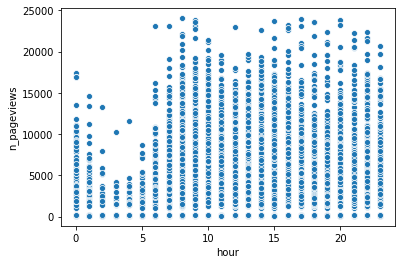

In [120]:
sns.scatterplot(data=test2, x="hour", y="n_pageviews")

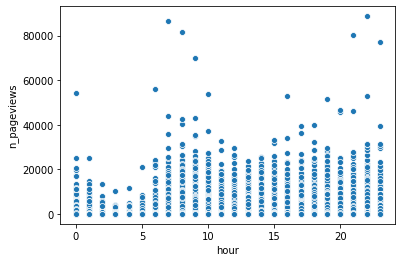

In [105]:
sns.scatterplot(data=test2, x="hour", y="n_pageviews")

In [30]:
df_reading = (
    pd.read_gbq(f'''

        SELECT 
          EXTRACT(DAYOFWEEK FROM pv.date) AS weekday,
          EXTRACT(HOUR FROM pv.timestamp AT TIME ZONE "Europe/Stockholm") AS hour, 
          device_category,
          login_status,
          referrer_category,
          section, 
          COUNT(DISTINCT pv.pageview_id) AS n_pageviews,
          COUNT(DISTINCT
            CASE WHEN LOWER(page_type) IN ("start page", "article list page") 
            THEN pv.pageview_id ELSE NULL END) AS n_flak_pageviews, 
          COUNT(DISTINCT
            CASE WHEN LOWER(page_type) IN ("articlepage", "article page") 
            THEN pv.pageview_id ELSE NULL END) AS n_article_pageviews, 
          ROUND(SUM(DISTINCT
            CASE WHEN ev.action = "Active Duration" 
            THEN SAFE_CAST(ev.label AS INT64) ELSE NULL END
            ) / 1000 / 60, 1) AS n_active_minutes
        FROM `{PROJECT}.reynolds.pageview` pv 
          JOIN `{PROJECT}.reynolds.event` ev ON ev.date = pv.date AND ev.pageview_id = pv.pageview_id
        WHERE 1=1
          AND pv.date BETWEEN "{FROM_DATE}" AND "{TO_DATE}"
          AND sub_brand = "DNSE"
          AND {ID} NOT IN ("", "N/A", "(not set)")
          AND {ID} IS NOT NULL
          #AND section IN ("Nyheter", "Ekonomi", "Kultur", "Sport", "Sthlm", "Gbg", "Ledare", "DN Debatt")
          AND content_id NOT IN ("", "N/A", "(not set)")
          AND content_id NOT LIKE "%dn.adhoc.%"
          AND content_id NOT LIKE "%dn.ctf%"
        GROUP BY 1,2,3,4,5,6

    ''', project_id=PROJECT)
)

# Fix weekdays from numbers to words.
transform_weekday(data=df_reading)

# Normalise values based on # of weeks.
df_reading[['n_pageviews', 'n_flak_pageviews', 'n_article_pageviews', 'n_active_minutes']] = normalise_weeks(from_date=FROM_DATE, to_date=TO_DATE, data=df_reading[['n_pageviews', 'n_flak_pageviews', 'n_article_pageviews', 'n_active_minutes']])

Downloading: 100%|██████████| 63036/63036 [00:04<00:00, 13651.23rows/s]


In [7]:
df_reading_comp = (
    pd.read_gbq(f'''

        SELECT 
          EXTRACT(DAYOFWEEK FROM pv.date) AS weekday,
          EXTRACT(HOUR FROM pv.timestamp AT TIME ZONE "Europe/Stockholm") AS hour, 
          device_category,
          login_status,
          referrer_category,
          section, 
          COUNT(DISTINCT pv.pageview_id) AS n_pageviews,
          COUNT(DISTINCT
            CASE WHEN LOWER(page_type) IN ("start page", "article list page")
            THEN pv.pageview_id ELSE NULL END) AS n_flak_pageviews, 
          COUNT(DISTINCT
            CASE WHEN LOWER(page_type) IN ("articlepage", "article page") 
            THEN pv.pageview_id ELSE NULL END) AS n_article_pageviews, 
          ROUND(SUM(DISTINCT
            CASE WHEN ev.action = "Active Duration" 
            THEN SAFE_CAST(ev.label AS INT64) ELSE NULL END
            ) / 1000 / 60, 1) AS n_active_minutes
        FROM `{PROJECT}.reynolds.pageview` pv 
          JOIN `{PROJECT}.reynolds.event` ev ON ev.date = pv.date AND ev.pageview_id = pv.pageview_id
        WHERE 1=1
          AND pv.date BETWEEN "{FROM_DATE_COMP}" AND "{TO_DATE_COMP}"
          AND sub_brand = "DNSE"
          AND {ID} NOT IN ("", "N/A", "(not set)")
          AND {ID} IS NOT NULL
          #AND section IN ("Nyheter", "Ekonomi", "Kultur", "Sport", "Sthlm", "Gbg", "Ledare", "DN Debatt")
          AND content_id NOT IN ("", "N/A", "(not set)")
          AND content_id NOT LIKE "%dn.adhoc.%"
          AND content_id NOT LIKE "%dn.ctf%"
        GROUP BY 1,2,3,4,5,6

    ''', project_id=PROJECT)
)

transform_weekday(data=df_reading_comp)
df_reading_comp[['n_pageviews', 'n_flak_pageviews', 'n_article_pageviews', 'n_active_minutes']] = normalise_weeks(from_date=FROM_DATE, to_date=TO_DATE, data=df_reading_comp[['n_pageviews', 'n_flak_pageviews', 'n_article_pageviews', 'n_active_minutes']])

Downloading: 100%|██████████| 85276/85276 [00:05<00:00, 14219.77rows/s]


In [57]:
#pd.DataFrame(df_reading.section.unique(), columns=['section'])

## 2. ARTICLE PUBLICATIONS

In [8]:
df_posting = (
    pd.read_gbq(f'''
        
        SELECT 
          s.name AS section,
          EXTRACT(DAYOFWEEK FROM publication_time AT TIME ZONE "Europe/Stockholm") AS weekday, # TEST REMOVE/ADD: AT TIME ZONE "Europe/Stockholm"
          EXTRACT(HOUR FROM publication_time AT TIME ZONE "Europe/Stockholm") AS hour,
          COUNT(DISTINCT art.identifier.id) AS n_publications
        FROM  `data-warehouse-dn.content.article` art,
        UNNEST(sections) s
        WHERE 1=1
          AND art.publication_time BETWEEN "{FROM_DATE}" AND "{TO_DATE}" 
          #AND section IN ("Nyheter", "Ekonomi", "Kultur", "Sport", "Sthlm", "Gbg", "Ledare", "DN Debatt")
        GROUP BY 1,2,3

    ''', project_id=PROJECT)
)

transform_weekday(data=df_posting)
df_posting[['n_publications']] = normalise_weeks(from_date=FROM_DATE, to_date=TO_DATE, data=df_posting[['n_publications']])

Downloading: 100%|██████████| 1122/1122 [00:00<00:00, 3010.26rows/s]


## 3. USERS

In [206]:
df_users = (
    pd.read_gbq(f'''
    
        SELECT 
          EXTRACT(DAYOFWEEK FROM pv.date) AS weekday,
          EXTRACT(HOUR FROM pv.timestamp AT TIME ZONE "Europe/Stockholm") AS hour, 
          #section, 
          COUNT(DISTINCT pv.user_id) AS n_accounts,
          COUNT(DISTINCT pv.client_id) AS n_browsers
        FROM `{PROJECT}.reynolds.pageview` pv 
        WHERE 1=1
          AND pv.date BETWEEN "{FROM_DATE}" AND "{TO_DATE}"
          AND sub_brand = "DNSE"
          AND {ID} NOT IN ("", "N/A", "(not set)")
          AND {ID} IS NOT NULL
          #AND section IN ("Nyheter", "Ekonomi", "Kultur", "Sport", "Sthlm", "Gbg", "Ledare", "DN Debatt")
          AND content_id NOT IN ("", "N/A", "(not set)")
          AND content_id NOT LIKE "%dn.adhoc.%"
          AND content_id NOT LIKE "%dn.ctf%"
        GROUP BY 1,2#,3

    ''', project_id=PROJECT)
)

transform_weekday(data=df_users)
df_users[['n_accounts', 'n_browsers']] = normalise_weeks(from_date=FROM_DATE, to_date=TO_DATE, data=df_users[['n_accounts', 'n_browsers']])

Downloading: 100%|██████████| 168/168 [00:00<00:00, 420.80rows/s]


In [213]:
df_users_comp = (
    pd.read_gbq(f'''
    
        SELECT 
          EXTRACT(DAYOFWEEK FROM pv.date) AS weekday,
          EXTRACT(HOUR FROM pv.timestamp AT TIME ZONE "Europe/Stockholm") AS hour, 
          #section, 
          COUNT(DISTINCT pv.user_id) AS n_accounts,
          COUNT(DISTINCT pv.client_id) AS n_browsers
        FROM `{PROJECT}.reynolds.pageview` pv 
        WHERE 1=1
          AND pv.date BETWEEN "{FROM_DATE_COMP}" AND "{TO_DATE_COMP}"
          AND sub_brand = "DNSE"
          AND {ID} NOT IN ("", "N/A", "(not set)")
          AND {ID} IS NOT NULL
          #AND section IN ("Nyheter", "Ekonomi", "Kultur", "Sport", "Sthlm", "Gbg", "Ledare", "DN Debatt")
          AND content_id NOT IN ("", "N/A", "(not set)")
          AND content_id NOT LIKE "%dn.adhoc.%"
          AND content_id NOT LIKE "%dn.ctf%"
        GROUP BY 1,2#,3

    ''', project_id=PROJECT)
)

transform_weekday(data=df_users_comp)
df_users_comp[['n_accounts', 'n_browsers']] = normalise_weeks(from_date=FROM_DATE, to_date=TO_DATE, data=df_users_comp[['n_accounts', 'n_browsers']])

Downloading: 100%|██████████| 168/168 [00:00<00:00, 489.42rows/s]


## 4. PURCHASING SUBSCRIPTIONS

In [ ]:
df_purchasing = (
    pd.read_gbq(f'''


    ''', project_id=PROJECT)
)

# VISUALSE: HEATMAPS

* The heatmaps function has a input variable "comp_data" referring to a comparable dataset. If you had a dataset to this variable, you can compare changes.

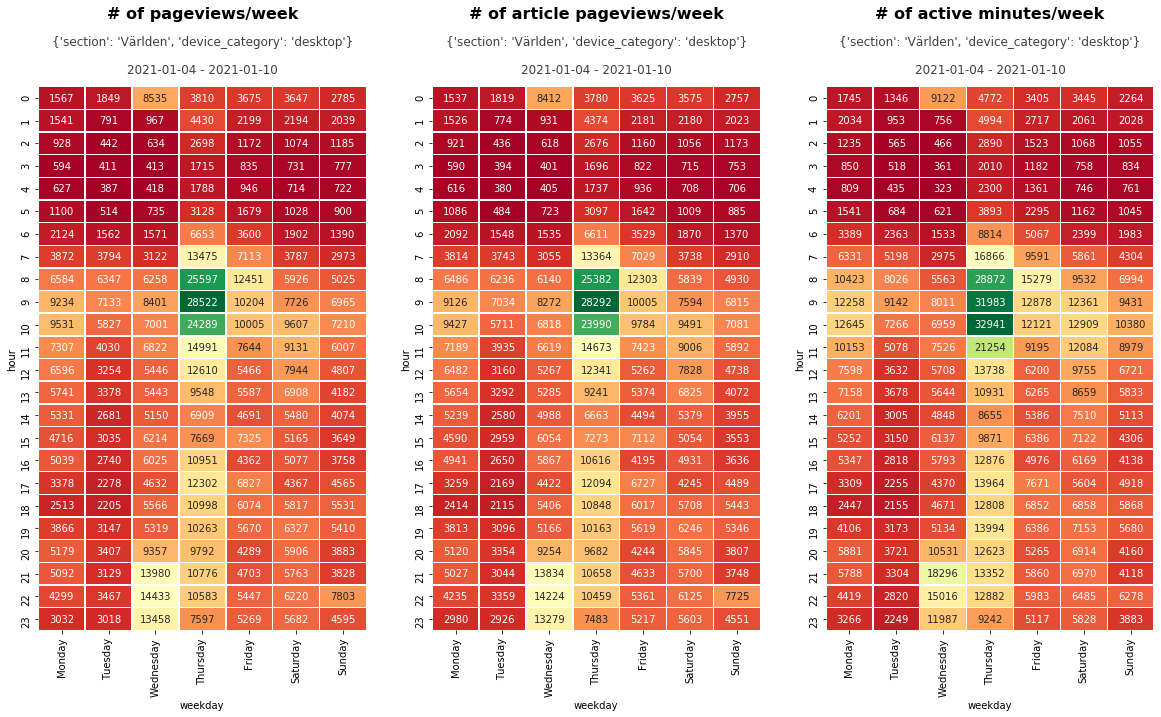

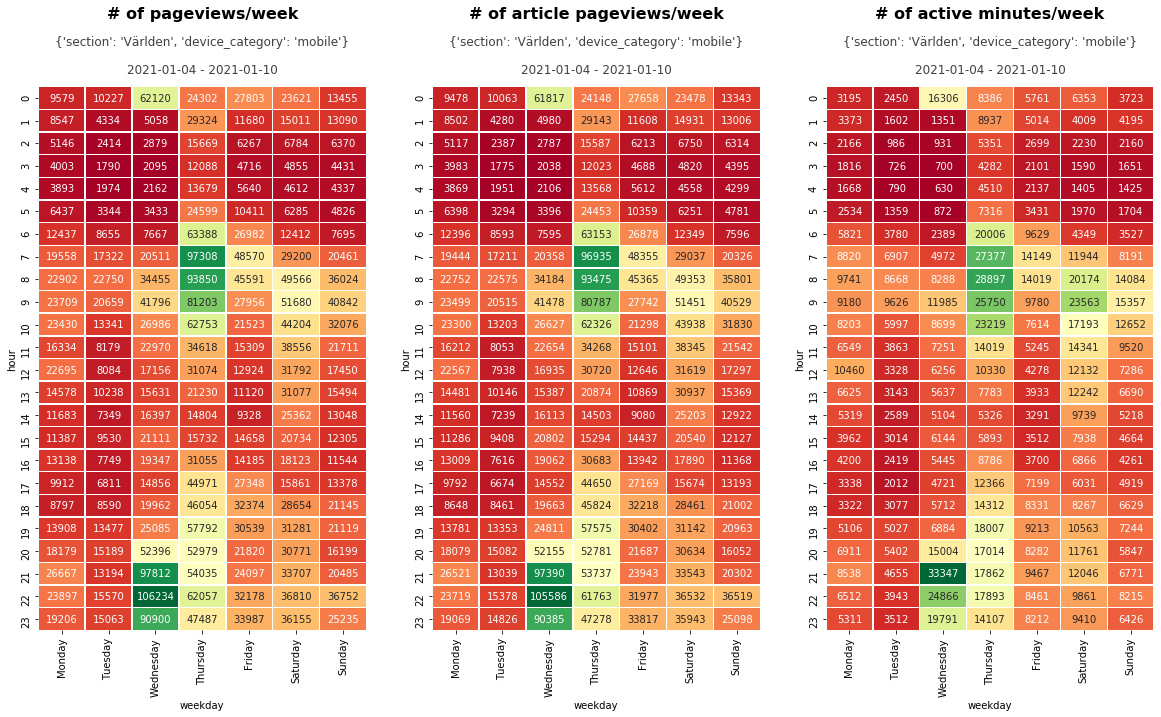

In [31]:
# Maximum three metrics!
metrics = {
    'n_pageviews': '# of pageviews/week', 
    'n_article_pageviews': '# of article pageviews/week', 
    'n_active_minutes': '# of active minutes/week'
}

# Select which sections to examine.
#sections = ['Sverige', 'Världen', 'Ekonomi', 'Kultur']
devices = ['desktop', 'mobile']

for val in devices:
    
    # Select filtering parameters
    params = {
        'section': 'Världen',
        'device_category': f'{val}',
        #'referrer_category': 'direct',
        #'login_status': 'Logged In'
        # ADD MORE
    }

    # Visualise behavioural heatmaps
    heatmap(params=params, 
            data=df_reading, 
            metrics=metrics,
            dates=dates); # add comp_data=df_reading_comp 

    plt.savefig(f'{FROM_DATE}_reading_{TO_DATE}_{params}.png')
    
    try: # If we insert no section parameter, don't loop unnecessarily. 
        params['section']
    except:
        break

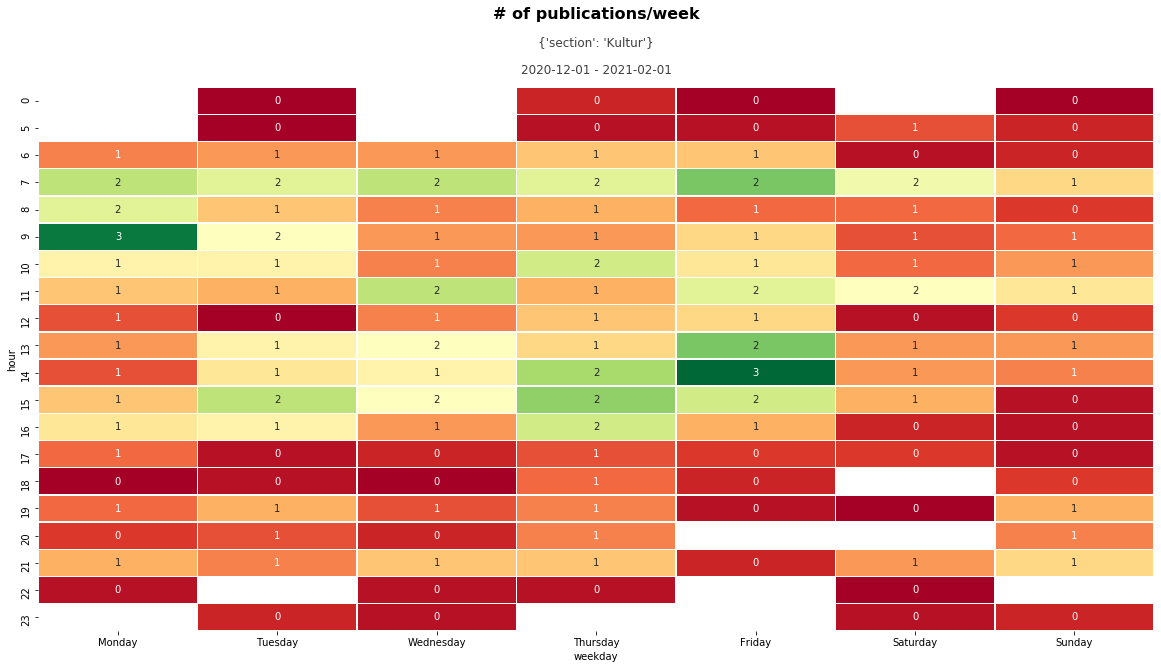

In [22]:
# Maximum three metrics!
metrics = {
    'n_publications': '# of publications/week'
}

params = {
        'section': 'Kultur',
        #'device_category': 'mobile',
        #'referrer_category': 'social'
        #'login_status': 'Logged Out'
        # ADD MORE
    }

# Visualise heatmaps
heatmap(params=params, 
        data=df_posting, 
        metrics=metrics,
        dates=dates); # add comp_data=df_reading_comp 

#plt.savefig(f'{FROM_DATE}_reading_{TO_DATE}_{params}.png')

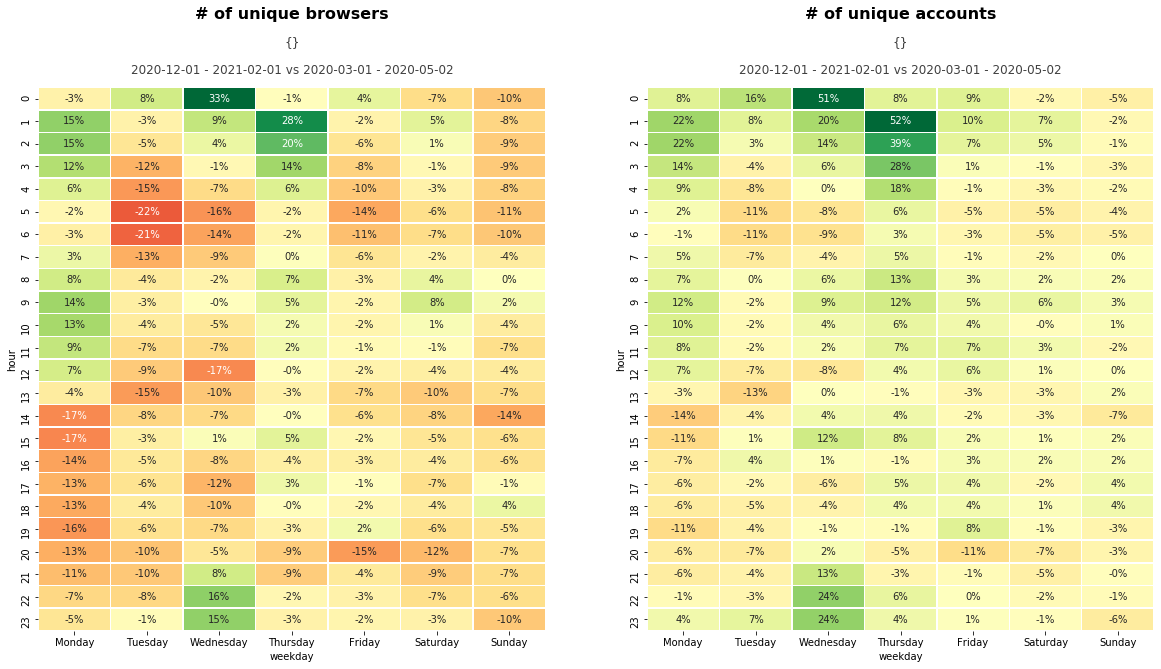

In [268]:
# Maximum three metrics!
metrics = {
    'n_browsers': '# of unique browsers',
    'n_accounts': '# of unique accounts'
}

params = {
        #'section': 'Ekonomi',
        #'device_category': 'mobile',
        #'referrer_category': 'social'
        #'login_status': 'Logged Out'
        # ADD MORE
    }

# Visualise heatmaps
heatmap(params=params, 
        data=df_users, 
        metrics=metrics,
        dates=dates,
        comp_data=df_users_comp); # add comp_data=df_reading_comp 

#plt.savefig(f'{FROM_DATE}_reading_{TO_DATE}_{params}.png')

# VISUALSE: COMPARE TO TIME PERIODS

# SLASK